In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
import itertools
import ast
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing_binary_utils as size_bin
import position_sizing_continuous_utils as size_cont
import trend_following_signal as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing_continuous_utils.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

In [7]:
from strategy_performance import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance_heatmap(df_performance):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def moving_avg_crossover_strategy_performance(start_date, end_date, ticker_list, fast_mavg_list=np.arange(10, 101, 10), slow_mavg_list=np.arange(50, 501, 50), rolling_donchian_window=20, long_only=True,
                                              initial_capital=15000, rolling_cov_window=20, volatility_window=20, transaction_cost_est=0.001, passive_trade_rate=0.05, use_coinbase_data=True,
                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
                                              signal_start_date=None):
    
    perf_cols = ['fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    mavg_stepsize_list = [2, 4, 6, 8]
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                                               mavg_stepsize, rolling_donchian_window, long_only, initial_capital,
                                                                               rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate,
                                                                               use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage, annualized_target_volatility,
                                                                               annual_trading_days, use_specific_start_date, signal_start_date)
                    performance_metrics = calculate_risk_and_performance_metrics(df, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
                    row = {
                        # 'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    }
                    df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    
    return df_performance

In [10]:
def plot_trend_following_performance_time_series(df, df_trend, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(22,20))
    layout = (5,2)
    trend_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    trend_donchian_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_signal_ax = plt.subplot2grid(layout, (2,0), colspan=2)
    trend_signal_ax2 = trend_signal_ax.twinx()
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (3,0), colspan=2)
    trend_return_ax = plt.subplot2grid(layout, (4,0))#, colspan=2)
    trend_cum_return_ax = plt.subplot2grid(layout, (4,1))#, colspan=2)

    _ = trend_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    for mavg in np.linspace(fast_mavg, slow_mavg, mavg_stepsize):
        _ = trend_ax.plot(df_trend.index, df_trend[f'{ticker}_{int(mavg)}_mavg'], label=f'{mavg} M Avg')

    _ = trend_ax.set_title(f'{ticker} Moving Average Ribbons - {start_date} - {end_date}')
    _ = trend_ax.set_ylabel('Price')
    _ = trend_ax.set_xlabel('Date')
    _ = trend_ax.legend(loc='upper left')
    _ = trend_ax.grid()

    _ = trend_donchian_ax.plot(df.index, df[f'{ticker}_t_1_close'], label='Price')
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'], label='Donchian Upper Band', linestyle='--', linewidth=3)
    _ = trend_donchian_ax.plot(df.index,
                      df[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'], label='Donchian Lower Band', linestyle='--', linewidth=3)

    _ = trend_donchian_ax.set_title(f'{ticker} Donchian Channels')
    _ = trend_donchian_ax.set_ylabel('Price')
    _ = trend_donchian_ax.set_xlabel('Date')
    _ = trend_donchian_ax.legend(loc='upper left')
    _ = trend_donchian_ax.grid()

    _ = trend_signal_ax.plot(df.index,
                             df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'], label='Signal')
    _ = trend_signal_ax2.plot(df.index, df[f'{ticker}_t_1_close'], label='Price', alpha=0.8, color='orange', linestyle='--')
    _ = trend_signal_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Signal')
    _ = trend_signal_ax.set_ylabel('Signal')
    _ = trend_signal_ax.set_xlabel('Date')
    _ = trend_signal_ax.legend(loc='upper left')
    _ = trend_signal_ax.grid()

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_50'],
                                     # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_rolling_sharpe_{rolling_sharpe_window}'],
                                     label='Sharpe Ratio', color='orange')
    _ = trend_rolling_sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'],
                             # df[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'],
                             label='Return')
    _ = trend_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    _ = trend_cum_return_ax.plot(df.index, df['strategy_cumulative_return'], label='Cum. Return')
    _ = trend_cum_return_ax.set_title(f'{ticker} Trend Strategy with Donchian Channel Cumulative Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_cum_return_ax.set_xlabel('Date')
    _ = trend_cum_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

## Save Crypto Data from Coinbase

In [13]:
ticker_list_save = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD','XRP-USD','AAVE-USD','MATIC-USD']

In [ ]:
for ticker in ticker_list_save:
    print(ticker)
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, start_date=None, 
                                                        end_date=pd.Timestamp('2025-06-30').date(), save_to_file=True)

## Trend Following Signal - Moving Average and Donchian Channel

In [15]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",  start_date),
            ("end_date",    end_date),
            ("ticker_list", ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("vol_of_vol_window_1",          vol_of_vol_window_1),
            ("vol_of_vol_window_2",          vol_of_vol_window_2),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",   lower_r_sqr_limit),
            ("upper_r_sqr_limit",   upper_r_sqr_limit),
            ("r2_window",           r2_window),
            ("rolling_sharpe_window", rolling_sharpe_window),
            ("use_activation", use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                 long_only),
            ("use_coinbase_data",         use_coinbase_data),
            ("use_saved_files",           use_saved_files),
            ("saved_file_end_date",       saved_file_end_date),
            ("use_specific_start_date",   use_specific_start_date),
            ("signal_start_date",         signal_start_date),
            ("price_or_returns_calc",     price_or_returns_calc),
            ("notional_threshold_pct",    notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [17]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [19]:
from scipy.stats import linregress

def calc_ribbon_slope(row, ticker, fast_mavg, slow_mavg, mavg_stepsize):
    x = np.linspace(slow_mavg, fast_mavg, mavg_stepsize)
    y = row.values
    slope, _, _, _, _ = linregress(x, y)
    return slope

In [21]:
def pct_rank(x, window=250):
    return x.rank(pct=True)

In [25]:
def calculate_average_directional_index(start_date, end_date, ticker, adx_period):
    
    ## Convert number of bars to days. ## alpha = 2/(span + 1) for the Exponentially Weighted Average
    ## If alpha = 1/n, span = 2*n - 1
    adx_atr_window = 2*adx_period - 1

    ## Pull Market Data
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = tf.load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose',
                      f'{ticker}_volume']
    
    ## Calculate Directional Move
    df[f'{ticker}_up_move'] = df[f'{ticker}_high'].diff()
    df[f'{ticker}_down_move'] = -df[f'{ticker}_low'].diff()
    
    plus_dir_move_cond = (df[f'{ticker}_up_move'] > df[f'{ticker}_down_move']) & (df[f'{ticker}_up_move'] > 0)
    minus_dir_move_cond = (df[f'{ticker}_down_move'] > df[f'{ticker}_up_move']) & (df[f'{ticker}_down_move'] > 0)
    df[f'{ticker}_plus_dir_move'] = np.where(plus_dir_move_cond, df[f'{ticker}_up_move'], 0)
    df[f'{ticker}_minus_dir_move'] = np.where(minus_dir_move_cond, df[f'{ticker}_down_move'], 0)
    
    ## Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[[f'{ticker}_high-low',f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{adx_atr_window}_avg_true_range'] = df[f'{ticker}_true_range_price'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the exponentially weighted directional moves
    df[f'{ticker}_plus_dir_move_exp'] = df[f'{ticker}_plus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    df[f'{ticker}_minus_dir_move_exp'] = df[f'{ticker}_minus_dir_move'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Calculate the directional indicator
    df[f'{ticker}_plus_dir_ind'] = 100 * (df[f'{ticker}_plus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_minus_dir_ind'] = 100 * (df[f'{ticker}_minus_dir_move_exp'] / df[f'{ticker}_{adx_atr_window}_avg_true_range'])
    df[f'{ticker}_dir_ind'] = 100 * np.abs((df[f'{ticker}_plus_dir_ind'] - df[f'{ticker}_minus_dir_ind'])) / (df[f'{ticker}_plus_dir_ind'] + df[f'{ticker}_minus_dir_ind'])
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_dir_ind'].ewm(span=adx_atr_window, adjust=False).mean()
    
    ## Shift by a day to avoid look-ahead bias
    df[f'{ticker}_avg_dir_ind'] = df[f'{ticker}_avg_dir_ind'].shift(1)

    return df[[f'{ticker}_avg_dir_ind']]

In [27]:
# def calculate_rolling_r2(df, ticker, t_1_close_price_col, r2_window=50, lower_r_sqr_limit=0.45, upper_r_sqr_limit=0.8):

#     log_price_col = f'{ticker}_t_1_close_price_log'
#     df[log_price_col] = np.log(df[t_1_close_price_col])
    
#     ## Define the variables
#     y = df[log_price_col]
#     x = np.arange(len(y), dtype=float) # Time

#     ## Compute rolling sums for rolling R2 calculation
#     x_sum = pd.Series(x, y.index).rolling(r2_window).sum()
#     y_sum = y.rolling(r2_window).sum()
#     x_sqr = pd.Series(x**2, y.index).rolling(r2_window).sum()
#     y_sqr = (y**2).rolling(r2_window).sum()
#     xy_sum = pd.Series(x, y.index).mul(y).rolling(r2_window).sum()

#     ## Calculate the R squared
#     n = r2_window
#     numerator = n * xy_sum - x_sum * y_sum
#     denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
#     df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

#     ## Normalize the R Squared centered around 0.5 where values below the lower limit are
#     ## clipped to 0 and values above 0.8 are clipped to 1
#     df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

#     return df

In [29]:
import scipy

def create_trend_strategy_log_space(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):
    
    # ---- constants ----
    # windows = 2**np.arange(np.log2(mavg_start), np.log2(mavg_end)+0.01, log_step).round().astype(int)   # e.g. 10,14,20,28,40,56
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x       = np.log(windows[::-1])
    xm      = x - x.mean()
    varx    = (xm**2).sum()
    
    # ---- compute MAs (vectorised) ----
    df[f'{ticker}_close_log'] = np.log(df[f'{ticker}_close'])
    for w in windows:
        df[f'{ticker}_{w}_ema'] = df[f'{ticker}_close_log'].ewm(span=w, adjust=False).mean()
    
    mavg_mat = df[[f'{ticker}_{w}_ema' for w in windows]].to_numpy()
    
    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx                        # ndarray (T,)
    slope = pd.Series(slope, index=df.index).shift(1)      # lag to avoid look-ahead
    
    # ---- z-score & rank ----
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window//5).std())

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5              # centred 0↔±0.5
    
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df[trend_continuous_signal_col] = slope
    df[trend_continuous_signal_rank_col] = rank

    return df

In [31]:
def calculate_donchian_channel_dual_window(start_date, end_date, ticker, price_or_returns_calc='price', entry_rolling_donchian_window=20, exit_rolling_donchian_window=20, 
                                           use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):
    if use_coinbase_data:
        if use_saved_files:
            date_list = cn.coinbase_start_date_by_ticker_dict
            file_end_date = pd.Timestamp(saved_file_end_date).date()
            filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
            output_file = f'coinbase_historical_price_folder/{filename}'
            df = pd.read_pickle(output_file)
            date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
            df = df[date_cond]
        else:
            # df = cn.get_coinbase_ohlc_data(ticker=ticker)
            df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                                end_date=end_date, save_to_file=False)
            df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']

    if price_or_returns_calc == 'price':
        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=entry_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=entry_rolling_donchian_window).min())

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=exit_rolling_donchian_window).max())

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = (
            df[f'close'].rolling(window=exit_rolling_donchian_window).min())

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        ## Entry Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=entry_rolling_donchian_window).min()

        ## Exit Channel
        # Rolling maximum of returns (upper channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).max()

        # Rolling minimum of returns (lower channel)
        df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'] = df[
            f'{ticker}_pct_returns'].rolling(window=exit_rolling_donchian_window).min()

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}']) / 2)

    # Exit Middle Band
    df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'] = (
        (df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'] +
         df[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}']) / 2)

    # Shift only the Keltner channel metrics to avoid look-ahead bias
    shift_columns = [
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}',
        f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}',
        f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    ]
    df[shift_columns] = df[shift_columns].shift(1)

    return df

In [33]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                                           exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight,
                                                           use_activation=True, tanh_activation_constant_dict=None, 
                                                           moving_avg_type='exponential', price_or_returns_calc='price',
                                                           long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=126)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f't_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Activation Scaled Signal
    if use_activation:
        final_signal_unscaled_95th_percentile = np.abs(df_trend[final_weighted_additive_signal_col]).quantile(0.95)
        if tanh_activation_constant_dict:
            k = tanh_activation_constant_dict[ticker]
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
        else:
            if (final_signal_unscaled_95th_percentile == 0):#| (final_signal_unscaled_95th_percentile.isnan()):
                k = 1.0
            else:
                k = np.arctanh(0.9) / final_signal_unscaled_95th_percentile
            df_trend[f'{ticker}_activation'] = np.tanh(df_trend[final_weighted_additive_signal_col] * k)
    else:
        df_trend[f'{ticker}_activation'] = df_trend[final_weighted_additive_signal_col]

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[f'{ticker}_activation'] = df_trend[f'{ticker}_activation'] * df_trend[donchian_binary_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[f'{ticker}_activation']), df_trend[f'{ticker}_activation'])

    return df_trend

def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                            exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight, 
                                            use_activation=True, tanh_activation_constant_dict=None, 
                                            long_only=False, price_or_returns_calc='price',
                                            use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        # lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        # upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, 
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [35]:
def apply_target_volatility_position_sizing_continuous_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, ma_crossover_signal_weight,
                                                                donchian_signal_weight, entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                use_activation=True, tanh_activation_constant_dict=None, long_only=False,
                                                                initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                rolling_atr_window=20, atr_multiplier=0.5,
                                                                transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30', 
                                                                rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                annual_trading_days=365, use_specific_start_date=False,
                                                                signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                       slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                       exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                       donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                       use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                                                       long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                                   rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                                   transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [37]:
def calculate_asset_level_returns(df, end_date, ticker_list):
    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    for ticker in ticker_list:
        df[f'{ticker}_daily_pnl'] = (df[f'{ticker}_actual_position_size'] * df[f'{ticker}_open'].diff().shift(-1))
        df[f'{ticker}_daily_pct_returns'] = (df[f'{ticker}_daily_pnl'] / df[f'total_portfolio_value'].shift(1)).fillna(0)
        df[f'{ticker}_position_count'] = np.where((df[f'{ticker}_actual_position_notional'] != 0), 1, 0) ## This is not entirely accurate
    return df

## Moving Average Ribbon and Donchian Channel Breakout Parameter Optimization

In [360]:
start_date = pd.to_datetime('2021-06-01').date()
end_date = pd.to_datetime('2023-12-31').date()
start_date_os = pd.to_datetime('2024-01-01').date()
end_date_os = pd.to_datetime('2025-06-30').date()
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']#,'XRP-USD','AAVE-USD']
fast_mavg = 16
slow_mavg = 224
mavg_stepsize = 8
entry_rolling_donchian_window = 28
exit_rolling_donchian_window = 28
use_donchian_exit_gate = False
long_only = True
use_coinbase_data = True
use_saved_files = True
saved_file_end_date = '2025-06-30'
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.70
rolling_atr_window = 20
atr_multiplier = 2.0
use_specific_start_date = False
signal_start_date = None
initial_capital = 15000
cash_buffer_percentage = 0.10
transaction_cost_est = 0.001#0.0025
passive_trade_rate = 0.05
notional_threshold_pct = 0.05
cooldown_counter_threshold = 3
rolling_sharpe_window = 50
price_or_returns_calc = 'price'
moving_avg_type = 'exponential'
use_coinbase_data = True

ma_crossover_signal_weight = 0.6
donchian_signal_weight = 0.4
use_activation = False
tanh_activation_constant_dict = None
lower_r_sqr_limit = 0.30
upper_r_sqr_limit = 0.90
r2_window = 80
vol_of_vol_window_1 = 20
vol_of_vol_window_2 = 15
vol_of_vol_z_score_window = 180
use_specific_start_date = True
signal_start_date = pd.Timestamp('2017-01-01').date()

In [362]:
print_strategy_params()


Strategy Parameters
-----------------------------------------------------------
start_date                    : 2021-06-01
end_date                      : 2023-12-31
ticker_list                   : ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

fast_mavg                     : 16
slow_mavg                     : 224
mavg_stepsize                 : 8
moving_avg_type               : exponential
ma_crossover_signal_weight    : 0.6

entry_rolling_donchian_window : 28
exit_rolling_donchian_window  : 28
use_donchian_exit_gate        : False
donchian_signal_weight        : 0.4

volatility_window             : 20
annualized_target_volatility  : 0.7
rolling_cov_window            : 20
rolling_atr_window            : 20
atr_multiplier                : 2.0
vol_of_vol_window_1           : 20
vol_of_vol_window_2           : 15
vol_of_vol_z_score_window     : 180

lower_r_sqr_limit             : 0.3
upper_r_sqr_limit             : 0.9
r2_window                     : 80
rolling_sharpe_window

## Analyze Walk Forward Analysis Results

In [43]:
df_performance_1 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2021-06-01-2023-11-30.pickle')
df_performance_2 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2021-12-01-2024-05-31.pickle')
df_performance_3 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2022-06-01-2024-11-30.pickle')
df_performance_4 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2022-12-01-2025-05-31.pickle')
df_performance = pd.concat([df_performance_1, df_performance_2, df_performance_3, df_performance_4], axis=0)

In [45]:
df_performance.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Performance-2021-06-01-2025-05-31.pickle')

In [47]:
## Get In-Sample Weights
df_performance_1_is = df_performance_1[df_performance_1.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_2_is = df_performance_2[df_performance_2.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_3_is = df_performance_2[df_performance_3.sampling_category == 'in_sample'].reset_index(drop=True)
df_performance_4_is = df_performance_2[df_performance_4.sampling_category == 'in_sample'].reset_index(drop=True)

## Get Out of Sample Weights
df_performance_1_os = df_performance_1[df_performance_1.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_2_os = df_performance_2[df_performance_2.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_3_os = df_performance_3[df_performance_3.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_4_os = df_performance_4[df_performance_4.sampling_category == 'out_sample'].reset_index(drop=True)

In [49]:
print(df_performance_1_os.shape)
print(df_performance_2_os.shape)
print(df_performance_3_os.shape)
print(df_performance_4_os.shape)

(216, 37)
(216, 37)
(216, 37)
(216, 37)


In [51]:
df_performance_os = pd.concat([df_performance_1_os, df_performance_2_os, df_performance_3_os, df_performance_4_os], axis=0)
df_performance_is = pd.concat([df_performance_1_is, df_performance_2_is, df_performance_3_is, df_performance_4_is], axis=0)

In [53]:
df_performance_os_strategy_performance = df_performance_os.groupby(['mavg_strategy','donchian_strategy']).agg(
    sharpe_mean=('annualized_sharpe_ratio', 'mean'),
    sharpe_std=('annualized_sharpe_ratio', 'std'),
    max_dd_mean=('max_drawdown', 'mean'),
    hit_rate=('annualized_sharpe_ratio', 'mean'),
    n_slices=('annualized_sharpe_ratio', 'size'),
).reset_index()
df_performance_os_strategy_performance['strategy_score'] = (df_performance_os_strategy_performance['sharpe_mean'] -
                                                            0.5 * df_performance_os_strategy_performance['sharpe_std'] +
                                                            df_performance_os_strategy_performance['max_dd_mean'])

In [55]:
df_performance_is_strategy_performance = df_performance_is.groupby(['mavg_strategy','donchian_strategy']).agg(
    sharpe_mean=('annualized_sharpe_ratio', 'mean'),
    sharpe_std=('annualized_sharpe_ratio', 'std'),
    max_dd_mean=('max_drawdown', 'mean'),
    hit_rate=('annualized_sharpe_ratio', 'mean'),
    n_slices=('annualized_sharpe_ratio', 'size'),
).reset_index()

In [57]:
df_performance_os_strategy_performance.sort_values('strategy_score', ascending=False)

mavg_strategy donchian_strategy  sharpe_mean  sharpe_std  max_dd_mean  \
74    f16_s224_n8   en28_ex28_gTrue     0.616187    1.115842    -0.256440   
75    f16_s224_n8   en28_ex7_gFalse     0.616187    1.115842    -0.256440   
72    f16_s224_n8  en28_ex14_gFalse     0.616187    1.115842    -0.256440   
148   f18_s216_n4  en40_ex10_gFalse     0.555375    0.997791    -0.254732   
150   f18_s216_n4  en40_ex20_gFalse     0.555375    0.997791    -0.254732   
152   f18_s216_n4  en40_ex30_gFalse     0.555375    0.997791    -0.254732   
154   f18_s216_n4  en40_ex40_gFalse     0.555375    0.997791    -0.254732   
155   f18_s216_n4   en40_ex40_gTrue     0.555375    0.997791    -0.254732   
73    f16_s224_n8   en28_ex21_gTrue     0.613305    1.116763    -0.256440   
153   f18_s216_n4   en40_ex30_gTrue     0.521700    0.958558    -0.258644   
177   f20_s200_n2   en40_ex30_gTrue     0.510015    0.942695    -0.261798   
179   f20_s200_n2   en40_ex40_gTrue     0.534142    0.995425    -0.259785   
172   f20_s200_n2  en40_ex10_gFalse     0.534142    0.995425    -0.259785   
174   f20_s200_n2  en40_ex20_gFalse     0.534142    0.995425    -0.259785   
178   f20_s200_n2  en40_ex40_gFalse     0.534142    0.995425    -0.259785   
176   f20_s200_n2  en40_ex30_gFalse     0.534142    0.995425    -0.259785   
85    f16_s256_n2   en28_ex21_gTrue     0.596017    1.222253    -0.238301   
80    f16_s224_n8  en40_ex30_gFalse     0.563375    1.127692    -0.257145   
76    f16_s224_n8  en40_ex10_gFalse     0.563375    1.127692    -0.257145   
83    f16_s224_n8   en40_ex40_gTrue     0.563375    1.127692    -0.257145   
82    f16_s224_n8  en40_ex40_gFalse     0.563375    1.127692    -0.257145   
78    f16_s224_n8  en40_ex20_gFalse     0.563375    1.127692    -0.257145   
169   f20_s200_n2   en28_ex21_gTrue     0.487901    0.980311    -0.259633   
151   f18_s216_n4   en40_ex20_gTrue     0.453019    0.897845    -0.266255   
156   f18_s216_n6  en28_ex14_gFalse     0.541819    1.100087    -0.263107   
158   f18_s216_n6   en28_ex28_gTrue     0.541819    1.100087    -0.263107   
159   f18_s216_n6   en28_ex7_gFalse     0.541819    1.100087    -0.263107   
157   f18_s216_n6   en28_ex21_gTrue     0.538457    1.099705    -0.263107   
81    f16_s224_n8   en40_ex30_gTrue     0.529655    1.088722    -0.261161   
168   f20_s200_n2  en28_ex14_gFalse     0.473456    1.011354    -0.261703   
170   f20_s200_n2   en28_ex28_gTrue     0.473456    1.011354    -0.261703   
171   f20_s200_n2   en28_ex7_gFalse     0.473456    1.011354    -0.261703   
166   f18_s216_n6  en40_ex40_gFalse     0.499237    1.097429    -0.261169   
162   f18_s216_n6  en40_ex20_gFalse     0.499237    1.097429    -0.261169   
160   f18_s216_n6  en40_ex10_gFalse     0.499237    1.097429    -0.261169   
164   f18_s216_n6  en40_ex30_gFalse     0.499237    1.097429    -0.261169   
167   f18_s216_n6   en40_ex40_gTrue     0.499237    1.097429    -0.261169   
79    f16_s224_n8   en40_ex20_gTrue     0.472523    1.039527    -0.267009   
119   f16_s256_n8   en40_ex40_gTrue     0.446919    1.011974    -0.259188   
118   f16_s256_n8  en40_ex40_gFalse     0.446919    1.011974    -0.259188   
112   f16_s256_n8  en40_ex10_gFalse     0.446919    1.011974    -0.259188   
114   f16_s256_n8  en40_ex20_gFalse     0.446919    1.011974    -0.259188   
116   f16_s256_n8  en40_ex30_gFalse     0.446919    1.011974    -0.259188   
165   f18_s216_n6   en40_ex30_gTrue     0.465827    1.059655    -0.265045   
117   f16_s256_n8   en40_ex30_gTrue     0.413791    0.970928    -0.263136   
180   f20_s200_n4  en28_ex14_gFalse     0.457735    1.042277    -0.275206   
182   f20_s200_n4   en28_ex28_gTrue     0.457735    1.042277    -0.275206   
183   f20_s200_n4   en28_ex7_gFalse     0.457735    1.042277    -0.275206   
181   f20_s200_n4   en28_ex21_gTrue     0.454359    1.041211    -0.275206   
110   f16_s256_n8   en28_ex28_gTrue     0.419897    1.012200    -0.266133   
111   f16_s256_n8   en28_ex7_gFalse     0.419897    1.012200    -0.266133   


In [59]:
strategy_cols = ['mavg_strategy','donchian_strategy']
df_performance_os_strategy_top_10 = df_performance_os_strategy_performance.nlargest(10, 'strategy_score')[strategy_cols]

df_weight_profile = (
    df_performance_os
    .merge(df_performance_os_strategy_top_10, on=strategy_cols)
    .groupby(['mavg_strategy', 'donchian_strategy', 'mavg_ribbon_weight'])
    .agg(mean_sharpe=('annualized_sharpe_ratio', 'mean'))
    .reset_index()
)

In [61]:
df_weight_profile.groupby(['mavg_strategy','donchian_strategy']).size()

mavg_strategy  donchian_strategy
f16_s224_n8    en28_ex14_gFalse     2
               en28_ex21_gTrue      2
               en28_ex28_gTrue      2
               en28_ex7_gFalse      2
f18_s216_n4    en40_ex10_gFalse     2
               en40_ex20_gFalse     2
               en40_ex30_gFalse     2
               en40_ex30_gTrue      2
               en40_ex40_gFalse     2
               en40_ex40_gTrue      2
dtype: int64

In [63]:
df_weight_profile

mavg_strategy donchian_strategy  mavg_ribbon_weight  mean_sharpe
0    f16_s224_n8  en28_ex14_gFalse                 0.8     1.599653
1    f16_s224_n8  en28_ex14_gFalse                 1.0     0.288365
2    f16_s224_n8   en28_ex21_gTrue                 0.8     1.599653
3    f16_s224_n8   en28_ex21_gTrue                 1.0     0.284522
4    f16_s224_n8   en28_ex28_gTrue                 0.8     1.599653
5    f16_s224_n8   en28_ex28_gTrue                 1.0     0.288365
6    f16_s224_n8   en28_ex7_gFalse                 0.8     1.599653
7    f16_s224_n8   en28_ex7_gFalse                 1.0     0.288365
8    f18_s216_n4  en40_ex10_gFalse                 0.6     1.460629
9    f18_s216_n4  en40_ex10_gFalse                 1.0     0.253623
10   f18_s216_n4  en40_ex20_gFalse                 0.6     1.460629
11   f18_s216_n4  en40_ex20_gFalse                 1.0     0.253623
12   f18_s216_n4  en40_ex30_gFalse                 0.6     1.460629
13   f18_s216_n4  en40_ex30_gFalse                 1.0     0.253623
14   f18_s216_n4   en40_ex30_gTrue                 0.6     1.325932
15   f18_s216_n4   en40_ex30_gTrue                 1.0     0.253623
16   f18_s216_n4  en40_ex40_gFalse                 0.6     1.460629
17   f18_s216_n4  en40_ex40_gFalse                 1.0     0.253623
18   f18_s216_n4   en40_ex40_gTrue                 0.6     1.460629
19   f18_s216_n4   en40_ex40_gTrue                 1.0     0.253623

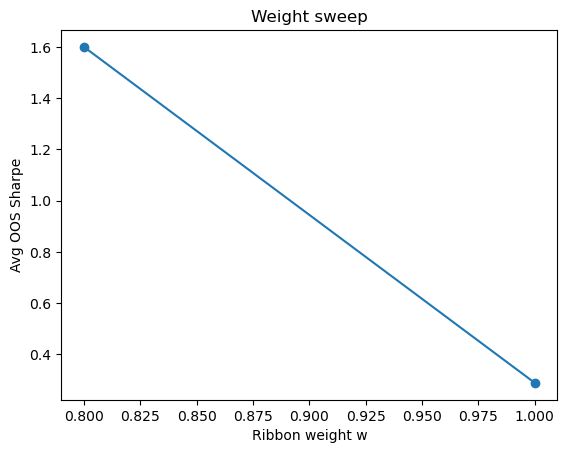

In [65]:
# Example: plot Sharpe vs weight for one pair

strategy_cond = (df_weight_profile['mavg_strategy'] == 'f16_s224_n8') & (df_weight_profile['donchian_strategy'] == 'en28_ex14_gFalse')
pair = df_weight_profile[strategy_cond]
# pair = df_weight_profile.query("mavg_strategy == 'f16_s224_n8' & donchian_strategy == 'en40_ex20_gFalse'")
plt.plot(pair["mavg_ribbon_weight"], pair["mean_sharpe"], marker="o")
plt.xlabel("Ribbon weight w"); plt.ylabel("Avg OOS Sharpe"); plt.title("Weight sweep")
plt.show()

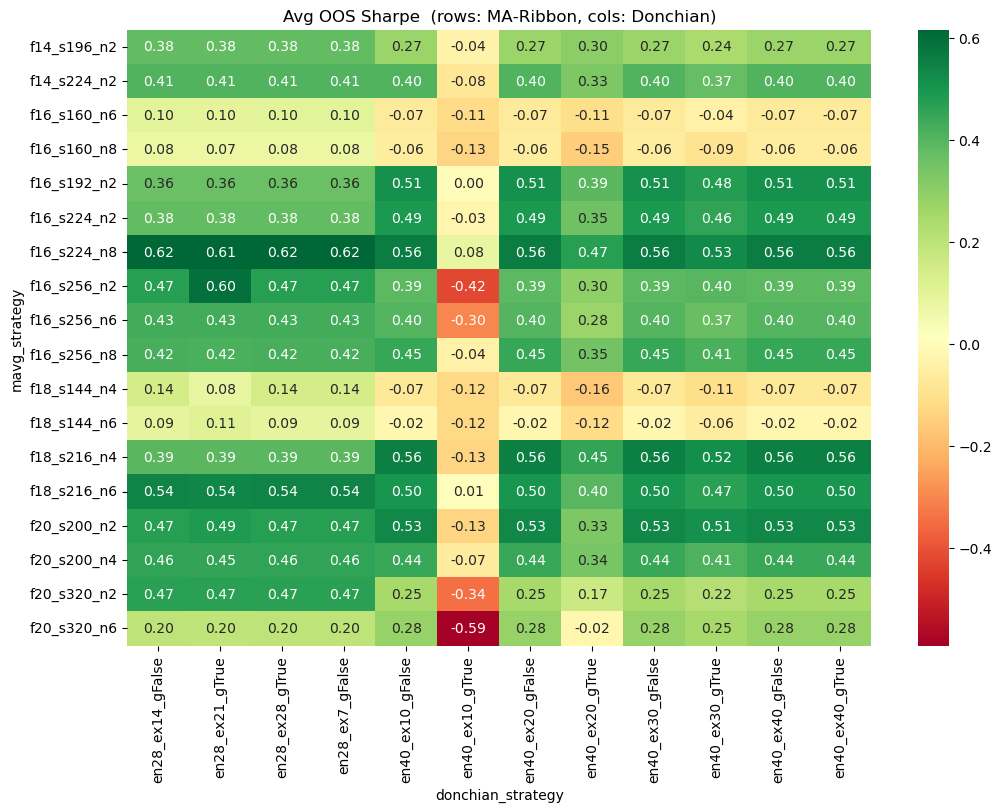

In [67]:
heat = df_performance_os_strategy_performance.pivot_table(
        index="mavg_strategy",
        columns="donchian_strategy",
        values="sharpe_mean")

import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.heatmap(heat, annot=True, fmt=".2f", cmap="RdYlGn")
plt.title("Avg OOS Sharpe  (rows: MA‑Ribbon, cols: Donchian)")
plt.show()

In [69]:
coin_cols = [c for c in df_performance_os.columns if c.endswith("_annualized_sharpe_ratio")]

coin_sharpe = (
    df_performance_os
    .groupby(["mavg_strategy", "donchian_strategy"])[coin_cols]
    .mean()
)

# Add the average cross‑coin dispersion
coin_sharpe["coin_sharpe_stdev"] = coin_sharpe.std(axis=1)
df_performance_os_strategy_performance = df_performance_os_strategy_performance.merge(coin_sharpe["coin_sharpe_stdev"],
                                                                                      on=["mavg_strategy","donchian_strategy"])

In [71]:
df_performance_os_strategy_performance.sort_values('strategy_score', ascending=False)

mavg_strategy donchian_strategy  sharpe_mean  sharpe_std  max_dd_mean  \
74    f16_s224_n8   en28_ex28_gTrue     0.616187    1.115842    -0.256440   
75    f16_s224_n8   en28_ex7_gFalse     0.616187    1.115842    -0.256440   
72    f16_s224_n8  en28_ex14_gFalse     0.616187    1.115842    -0.256440   
148   f18_s216_n4  en40_ex10_gFalse     0.555375    0.997791    -0.254732   
150   f18_s216_n4  en40_ex20_gFalse     0.555375    0.997791    -0.254732   
152   f18_s216_n4  en40_ex30_gFalse     0.555375    0.997791    -0.254732   
154   f18_s216_n4  en40_ex40_gFalse     0.555375    0.997791    -0.254732   
155   f18_s216_n4   en40_ex40_gTrue     0.555375    0.997791    -0.254732   
73    f16_s224_n8   en28_ex21_gTrue     0.613305    1.116763    -0.256440   
153   f18_s216_n4   en40_ex30_gTrue     0.521700    0.958558    -0.258644   
177   f20_s200_n2   en40_ex30_gTrue     0.510015    0.942695    -0.261798   
179   f20_s200_n2   en40_ex40_gTrue     0.534142    0.995425    -0.259785   
172   f20_s200_n2  en40_ex10_gFalse     0.534142    0.995425    -0.259785   
174   f20_s200_n2  en40_ex20_gFalse     0.534142    0.995425    -0.259785   
178   f20_s200_n2  en40_ex40_gFalse     0.534142    0.995425    -0.259785   
176   f20_s200_n2  en40_ex30_gFalse     0.534142    0.995425    -0.259785   
85    f16_s256_n2   en28_ex21_gTrue     0.596017    1.222253    -0.238301   
80    f16_s224_n8  en40_ex30_gFalse     0.563375    1.127692    -0.257145   
76    f16_s224_n8  en40_ex10_gFalse     0.563375    1.127692    -0.257145   
83    f16_s224_n8   en40_ex40_gTrue     0.563375    1.127692    -0.257145   
82    f16_s224_n8  en40_ex40_gFalse     0.563375    1.127692    -0.257145   
78    f16_s224_n8  en40_ex20_gFalse     0.563375    1.127692    -0.257145   
169   f20_s200_n2   en28_ex21_gTrue     0.487901    0.980311    -0.259633   
151   f18_s216_n4   en40_ex20_gTrue     0.453019    0.897845    -0.266255   
156   f18_s216_n6  en28_ex14_gFalse     0.541819    1.100087    -0.263107   
158   f18_s216_n6   en28_ex28_gTrue     0.541819    1.100087    -0.263107   
159   f18_s216_n6   en28_ex7_gFalse     0.541819    1.100087    -0.263107   
157   f18_s216_n6   en28_ex21_gTrue     0.538457    1.099705    -0.263107   
81    f16_s224_n8   en40_ex30_gTrue     0.529655    1.088722    -0.261161   
168   f20_s200_n2  en28_ex14_gFalse     0.473456    1.011354    -0.261703   
170   f20_s200_n2   en28_ex28_gTrue     0.473456    1.011354    -0.261703   
171   f20_s200_n2   en28_ex7_gFalse     0.473456    1.011354    -0.261703   
166   f18_s216_n6  en40_ex40_gFalse     0.499237    1.097429    -0.261169   
162   f18_s216_n6  en40_ex20_gFalse     0.499237    1.097429    -0.261169   
160   f18_s216_n6  en40_ex10_gFalse     0.499237    1.097429    -0.261169   
164   f18_s216_n6  en40_ex30_gFalse     0.499237    1.097429    -0.261169   
167   f18_s216_n6   en40_ex40_gTrue     0.499237    1.097429    -0.261169   
79    f16_s224_n8   en40_ex20_gTrue     0.472523    1.039527    -0.267009   
119   f16_s256_n8   en40_ex40_gTrue     0.446919    1.011974    -0.259188   
118   f16_s256_n8  en40_ex40_gFalse     0.446919    1.011974    -0.259188   
112   f16_s256_n8  en40_ex10_gFalse     0.446919    1.011974    -0.259188   
114   f16_s256_n8  en40_ex20_gFalse     0.446919    1.011974    -0.259188   
116   f16_s256_n8  en40_ex30_gFalse     0.446919    1.011974    -0.259188   
165   f18_s216_n6   en40_ex30_gTrue     0.465827    1.059655    -0.265045   
117   f16_s256_n8   en40_ex30_gTrue     0.413791    0.970928    -0.263136   
180   f20_s200_n4  en28_ex14_gFalse     0.457735    1.042277    -0.275206   
182   f20_s200_n4   en28_ex28_gTrue     0.457735    1.042277    -0.275206   
183   f20_s200_n4   en28_ex7_gFalse     0.457735    1.042277    -0.275206   
181   f20_s200_n4   en28_ex21_gTrue     0.454359    1.041211    -0.275206   
110   f16_s256_n8   en28_ex28_gTrue     0.419897    1.012200    -0.266133   
111   f16_s256_n8   en28_ex7_gFalse     0.419897    1.012200    -0.266133   


In [73]:
final = (
    df_performance_os_strategy_performance
    .query("sharpe_mean > 1.0")           # your hurdle
    .query("max_dd_mean > -0.45")            # max 45 % drawdown
    .sort_values(["strategy_score", "coin_sharpe_stdev"], ascending=[False, True])
)

final.head(10)[["mavg_strategy","donchian_strategy","sharpe_mean","max_dd_mean","strategy_score"]]

Empty DataFrame
Columns: [mavg_strategy, donchian_strategy, sharpe_mean, max_dd_mean, strategy_score]
Index: []

In [ ]:
df_weight_profile[strategy_cond]

In [ ]:
pair

In [ ]:
df_performance_os_strategy_performance.nlargest(5, 'strategy_score')[['mavg_strategy','donchian_strategy']]

In [ ]:
df_performance_os[(df_performance_os.mavg_strategy == 'f16_s224_n8') & (df_performance_os.donchian_strategy == 'en28_ex28_gTrue')]

In [ ]:
df_performance_is_strategy_performance[(df_performance_is_strategy_performance.mavg_strategy == 'f16_s224_n8') & (df_performance_is_strategy_performance.donchian_strategy == 'en28_ex28_gTrue')]

## Walk Forward Analysis with Only Best Pairs

In [45]:
import itertools

def generate_mavg_ribbon_donchian_channel_params():
    parameter_grid = {
        "mavg_ribbon_strategy": ['f16_s224_n2','f16_s224_n4','f16_s224_n6','f16_s224_n8','f18_s216_n2','f18_s216_n4','f18_s216_n6','f18_s216_n8'],
        "donchian_channel_strategy": ['en28_ex7_gFalse','en28_ex14_gFalse','en28_ex21_gFalse','en28_ex28_gFalse',
                                      'en28_ex7_gTrue','en28_ex14_gTrue','en28_ex21_gTrue','en28_ex28_gTrue',
                                      'en40_ex10_gFalse','en40_ex20_gFalse','en40_ex30_gFalse','en40_ex40_gFalse',
                                      'en40_ex10_gTrue','en40_ex20_gTrue','en40_ex30_gTrue','en40_ex40_gTrue']
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [47]:
def run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date, end_date, ticker_list):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'mavg_strategy', 'donchian_strategy', 'mavg_ribbon_weight', 'donchian_weight', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(years=2)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date:
            break
    
        for params in generate_mavg_ribbon_donchian_channel_params():
            print(params)
            mavg_strategy_params = params['mavg_ribbon_strategy']
            donchian_strategy_params = params['donchian_channel_strategy']
            
            ## Moving Average Ribbon Params
            fast_mavg = int(mavg_strategy_params.split('_')[0][1:])
            slow_mavg = int(mavg_strategy_params.split('_')[1][1:])
            mavg_stepsize = int(mavg_strategy_params.split('_')[2][1:])
            
            ## Donchian Channel Params
            entry_window = int(donchian_strategy_params.split('_')[0][2:])
            exit_window = int(donchian_strategy_params.split('_')[1][2:])
            exit_gate = ast.literal_eval(donchian_strategy_params.split('_')[2][1:])
            
            print(mavg_strategy_params, donchian_strategy_params)
            print(fast_mavg, slow_mavg, mavg_stepsize, entry_window, exit_window, exit_gate)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            for w in np.linspace(0, 1, 11):
                w_mavg = round(w, 2)
                w_donchian = round(1 - round(w, 2), 2)
                print(f'M Avg Ribbon Weight: {w_mavg}, Donchian Channel Weight: {w_donchian}')
                df_is = apply_target_volatility_position_sizing_continuous_strategy(
                    start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, long_only=long_only,
                    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                    annualized_target_volatility=annualized_target_volatility,
                    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
                print('Calculating In Sample Asset Returns!!')
                df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

                ## In Sample Performance Metrics
                print('Getting In Sample Performance Metrics!!')
                row_parameters_is = {
                    'sampling_category': 'in_sample',
                    'start_date': start_date_is,
                    'end_date': end_date_is,
                    'mavg_strategy': mavg_strategy_params,
                    'donchian_strategy': donchian_strategy_params,
                    'mavg_ribbon_weight': w_mavg,
                    'donchian_weight': w_donchian
                }
                portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                   strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                                   passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

                print('Getting In Sample Asset Performance!!')
                for ticker in ticker_list:
                    ## In Sample
                    ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                         strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                         annual_trading_days=365, include_transaction_costs_and_fees=False)
                    ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                    ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                    portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
                
                row_parameters_is.update(portfolio_perf_metrics_is)
    
                ## Assign in sample metrics to performance dataframe
                df_performance.loc[df_performance.shape[0]] = row_parameters_is

            ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
            in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
            strategy_cond = (df_performance['mavg_strategy'] == mavg_strategy_params) & (df_performance['donchian_strategy'] == donchian_strategy_params)
            date_cond = (df_performance['start_date'] == start_date_is) & (df_performance['end_date'] == end_date_is)
            best_in_sample_mavg_weight = df_performance[in_sample_cond & strategy_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['mavg_ribbon_weight'].iloc[0]
            best_in_sample_donchian_weight = df_performance[in_sample_cond & strategy_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['donchian_weight'].iloc[0]
            
            ## Out of Sample Dataframe
            print('Pulling Out of Sample Data!!')
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=best_in_sample_mavg_weight, donchian_signal_weight=best_in_sample_donchian_weight, 
                long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'mavg_strategy': mavg_strategy_params,
                'donchian_strategy': donchian_strategy_params,
                'mavg_ribbon_weight': best_in_sample_mavg_weight,
                'donchian_weight': best_in_sample_donchian_weight
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)

            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [49]:
start_date = pd.Timestamp('2021-06-01').date()
end_date = pd.Timestamp('2025-06-30').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(years=2)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
    if end_date_os > end_date:
        break
    start_date_is = (start_date_is + OS_LEN).date()

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
In Sample Start: 2022-06-01, In Sample End: 2024-05-31, Out of Sample Start: 2024-06-01, Out of Sample End: 2024-11-30
In Sample Start: 2022-12-01, In Sample End: 2024-11-30, Out of Sample Start: 2024-12-01, Out of Sample End: 2025-05-31
In Sample Start: 2023-06-01, In Sample End: 2025-05-31, Out of Sample Start: 2025-06-01, Out of Sample End: 2025-11-30


In [81]:
%%time
df_performance_1 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list)

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
{'mavg_ribbon_strategy': 'f16_s224_n2', 'donchian_channel_strategy': 'en28_ex7_gFalse'}
f16_s224_n2 en28_ex7_gFalse
16 224 2 28 7 False
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.1, Donchian Channel Weight: 0.9
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [82]:
df_performance_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance-2021-06-01-2023-11-30.pickle')

In [83]:
%%time
df_performance_2 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date='2021-12-01', end_date='2024-05-31', ticker_list=ticker_list)

In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
{'mavg_ribbon_strategy': 'f16_s224_n2', 'donchian_channel_strategy': 'en28_ex7_gFalse'}
f16_s224_n2 en28_ex7_gFalse
16 224 2 28 7 False
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.1, Donchian Channel Weight: 0.9
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [84]:
df_performance_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance_Best_Pairs-2021-12-01-2024-05-31.pickle')

In [85]:
%%time
df_performance_3 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date='2022-06-01', end_date='2024-11-30', ticker_list=ticker_list)

In Sample Start: 2022-06-01, In Sample End: 2024-05-31, Out of Sample Start: 2024-06-01, Out of Sample End: 2024-11-30
{'mavg_ribbon_strategy': 'f16_s224_n2', 'donchian_channel_strategy': 'en28_ex7_gFalse'}
f16_s224_n2 en28_ex7_gFalse
16 224 2 28 7 False
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.1, Donchian Channel Weight: 0.9
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [86]:
df_performance_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance_Best_Pairs-2022-06-01-2024-11-30.pickle')

In [87]:
%%time
df_performance_4 = run_walk_forward_mavg_ribbon_donchian_ribbon_best_pairs(start_date='2022-12-01', end_date='2025-05-31', ticker_list=ticker_list)

In Sample Start: 2022-12-01, In Sample End: 2024-11-30, Out of Sample Start: 2024-12-01, Out of Sample End: 2025-05-31
{'mavg_ribbon_strategy': 'f16_s224_n2', 'donchian_channel_strategy': 'en28_ex7_gFalse'}
f16_s224_n2 en28_ex7_gFalse
16 224 2 28 7 False
Pulling In Sample Data!!
M Avg Ribbon Weight: 0.0, Donchian Channel Weight: 1.0
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
M Avg Ribbon Weight: 0.1, Donchian Channel Weight: 0.9
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [88]:
df_performance_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance_Best_Pairs-2022-12-01-2025-05-31.pickle')

In [99]:
df_performance = pd.concat([df_performance_1, df_performance_2, df_performance_3, df_performance_4], axis=0, ignore_index=True)

In [105]:
df_performance.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance_Best_Pairs-2021-06-01-2025-05-31.pickle')

In [103]:
df_performance.shape

(6144, 37)

## Analyze Performance of Walk Forward Analysis

In [42]:
df_performance = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Best_Pairs_Gate_Stepsize_Performance_Best_Pairs-2021-06-01-2025-05-31.pickle')

In [44]:
os_cond = (df_performance['sampling_category'] == 'out_sample')
df_performance_os = df_performance[os_cond].reset_index(drop=True)
df_performance_is = df_performance[~os_cond].reset_index(drop=True)

In [46]:
import re

def parse_ma(s):
    # e.g. 'f16_s224_n8'
    fast  = int(re.search(r"f(\d+)", s).group(1))
    slow  = int(re.search(r"s(\d+)", s).group(1))
    step  = int(re.search(r"n(\d+)", s).group(1))
    return fast, slow, step

def parse_don(s):
    # e.g. 'en28_ex14_gTrue'
    entry  = int(re.search(r"en(\d+)", s).group(1))
    exit_  = int(re.search(r"ex(\d+)", s).group(1))
    gate   = re.search(r"g(True|False)", s).group(1) == "True"
    return entry, exit_, gate

In [48]:
## Out of Sample
df_performance_os[["fast","slow","step"]] = list(df_performance_os["mavg_strategy"].map(parse_ma))
df_performance_os[["entry","exit","gate"]] = list(df_performance_os["donchian_strategy"].map(parse_don))

# Your two clusters label
df_performance_os["cluster"] = np.where((df_performance_os["fast"]==16)&(df_performance_os["slow"]==224), "MA_16_224", "MA_18_216")

## In-Sample
df_performance_is[["fast","slow","step"]] = list(df_performance_is["mavg_strategy"].map(parse_ma))
df_performance_is[["entry","exit","gate"]] = list(df_performance_is["donchian_strategy"].map(parse_don))

# Your two clusters label
df_performance_is["cluster"] = np.where((df_performance_is["fast"]==16)&(df_performance_is["slow"]==224), "MA_16_224", "MA_18_216")

In [50]:
df_performance_os[(df_performance_os.cluster == 'MA_16_224') & (df_performance_os.donchian_strategy == 'en28_ex28_gFalse')]#.head(20)

sampling_category  start_date    end_date mavg_strategy donchian_strategy  \
3          out_sample  2023-06-01  2023-11-30   f16_s224_n2  en28_ex28_gFalse   
19         out_sample  2023-06-01  2023-11-30   f16_s224_n4  en28_ex28_gFalse   
35         out_sample  2023-06-01  2023-11-30   f16_s224_n6  en28_ex28_gFalse   
51         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
131        out_sample  2023-12-01  2024-05-31   f16_s224_n2  en28_ex28_gFalse   
147        out_sample  2023-12-01  2024-05-31   f16_s224_n4  en28_ex28_gFalse   
163        out_sample  2023-12-01  2024-05-31   f16_s224_n6  en28_ex28_gFalse   
179        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
259        out_sample  2024-06-01  2024-11-30   f16_s224_n2  en28_ex28_gFalse   
275        out_sample  2024-06-01  2024-11-30   f16_s224_n4  en28_ex28_gFalse   
291        out_sample  2024-06-01  2024-11-30   f16_s224_n6  en28_ex28_gFalse   
307        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
387        out_sample  2024-12-01  2025-05-31   f16_s224_n2  en28_ex28_gFalse   
403        out_sample  2024-12-01  2025-05-31   f16_s224_n4  en28_ex28_gFalse   
419        out_sample  2024-12-01  2025-05-31   f16_s224_n6  en28_ex28_gFalse   
435        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   

     mavg_ribbon_weight  donchian_weight  annualized_return  \
3                   0.8              0.2           0.801242   
19                  0.7              0.3           0.860149   
35                  0.7              0.3           0.739236   
51                  0.8              0.2           0.876251   
131                 0.2              0.8          -0.091100   
147                 1.0              0.0           0.226841   
163                 1.0              0.0           0.234574   
179                 1.0              0.0           0.104999   
259                 1.0              0.0           0.891432   
275                 0.9              0.1           1.118257   
291                 1.0              0.0           0.678979   
307                 1.0              0.0           0.823386   
387                 0.9              0.1          -0.301116   
403                 0.9              0.1          -0.297728   
419                 1.0              0.0          -0.191689   
435                 1.0              0.0          -0.189130   

     annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
3                   1.487868      2.544371            0.514749     -0.314908   
19                  1.573722      2.905780            0.510603     -0.296013   
35                  1.406795      2.320305            0.510115     -0.318594   
51                  1.599653      2.921789            0.500732     -0.299902   
131                -0.057105     -0.376981            0.586666     -0.241656   
147                 0.559869      0.856639            0.595524     -0.264804   
163                 0.572324      0.887451            0.601853     -0.264324   
179                 0.352771      0.397185            0.606666     -0.264357   
259                 1.459133      3.487521            0.613628     -0.255606   
275                 1.701801      4.362815            0.618391     -0.256315   
291                 1.198465      2.340660            0.612466     -0.290080   
307                 1.360579      2.834063            0.616417     -0.290532   
387                -1.368791     -1.522907            0.485541     -0.197725   
403                -1.331301     -1.500316            0.494248     -0.198444   
419                -0.866479     -1.117252            0.465081     -0.171572   
435                -0.848256     -1.106217            0.471063     -0.170970   

    max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
3                110 days  0.351852     1.068363  0.286956        234.0   
19               108 days  0.358025     1.1

In [52]:
## Top 15 Out of Sample Strategy Performance
group_cols = ["cluster","entry","exit","gate","step"]

df_performance_summary_os = (
    df_performance_os.groupby(group_cols)
    .agg(
        mean_sharpe      = ("annualized_sharpe_ratio","mean"),
        sharpe_std       = ("annualized_sharpe_ratio","std"),
        worst_sharpe     = ("annualized_sharpe_ratio","min"),
        pos_sharpe_pct   = ("annualized_sharpe_ratio", lambda x: (x > 0).mean()),  # % of slices with Sharpe > 0
        worst_dd         = ("max_drawdown","min"),
        mean_dd          = ("max_drawdown","mean"),
        mean_return      = ("annualized_return","mean"),
        mean_trade_count = ("trade_count","mean"),
    )
    .reset_index()
)

## Get the Standard Deviation of the per Coin Sharpe Ratios
coin_cols = [c for c in df_performance_os.columns if c.endswith("_annualized_sharpe_ratio")]
coin_disp = (df_performance_os.groupby(group_cols)[coin_cols].mean().std(axis=1)
             .rename("coin_sharpe_std").reset_index())
df_performance_summary_os = pd.merge(df_performance_summary_os, coin_disp, on=group_cols, how='left')

# A composite score that rewards level + stability + shallower DD, penalises turnover
lam_std, lam_dd, lam_turn = 0.5, 0.1, 1e-4  # tune lam_turn to your fee model
df_performance_summary_os["strategy_score"] = (
    df_performance_summary_os["mean_sharpe"] - lam_std * df_performance_summary_os["sharpe_std"]
    + lam_dd  * df_performance_summary_os["worst_dd"]      # DD is negative; adding improves score when less negative
    - lam_turn* df_performance_summary_os["mean_trade_count"]
)

df_performance_summary_os = df_performance_summary_os.sort_values("strategy_score", ascending=False)
df_performance_summary_os.head(15)


cluster  entry  exit   gate  step  mean_sharpe  sharpe_std  \
26   MA_16_224     28    28  False     6     0.577777    1.026065   
2    MA_16_224     28     7  False     6     0.577777    1.026065   
30   MA_16_224     28    28   True     6     0.577777    1.026065   
18   MA_16_224     28    21  False     6     0.577777    1.026065   
10   MA_16_224     28    14  False     6     0.577777    1.026065   
22   MA_16_224     28    21   True     6     0.574293    1.026114   
27   MA_16_224     28    28  False     8     0.616187    1.115842   
3    MA_16_224     28     7  False     8     0.616187    1.115842   
31   MA_16_224     28    28   True     8     0.616187    1.115842   
19   MA_16_224     28    21  False     8     0.616187    1.115842   
11   MA_16_224     28    14  False     8     0.616187    1.115842   
113  MA_18_216     40    30  False     4     0.555375    0.997791   
97   MA_18_216     40    10  False     4     0.555375    0.997791   
121  MA_18_216     40    40  False     4     0.555375    0.997791   
105  MA_18_216     40    20  False     4     0.555375    0.997791   

     worst_sharpe  pos_sharpe_pct  worst_dd   mean_dd  mean_return  \
26      -0.866479            0.75 -0.318594 -0.261142     0.365275   
2       -0.866479            0.75 -0.318594 -0.261142     0.365275   
30      -0.866479            0.75 -0.318594 -0.261142     0.365275   
18      -0.866479            0.75 -0.318594 -0.261142     0.365275   
10      -0.866479            0.75 -0.318594 -0.261142     0.365275   
22      -0.866479            0.75 -0.318594 -0.261142     0.363104   
27      -0.848256            0.75 -0.299902 -0.256440     0.403877   
3       -0.848256            0.75 -0.299902 -0.256440     0.403877   
31      -0.848256            0.75 -0.299902 -0.256440     0.403877   
19      -0.848256            0.75 -0.299902 -0.256440     0.403877   
11      -0.848256            0.75 -0.299902 -0.256440     0.403877   
113     -0.824056            0.75 -0.301974 -0.254732     0.327550   
97      -0.824056            0.75 -0.301974 -0.254732     0.327550   
121     -0.824056            0.75 -0.301974 -0.254732     0.327550   
105     -0.824056            0.75 -0.301974 -0.254732     0.327550   

     mean_trade_count  coin_sharpe_std  strategy_score  
26             205.50         0.271672        0.012335  
2              205.50         0.271672        0.012335  
30             205.50         0.271672        0.012335  
18             205.50         0.271672        0.012335  
10             205.50         0.271672        0.012335  
22             205.50         0.271568        0.008827  
27             200.50         0.168002        0.008226  
3              200.50         0.168002        0.008226  
31             200.50         0.168002        0.008226  
19             200.50         0.168002        0.008226  
11             200.50         0.168002        0.008226  
113            182.75         0.320715        0.008007  
97             182.75         0.320715        0.008007  
121            182.75         0.320715        0.008007  
105            182.75         0.320715        0.008007

In [54]:
## Analyze the performance of Donchian Exit Gate
df_donchian_gate_performance = (
    df_performance_os
    .groupby(["cluster","entry","exit","step","gate"])["annualized_sharpe_ratio"]
    .mean()
    .unstack("gate")  # columns: False/True
    .dropna()
    .rename(columns={False:"no_gate", True:"gate"})
)

df_donchian_gate_performance["gate_lift"] = df_donchian_gate_performance["gate"] - df_donchian_gate_performance["no_gate"]
df_donchian_gate_performance.sort_values("gate_lift", ascending=False)#.head(10)

# For most clusters, performance is flat or worse, adding a gate leads to performance drag

gate                        no_gate      gate  gate_lift
cluster   entry exit step                               
MA_18_216 28    14   2     0.428080  0.446562   0.018482
          40    40   8     0.606049  0.606049   0.000000
MA_16_224 28    28   6     0.577777  0.577777   0.000000
MA_18_216 28    28   8     0.515582  0.515582   0.000000
                     6     0.541819  0.541819   0.000000
                     4     0.393420  0.393420   0.000000
                     2     0.428080  0.428080   0.000000
          40    40   4     0.555375  0.555375   0.000000
MA_16_224 40    40   8     0.563375  0.563375   0.000000
MA_18_216 40    40   2     0.464214  0.464214   0.000000
MA_16_224 40    40   4     0.594799  0.594799   0.000000
                     2     0.489711  0.489711   0.000000
          28    28   8     0.616187  0.616187   0.000000
          40    40   6     0.528383  0.528383   0.000000
          28    28   4     0.626023  0.626023   0.000000
MA_18_216 40    40   6     0.499237  0.499237   0.000000
MA_16_224 28    28   2     0.380277  0.380277   0.000000
                21   2     0.380277  0.379206  -0.001070
MA_18_216 28    21   4     0.393420  0.392302  -0.001117
MA_16_224 28    21   8     0.616187  0.613305  -0.002882
MA_18_216 28    21   6     0.541819  0.538457  -0.003362
                     8     0.515582  0.512217  -0.003364
MA_16_224 28    21   6     0.577777  0.574293  -0.003483
MA_18_216 28    21   2     0.428080  0.424515  -0.003565
          40    30   2     0.464214  0.432469  -0.031745
MA_16_224 40    30   4     0.594799  0.562763  -0.032035
                     2     0.489711  0.457558  -0.032153
                     6     0.528383  0.495971  -0.032412
MA_18_216 40    30   6     0.499237  0.465827  -0.033410
                     4     0.555375  0.521700  -0.033674
MA_16_224 40    30   8     0.563375  0.529655  -0.033720
MA_18_216 40    30   8     0.606049  0.572160  -0.033889
                20   2     0.464214  0.393073  -0.071141
MA_16_224 28    14   6     0.577777  0.488182  -0.089595
                     8     0.616187  0.526348  -0.089838
MA_18_216 28    14   8     0.515582  0.425728  -0.089854
MA_16_224 40    20   8     0.563375  0.472523  -0.090852
          28    14   2     0.380277  0.288706  -0.091571
          40    20   4     0.594799  0.502639  -0.092160
                     6     0.528383  0.433522  -0.094861
MA_18_216 28    14   6     0.541819  0.446857  -0.094962
                     4     0.393420  0.294645  -0.098774
          40    20   6     0.499237  0.397842  -0.101395
                     4     0.555375  0.453019  -0.102355
                     8     0.606049  0.503291  -0.102759
MA_16_224 40    20   2     0.489711  0.354872  -0.134839
          28    21   4     0.626023  0.469710  -0.156313
                14   4     0.626023  0.378807  -0.247215
          40    10   4     0.594799  0.283280  -0.311518
MA_18_216 40    10   2     0.464214 -0.015910  -0.480124
MA_16_224 40    10   8     0.563375  0.078951  -0.484424
                     6     0.528383  0.043447  -0.484936
MA_18_216 40    10   6     0.499237  0.006463  -0.492774
MA_16_224 40    10   2     0.489711 -0.025492  -0.515204
MA_18_216 28    7    4     0.393420 -0.151235  -0.544654
          40    10   8     0.606049  0.053269  -0.552780
                     4     0.555375 -0.130573  -0.685948
          28    7    8     0.515582 -0.181848  -0.697430
                     6     0.541819 -0.172987  -0.714806
MA_16_224 28    7    8     0.616187 -0.104291  -0.720478
MA_18_216 28    7    2     0.428080 -0.430888  -0.858968
MA_16_224 28    7    2     0.380277 -0.513166  -0.893442
                     6     0.577777 -0.366130  -0.943906
                     4     0.626023 -0.505376  -1.131398

In [56]:
## Correlation Sharpe vs trade_count per (cluster, entry, exit, gate)
## Identify the general correlation trend between Sharpe Ratio and Average Trade Count
df_correlation_sharpe_stepsize = (
    df_performance_summary_os
    .groupby(["cluster","entry","exit","gate"])
    .apply(lambda g: g["mean_sharpe"].corr(g["mean_trade_count"]))
    .rename("corr_sharpe_turnover")
    .reset_index()
)

def get_mavg_stepsize_performance(df_performance_summary_os):

    ## Define Moving Average Ribbon Stepsize Strategy Score
    EPS = 0.05
    L_STD, L_DD, L_TURN, L_DISP = 0.5, 0.10, 1e-4, 0.20   # tune to taste

    ## Create a group by Cluster parameters without gate
    groupby_cols = ["cluster","entry","exit","gate"]
    df_mavg_stepsize_group = df_performance_summary_os.groupby(groupby_cols)
    
    ## Get the Best Sharpe
    best_stepsize_sharpe = max(df_mavg_stepsize_group["mean_sharpe"].max())
    
    ## Get all cluster combinations within (EPS = 0.05) of the Best Sharpe
    best_stepsize_sharpe_cond = (df_performance_summary_os["mean_sharpe"] >= best_stepsize_sharpe - EPS)
    df_best_stepsize_sharpe = df_performance_summary_os[best_stepsize_sharpe_cond].reset_index(drop=True)
    
    df_best_stepsize_sharpe["mavg_stepsize_score"] = (df_best_stepsize_sharpe["mean_sharpe"]
                                                      - L_STD  * df_best_stepsize_sharpe["sharpe_std"]
                                                      + L_DD   * df_best_stepsize_sharpe["worst_dd"]   # DD is negative; less negative improves score
                                                      - L_TURN * df_best_stepsize_sharpe["mean_trade_count"]
                                                      - L_DISP * df_best_stepsize_sharpe["coin_sharpe_std"])
    df_best_stepsize_sharpe = df_best_stepsize_sharpe.sort_values(["mavg_stepsize_score","mean_trade_count","step"], ascending=[False, True, True])

    return df_best_stepsize_sharpe

In [58]:
df_best_stepsize_sharpe = get_mavg_stepsize_performance(df_performance_summary_os)
df_best_stepsize_sharpe

## Stepsize of 8 has the best performance

cluster  entry  exit   gate  step  mean_sharpe  sharpe_std  \
5   MA_16_224     28    28  False     8     0.616187    1.115842   
6   MA_16_224     28     7  False     8     0.616187    1.115842   
7   MA_16_224     28    28   True     8     0.616187    1.115842   
8   MA_16_224     28    21  False     8     0.616187    1.115842   
9   MA_16_224     28    14  False     8     0.616187    1.115842   
10  MA_16_224     28    21   True     8     0.613305    1.116763   
0   MA_16_224     28    28  False     6     0.577777    1.026065   
1   MA_16_224     28     7  False     6     0.577777    1.026065   
2   MA_16_224     28    28   True     6     0.577777    1.026065   
3   MA_16_224     28    21  False     6     0.577777    1.026065   
4   MA_16_224     28    14  False     6     0.577777    1.026065   
11  MA_18_216     40    30  False     8     0.606049    1.198738   
12  MA_18_216     40    20  False     8     0.606049    1.198738   
13  MA_18_216     40    10  False     8     0.606049    1.198738   
14  MA_18_216     40    40   True     8     0.606049    1.198738   
15  MA_18_216     40    40  False     8     0.606049    1.198738   
16  MA_16_224     28     7  False     4     0.626023    1.401300   
17  MA_16_224     28    28  False     4     0.626023    1.401300   
18  MA_16_224     28    28   True     4     0.626023    1.401300   
19  MA_16_224     28    14  False     4     0.626023    1.401300   
20  MA_16_224     28    21  False     4     0.626023    1.401300   
21  MA_16_224     40    30  False     4     0.594799    1.434517   
22  MA_16_224     40    20  False     4     0.594799    1.434517   
23  MA_16_224     40    10  False     4     0.594799    1.434517   
24  MA_16_224     40    40   True     4     0.594799    1.434517   
25  MA_16_224     40    40  False     4     0.594799    1.434517   

    worst_sharpe  pos_sharpe_pct  worst_dd   mean_dd  mean_return  \
5      -0.848256            0.75 -0.299902 -0.256440     0.403877   
6      -0.848256            0.75 -0.299902 -0.256440     0.403877   
7      -0.848256            0.75 -0.299902 -0.256440     0.403877   
8      -0.848256            0.75 -0.299902 -0.256440     0.403877   
9      -0.848256            0.75 -0.299902 -0.256440     0.403877   
10     -0.848256            0.75 -0.299902 -0.256440     0.402219   
0      -0.866479            0.75 -0.318594 -0.261142     0.365275   
1      -0.866479            0.75 -0.318594 -0.261142     0.365275   
2      -0.866479            0.75 -0.318594 -0.261142     0.365275   
3      -0.866479            0.75 -0.318594 -0.261142     0.365275   
4      -0.866479            0.75 -0.318594 -0.261142     0.365275   
11     -1.035493            0.75 -0.289871 -0.250694     0.400614   
12     -1.035493            0.75 -0.289871 -0.250694     0.400614   
13     -1.035493            0.75 -0.289871 -0.250694     0.400614   
14     -1.035493            0.75 -0.289871 -0.250694     0.400614   
15     -1.035493            0.75 -0.289871 -0.250694     0.400614   
16     -1.331301            0.75 -0.296013 -0.253894     0.476880   
17     -1.331301            0.75 -0.296013 -0.253894     0.476880   
18     -1.331301            0.75 -0.296013 -0.253894     0.476880   
19     -1.331301            0.75 -0.296013 -0.253894     0.476880   
20     -1.331301            0.75 -0.296013 -0.253894     0.476880   
21     -1.342214            0.75 -0.310616 -0.258447     0.472136   
22     -1.342214            0.75 -0.310616 -0.258447     0.472136   
23     -1.342214            0.75 -0.310616 -0.258447     0.472136   
24     -1.342214            0.75 -0.310616 -0.258447     0.472136   
25     -1.342214            0.75 -0.310616 -0.258447     0.472136   

    mean_trade_count  coin_sharpe_std  strategy_score  mavg_stepsize_score  
5             200.50         0.168002        0.008226            -0.025375  
6             200.50         0.168002        0.008226            -0.025375  
7             200.50         0.168002        0.008226            -0.025375

In [60]:
df_correlation_sharpe_stepsize

cluster  entry  exit   gate  corr_sharpe_turnover
0   MA_16_224     28     7  False             -0.707128
1   MA_16_224     28     7   True             -0.979604
2   MA_16_224     28    14  False             -0.707128
3   MA_16_224     28    14   True             -0.756641
4   MA_16_224     28    21  False             -0.707128
5   MA_16_224     28    21   True             -0.764704
6   MA_16_224     28    28  False             -0.707128
7   MA_16_224     28    28   True             -0.707128
8   MA_16_224     40    10  False             -0.510624
9   MA_16_224     40    10   True             -0.221066
10  MA_16_224     40    20  False             -0.510624
11  MA_16_224     40    20   True             -0.625536
12  MA_16_224     40    30  False             -0.510624
13  MA_16_224     40    30   True             -0.464466
14  MA_16_224     40    40  False             -0.510624
15  MA_16_224     40    40   True             -0.510624
16  MA_18_216     28     7  False             -0.996519
17  MA_18_216     28     7   True             -0.981287
18  MA_18_216     28    14  False             -0.996519
19  MA_18_216     28    14   True             -0.587628
20  MA_18_216     28    21  False             -0.996519
21  MA_18_216     28    21   True             -0.996404
22  MA_18_216     28    28  False             -0.996519
23  MA_18_216     28    28   True             -0.996519
24  MA_18_216     40    10  False             -0.591097
25  MA_18_216     40    10   True             -0.389347
26  MA_18_216     40    20  False             -0.591097
27  MA_18_216     40    20   True             -0.427279
28  MA_18_216     40    30  False             -0.591097
29  MA_18_216     40    30   True             -0.590881
30  MA_18_216     40    40  False             -0.591097
31  MA_18_216     40    40   True             -0.591097

In [62]:
## Decide on which entry gate to use for the Donchian Channel Signal
## Lock the Stepsize to 8 and gate to False
entry_cond = ((df_performance_os['gate'] == False) & (df_performance_os['step'].isin([6, 8])))
df_entry_gate_donchian_performance = (
    df_performance_os[entry_cond]
    .groupby(["cluster","entry"])
    .agg(mean_sharpe      = ("annualized_sharpe_ratio","mean"),
        sharpe_std       = ("annualized_sharpe_ratio","std"),
        worst_sharpe     = ("annualized_sharpe_ratio","min"),
        pos_sharpe_pct   = ("annualized_sharpe_ratio", lambda x: (x > 0).mean()),  # % of slices with Sharpe > 0
        worst_dd         = ("max_drawdown","min"),
        mean_dd          = ("max_drawdown","mean"),
        mean_return      = ("annualized_return","mean"),
        mean_trade_count = ("trade_count","mean"))
    .reset_index()
    .sort_values("mean_sharpe", ascending=False)
)
## Entry window of 28 has the best performance

In [64]:
df_entry_gate_donchian_performance

cluster  entry  mean_sharpe  sharpe_std  worst_sharpe  pos_sharpe_pct  \
0  MA_16_224     28     0.596982    0.943343     -0.866479            0.75   
3  MA_18_216     40     0.552643    1.012616     -1.035493            0.75   
1  MA_16_224     40     0.545879    0.946893     -0.866498            0.75   
2  MA_18_216     28     0.528700    0.956010     -1.035526            0.75   

   worst_dd   mean_dd  mean_return  mean_trade_count  
0 -0.318594 -0.258791     0.384576           203.000  
3 -0.301631 -0.255931     0.359230           180.750  
1 -0.317220 -0.258972     0.352089           183.625  
2 -0.336791 -0.265448     0.351333           196.250

## Walk Forward Analysis to Determine the Best Signal Weights for the Optimal Config
#### Cluster: MA_16_224, Donchian Entry Gate: 28, Donchian Exit Gate: False, Moving Average Stepsize: 8

In [51]:
def run_walk_forward_mavg_ribbon_donchian_ribbon_weight_activation(start_date, end_date, ticker_list, mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', use_activation=True):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'mavg_strategy', 'donchian_strategy', 'mavg_ribbon_weight', 'donchian_weight', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

    ## Define Production Config
    tanh_activation_constant_dict = None
    
    df_performance = pd.DataFrame(columns=perf_cols)
    
    IS_LEN = pd.DateOffset(years=2)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date:
            break
    
        mavg_strategy_params = mavg_strategy
        donchian_strategy_params = donchian_strategy
        
        ## Moving Average Ribbon Params
        fast_mavg = int(mavg_strategy_params.split('_')[0][1:])
        slow_mavg = int(mavg_strategy_params.split('_')[1][1:])
        mavg_stepsize = int(mavg_strategy_params.split('_')[2][1:])
        
        ## Donchian Channel Params
        entry_window = int(donchian_strategy_params.split('_')[0][2:])
        exit_window = int(donchian_strategy_params.split('_')[1][2:])
        exit_gate = ast.literal_eval(donchian_strategy_params.split('_')[2][1:])

        ## In Sample Dataframe
        print('Pulling In Sample Data!!')
        for w in [0.60, 0.65, 0.70, 0.80, 1.00]:#np.linspace(0.5, 1, 11):
            w_mavg = round(w, 2)
            w_donchian = round(1 - round(w, 2), 2)
            print(f'In Sample: M Avg Ribbon Weight: {w_mavg}, Donchian Channel Weight: {w_donchian}')
            df_is = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'mavg_strategy': mavg_strategy_params,
                'donchian_strategy': donchian_strategy_params,
                'mavg_ribbon_weight': w_mavg,
                'donchian_weight': w_donchian
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        strategy_cond = (df_performance['mavg_strategy'] == mavg_strategy_params) & (df_performance['donchian_strategy'] == donchian_strategy_params)
        date_cond = (df_performance['start_date'] == start_date_is) & (df_performance['end_date'] == end_date_is)
        best_in_sample_mavg_weight = df_performance[in_sample_cond & strategy_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['mavg_ribbon_weight'].iloc[0]
        best_in_sample_donchian_weight = df_performance[in_sample_cond & strategy_cond & date_cond].sort_values('annualized_sharpe_ratio', ascending=False)['donchian_weight'].iloc[0]

        if use_activation:
            df_is_best = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=best_in_sample_mavg_weight, donchian_signal_weight=best_in_sample_donchian_weight, 
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            
            final_weighted_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
            tanh_activation_constant_dict = {}
            for ticker in ticker_list:
                tanh_activation_constant_dict[ticker] = np.abs(df_is_best[f'{ticker}_final_weighted_additive_signal']).quantile(0.95)
        else:
            tanh_activation_constant_dict = None
        
        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        for w in [0.60, 0.65, 0.70, 0.80, 1.00]:#np.linspace(0.5, 1, 11):
            w_mavg = round(w, 2)
            w_donchian = round(1 - round(w, 2), 2)
            print(f'Out of Sample: M Avg Ribbon Weight: {w_mavg}, Donchian Channel Weight: {w_donchian}')
            df_os = apply_target_volatility_position_sizing_continuous_strategy(
                start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian,
                use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
                long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            print('Calculating Out of Sample Asset Returns!!')
            df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
            
            ## Out of Sample Performance Metrics
            print('Pulling Out of Sample Performance Metrics!!')
            row_parameters_os = {
                'sampling_category': 'out_sample',
                'start_date': start_date_os,
                'end_date': end_date_os,
                'mavg_strategy': mavg_strategy_params,
                'donchian_strategy': donchian_strategy_params,
                'mavg_ribbon_weight': w_mavg,
                'donchian_weight': w_donchian
            }
            portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
    
            print('Getting Out of Sample Asset Performance!!')
            for ticker in ticker_list:
                ## Out of Sample
                ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
                ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
                portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
            
            row_parameters_os.update(portfolio_perf_metrics_os)

            ## Assign out of sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [53]:
start_date = pd.Timestamp('2021-06-01').date()
end_date = pd.Timestamp('2025-06-30').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(years=2)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
    if end_date_os > end_date:
        break
    start_date_is = (start_date_is + OS_LEN).date()

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
In Sample Start: 2022-06-01, In Sample End: 2024-05-31, Out of Sample Start: 2024-06-01, Out of Sample End: 2024-11-30
In Sample Start: 2022-12-01, In Sample End: 2024-11-30, Out of Sample Start: 2024-12-01, Out of Sample End: 2025-05-31
In Sample Start: 2023-06-01, In Sample End: 2025-05-31, Out of Sample Start: 2025-06-01, Out of Sample End: 2025-11-30


In [117]:
start_date = pd.Timestamp('2021-06-01').date()
end_date = pd.Timestamp('2025-05-31').date()
df_performance_wo_activation = run_walk_forward_mavg_ribbon_donchian_ribbon_weight_activation(start_date, end_date, ticker_list, use_activation=False)

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling In Sample Data!!
In Sample: M Avg Ribbon Weight: 0.6, Donchian Channel Weight: 0.4
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
In Sample: M Avg Ribbon Weight: 0.65, Donchian Channel Weight: 0.35
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performanc

In [121]:
start_date = pd.Timestamp('2021-06-01').date()
end_date = pd.Timestamp('2025-05-31').date()
df_performance_with_activation = run_walk_forward_mavg_ribbon_donchian_ribbon_weight_activation(start_date, end_date, ticker_list, use_activation=True)

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling In Sample Data!!
In Sample: M Avg Ribbon Weight: 0.6, Donchian Channel Weight: 0.4
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
In Sample: M Avg Ribbon Weight: 0.65, Donchian Channel Weight: 0.35
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performanc

In [118]:
df_performance_wo_activation[df_performance_wo_activation.sampling_category == 'out_sample']

sampling_category  start_date    end_date mavg_strategy donchian_strategy  \
5         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
6         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
7         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
8         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
9         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
15        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
16        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
17        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
18        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
19        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
25        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
26        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
27        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
28        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
29        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
35        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   
36        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   
37        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   
38        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   
39        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   

    mavg_ribbon_weight  donchian_weight  annualized_return  \
5                 0.60             0.40           1.206772   
6                 0.65             0.35           0.651513   
7                 0.70             0.30           0.694386   
8                 0.80             0.20           0.864765   
9                 1.00             0.00           0.705422   
15                0.60             0.40           0.008302   
16                0.65             0.35          -0.155224   
17                0.70             0.30          -0.150756   
18                0.80             0.20           0.022380   
19                1.00             0.00           0.098834   
25                0.60             0.40           0.746184   
26                0.65             0.35           0.780366   
27                0.70             0.30           0.816040   
28                0.80             0.20           1.124781   
29                1.00             0.00           0.814249   
35                0.60             0.40          -0.283491   
36                0.65             0.35          -0.292488   
37                0.70             0.30          -0.330217   
38                0.80             0.20          -0.340289   
39                1.00             0.00          -0.188520   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
5                  1.916196      5.248132            0.541778     -0.229943   
6                  1.305651      1.990885            0.504224     -0.327248   
7                  1.339948      2.132505            0.500517     -0.325620   
8                  1.579235      2.865979            0.497437     -0.301734   
9                  1.336811      2.178047            0.509680     -0.323878   
15                 0.162922      0.036101            0.583462     -0.229971   
16                -0.207473     -0.555388            0.586582     -0.279487   
17                -0.192269     -0.548637            0.594485     -0.274783   
18                 0.194085      0.084358            0.596031     -0.265299   
19                 0.340544      0.376841            0.605176     -0.262269   
25                 1.292202      2.870912            0.597823     -0.259912   
26                 1.328565      3.020732            0.604129     -0.25

In [122]:
df_performance_with_activation[df_performance_with_activation.sampling_category == 'out_sample']

sampling_category  start_date    end_date mavg_strategy donchian_strategy  \
5         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
6         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
7         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
8         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
9         out_sample  2023-06-01  2023-11-30   f16_s224_n8  en28_ex28_gFalse   
15        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
16        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
17        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
18        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
19        out_sample  2023-12-01  2024-05-31   f16_s224_n8  en28_ex28_gFalse   
25        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
26        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
27        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
28        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
29        out_sample  2024-06-01  2024-11-30   f16_s224_n8  en28_ex28_gFalse   
35        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   
36        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   
37        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   
38        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   
39        out_sample  2024-12-01  2025-05-31   f16_s224_n8  en28_ex28_gFalse   

    mavg_ribbon_weight  donchian_weight  annualized_return  \
5                 0.60             0.40           1.203580   
6                 0.65             0.35           0.648287   
7                 0.70             0.30           0.693919   
8                 0.80             0.20           0.862547   
9                 1.00             0.00           0.703387   
15                0.60             0.40          -0.000417   
16                0.65             0.35          -0.158271   
17                0.70             0.30          -0.156048   
18                0.80             0.20           0.020298   
19                1.00             0.00           0.090817   
25                0.60             0.40           0.744758   
26                0.65             0.35           0.781361   
27                0.70             0.30           0.817429   
28                0.80             0.20           1.126585   
29                1.00             0.00           0.816716   
35                0.60             0.40          -0.281444   
36                0.65             0.35          -0.291875   
37                0.70             0.30          -0.329465   
38                0.80             0.20          -0.339437   
39                1.00             0.00          -0.188156   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
5                  1.913489      5.238984            0.541546     -0.229735   
6                  1.301473      1.984145            0.503878     -0.326734   
7                  1.339955      2.134503            0.502699     -0.325096   
8                  1.576824      2.861093            0.497235     -0.301474   
9                  1.334387      2.172497            0.509467     -0.323769   
15                 0.145694     -0.001800            0.584226     -0.231551   
16                -0.215071     -0.565459            0.586445     -0.279898   
17                -0.205321     -0.567399            0.594248     -0.275024   
18                 0.190377      0.076395            0.596828     -0.265702   
19                 0.326416      0.346108            0.604152     -0.262395   
25                 1.289999      2.865622            0.598230     -0.259894   
26                 1.329653      3.025193            0.604179     -0.25

In [125]:
df_performance_with_activation.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_With_Activation_Weight_Performance-2021-06-01-2025-05-31.pickle')
df_performance_wo_activation.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_Wo_Activation_Weight_Performance-2021-06-01-2025-05-31.pickle')

In [ ]:
df_performance_with_activation = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Moving_Average_&_Donchian_Channel_Walk_Forward_With_Activation_Weight_Performance-2021-06-01-2025-05-31.pickle')

In [189]:
## Best Performance by Weight
df_mavg_weight_performance = df_performance_wo_activation_os.groupby(['mavg_strategy','donchian_strategy','start_date']).agg({'annualized_sharpe_ratio': 'max'}).reset_index()
df_mavg_weight_performance = pd.merge(df_mavg_weight_performance, df_performance_wo_activation_os[['annualized_sharpe_ratio', 'mavg_ribbon_weight']], on='annualized_sharpe_ratio', how='inner')
df_mavg_weight_performance
## No Clear winner as weight performance changes for every out of sample period

mavg_strategy donchian_strategy  start_date  annualized_sharpe_ratio  \
0   f16_s224_n8  en28_ex28_gFalse  2023-06-01                 1.916196   
1   f16_s224_n8  en28_ex28_gFalse  2023-12-01                 0.340544   
2   f16_s224_n8  en28_ex28_gFalse  2024-06-01                 1.708006   
3   f16_s224_n8  en28_ex28_gFalse  2024-12-01                -0.866742   

   mavg_ribbon_weight  
0                 0.6  
1                 1.0  
2                 0.8  
3                 1.0

In [203]:
## Measuring performance of using an Activation Function vs Non-Activation Function
df_performance_with_activation_os = df_performance_with_activation[df_performance_with_activation.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_with_activation_os['activation_flag'] = 'With Activation'
df_performance_wo_activation_os = df_performance_wo_activation[df_performance_with_activation.sampling_category == 'out_sample'].reset_index(drop=True)
df_performance_wo_activation_os['activation_flag'] = 'Without Activation'
df_activation_performance = pd.concat([df_performance_with_activation_os, df_performance_wo_activation_os], axis=0)
groupby_cols = ['mavg_strategy','donchian_strategy','mavg_ribbon_weight','donchian_weight']
df_activation_performance_summary = pd.pivot_table(df_activation_performance, index=groupby_cols, columns=['activation_flag'], values=['annualized_sharpe_ratio','trade_count','max_drawdown'],
                                                   aggfunc={'annualized_sharpe_ratio': ['mean','min','max'], 'trade_count':'mean','max_drawdown':'mean'})#.sort_values(['annualized_sharpe_ratio','mean')])

In [205]:
df_activation_performance_summary

annualized_sharpe_ratio  \
                                                                                       max   
activation_flag                                                            With Activation   
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                           
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                           1.913489   
                                0.65               0.35                           1.329653   
                                0.70               0.30                           1.366368   
                                0.80               0.20                           1.709598   
                                1.00               0.00                           1.354903   

                                                                                       \
                                                                                        
activation_flag                                                    Without Activation   
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                      
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                      1.916196   
                                0.65               0.35                      1.328565   
                                0.70               0.30                      1.364841   
                                0.80               0.20                      1.708006   
                                1.00               0.00                      1.352363   

                                                                                    \
                                                                              mean   
activation_flag                                                    With Activation   
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                   
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                   0.535961   
                                0.65               0.35                   0.287777   
                                0.70               0.30                   0.258556   
                                0.80               0.20                   0.481570   
                                1.00               0.00                   0.537712   

                                                                                       \
                                                                                        
activation_flag                                                    Without Activation   
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                      
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                      0.538517   
                                0.65               0.35                      0.289660   
                                0.70               0.30                      0.260364   
                                0.80               0.20                      0.480821   
                                1.00               0.00                      0.540744   

                                                                                    \
                                                                               min   
activation_flag                                                    With Activation   
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                   
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                  -1.205340   
                                0.65               0.35                  -1.264949   
                                0.70               0.30                  -1.466777   
                                0.80               0.20                  -1.550520   
                                1.00               0.00                  -0.864860   

                                                                  

In [207]:
df_performance_with_activation_os.columns

Index(['sampling_category', 'start_date', 'end_date', 'mavg_strategy',
       'donchian_strategy', 'mavg_ribbon_weight', 'donchian_weight',
       'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
       'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
       'hit_rate', 't_statistic', 'p_value', 'trade_count',
       'BTC-USD_annualized_return', 'ETH-USD_annualized_return',
       'SOL-USD_annualized_return', 'ADA-USD_annualized_return',
       'AVAX-USD_annualized_return', 'BTC-USD_annualized_sharpe_ratio',
       'ETH-USD_annualized_sharpe_ratio', 'SOL-USD_annualized_sharpe_ratio',
       'ADA-USD_annualized_sharpe_ratio', 'AVAX-USD_annualized_sharpe_ratio',
       'BTC-USD_annualized_std_dev', 'ETH-USD_annualized_std_dev',
       'SOL-USD_annualized_std_dev', 'ADA-USD_annualized_std_dev',
       'AVAX-USD_annualized_std_dev', 'BTC-USD_max_drawdown',
       'ETH-USD_max_drawdown', 'SOL-USD_max_drawdown', 'ADA-USD_max_drawdown',
       'AVAX-USD_max_drawdo

In [209]:
## Performance by Weight and Coin
df_performance_with_activation_os.groupby(groupby_cols).agg({'annualized_sharpe_ratio':'mean',
                                                             'BTC-USD_annualized_sharpe_ratio':'mean',
                                                             'ETH-USD_annualized_sharpe_ratio':'mean',
                                                             'SOL-USD_annualized_sharpe_ratio':'mean',
                                                             'ADA-USD_annualized_sharpe_ratio':'mean',
                                                             'AVAX-USD_annualized_sharpe_ratio':'mean'
                                                            })

annualized_sharpe_ratio  \
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                            
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                            0.535961   
                                0.65               0.35                            0.287777   
                                0.70               0.30                            0.258556   
                                0.80               0.20                            0.481570   
                                1.00               0.00                            0.537712   

                                                                    BTC-USD_annualized_sharpe_ratio  \
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                                    
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                                    0.886542   
                                0.65               0.35                                    0.692747   
                                0.70               0.30                                    0.683371   
                                0.80               0.20                                    0.532996   
                                1.00               0.00                                    0.322169   

                                                                    ETH-USD_annualized_sharpe_ratio  \
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                                    
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                                    0.081833   
                                0.65               0.35                                   -0.006163   
                                0.70               0.30                                   -0.163956   
                                0.80               0.20                                   -0.220758   
                                1.00               0.00                                   -0.178851   

                                                                    SOL-USD_annualized_sharpe_ratio  \
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                                    
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                                    0.264409   
                                0.65               0.35                                    0.089370   
                                0.70               0.30                                    0.022083   
                                0.80               0.20                                    0.198617   
                                1.00               0.00                                   -0.002007   

                                                                    ADA-USD_annualized_sharpe_ratio  \
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                                    
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                                   -0.229954   
                                0.65               0.35                                   -0.302992   
                                0.70               0.30                                   -0.132479   
                                0.80               0.20                                   -0.217940   
                                1.00               0.00                                    0.060846   

                                                                    AVAX-USD_annualized_sharpe_ratio  
mavg_strategy donchian_strategy mavg_ribbon_weight donchian_weight                                    
f16_s224_n8   en28_ex28_gFalse  0.60               0.40                                    -0.274512  
                                0.65               0.35                                    -0.270175  
                                0.70               0.30                                    -0.325318  

In [213]:
df_final = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=16, slow_mavg=224,
    mavg_stepsize=8, entry_rolling_donchian_window=28, exit_rolling_donchian_window=28, 
    use_donchian_exit_gate=False, ma_crossover_signal_weight=0.6, donchian_signal_weight=0.4,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


<Axes: xlabel='date'>

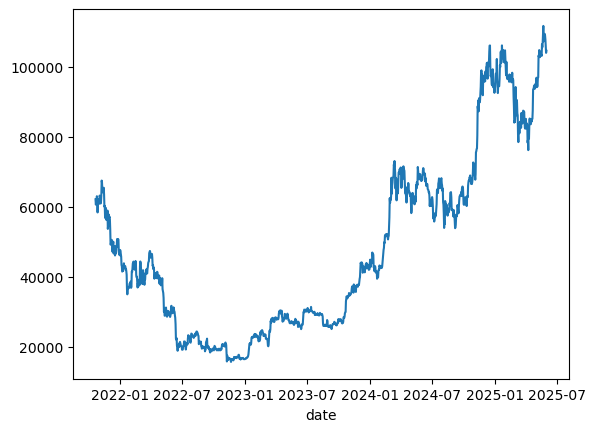

In [217]:
close_cols = [f'{ticker}_close' for ticker in ticker_list]
df_final[f'BTC-USD_close'].plot()

<Axes: xlabel='date'>

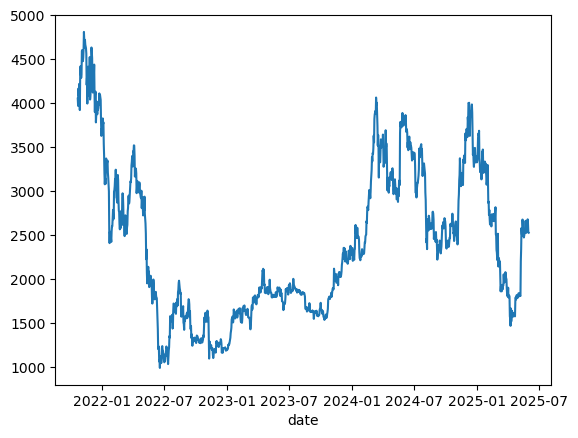

In [219]:
df_final[f'ETH-USD_close'].plot()

<Axes: xlabel='date'>

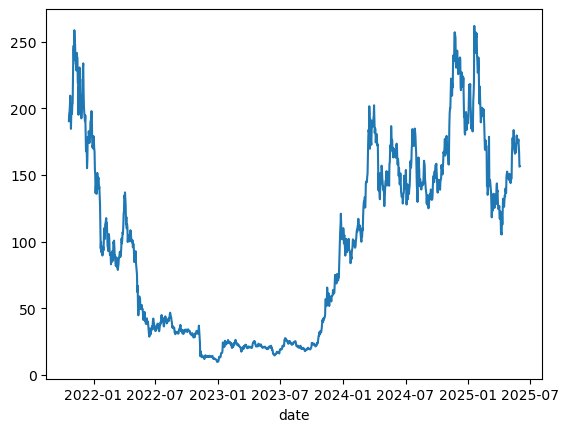

In [221]:
df_final[f'SOL-USD_close'].plot()

<Axes: xlabel='date'>

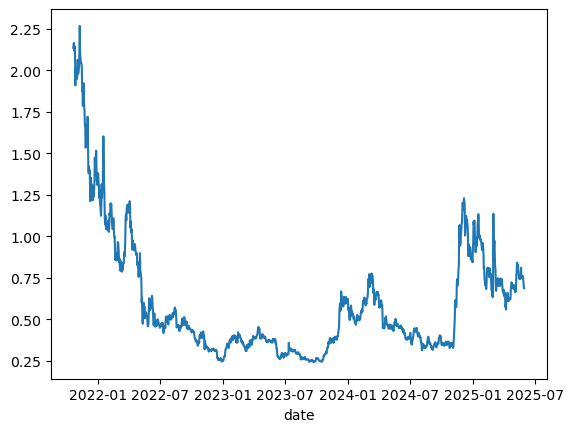

In [223]:
df_final[f'ADA-USD_close'].plot()

<Axes: xlabel='date'>

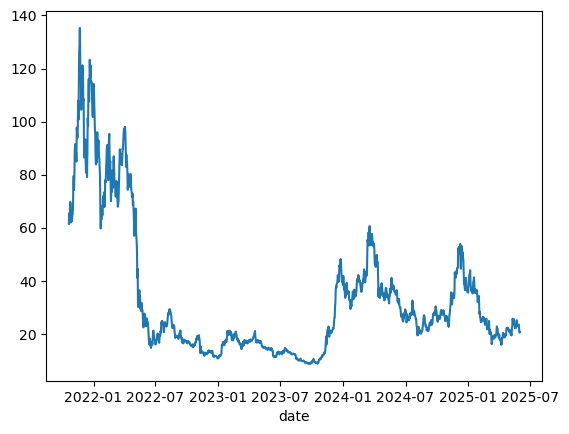

In [225]:
df_final[f'AVAX-USD_close'].plot()

In [268]:
## Production Config without Regime Filter
fast_mavg = 16
slow_mavg = 224
mavg_stepsize = 8
entry_window = 28
exit_window = 28
exit_gate = False
w_mavg = 0.6
w_donchian = 0.4
atr_multiplier = 2
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','ADA-USD','AVAX-USD']
df_final_prod_config = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
    tanh_activation_constant_dict=None, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [269]:
portfolio_perf_metrics_prod_config_wo_regime = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                      strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_wo_regime

{'annualized_return': -0.21136551875707688,
 'annualized_sharpe_ratio': -0.407941781505171,
 'calmar_ratio': -0.29752584341624766,
 'annualized_std_dev': 0.5756365575955833,
 'max_drawdown': -0.7104106195621135,
 'max_drawdown_duration': Timedelta('751 days 00:00:00'),
 'hit_rate': 0.31776913099870296,
 't_statistic': -0.43581056183210404,
 'p_value': 0.6630963272782915,
 'trade_count': 1178.0}

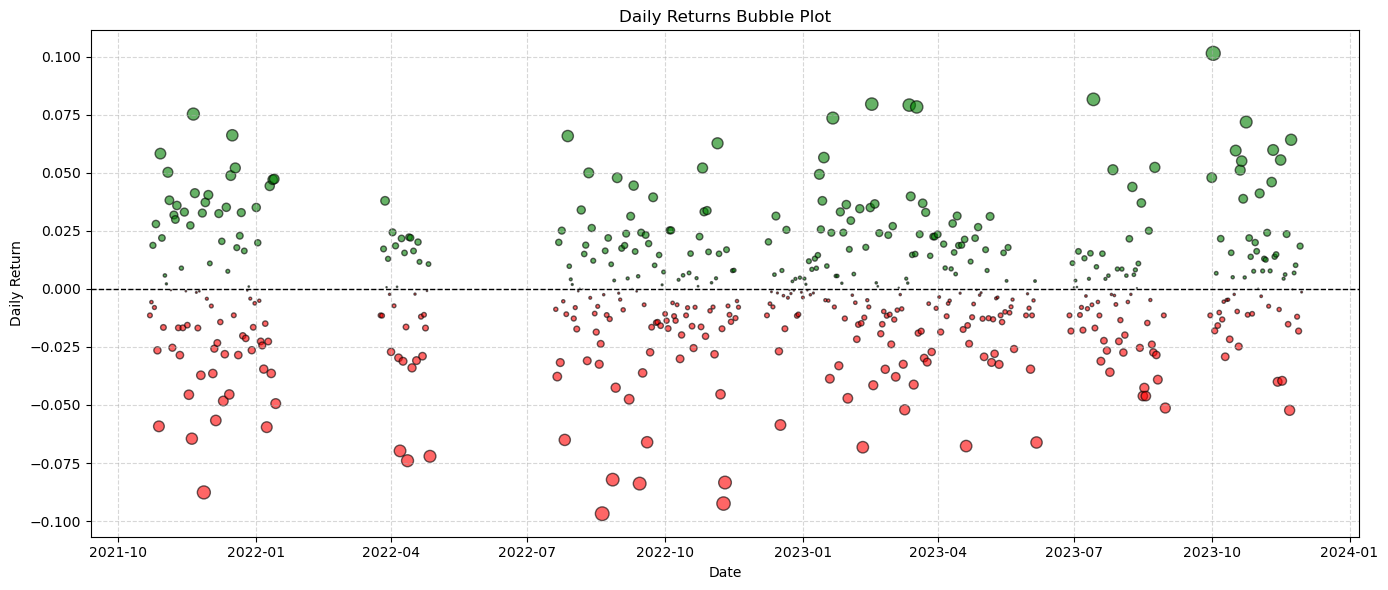

In [270]:
perf.plot_daily_returns_bubble(df_final_prod_config, return_col='portfolio_daily_pct_returns')

In [275]:
## Production Config without Regime Filter
fast_mavg = 16
slow_mavg = 224
mavg_stepsize = 8
entry_window = 28
exit_window = 28
exit_gate = False
w_mavg = 0.6
w_donchian = 0.4
atr_multiplier = 2
ticker_list = ['BTC-USD','SOL-USD','ADA-USD','AVAX-USD']
df_final_prod_config_wo_eth = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
    tanh_activation_constant_dict=None, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [276]:
portfolio_perf_metrics_prod_config_wo_regime_wo_eth = calculate_risk_and_performance_metrics(df_final_prod_config_wo_eth, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                      strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_wo_regime_wo_eth

{'annualized_return': -0.21368525372707559,
 'annualized_sharpe_ratio': -0.39997709903694206,
 'calmar_ratio': -0.2953931797855754,
 'annualized_std_dev': 0.5996750263175238,
 'max_drawdown': -0.7233926452946163,
 'max_drawdown_duration': Timedelta('738 days 00:00:00'),
 'hit_rate': 0.32684824902723736,
 't_statistic': -0.4268565379714517,
 'p_value': 0.6696031443120234,
 'trade_count': 902.0}

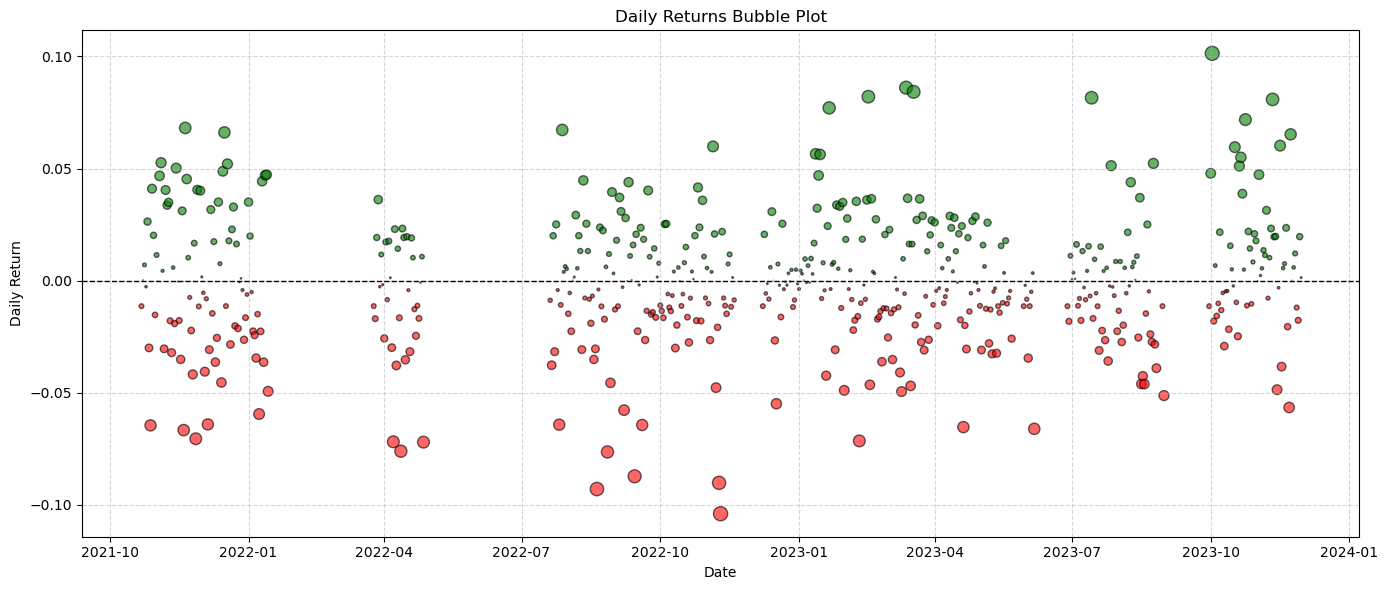

In [277]:
perf.plot_daily_returns_bubble(df_final_prod_config_wo_eth, return_col='portfolio_daily_pct_returns')

## Add Rolling R Squared Filter

### 📘 Pearson Correlation Coefficient Formula

The Pearson correlation coefficient \( r \) is given by:

$$
r = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}
         {\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
$$

Where:

- \( x_i, y_i \) are individual data points  
- \( \bar{x}, \bar{y} \) are the sample means of \( x \) and \( y \)  
- \( n \) is the number of observations


### 📘 Simplified Pearson Correlation Formula (Using Raw Sums)

The Pearson correlation coefficient \( r \) can also be written as:

$$
r = \frac{n \sum x_i y_i - \sum x_i \sum y_i}
         {\sqrt{n \sum x_i^2 - (\sum x_i)^2} \cdot \sqrt{n \sum y_i^2 - (\sum y_i)^2}}
$$

Where:

- \( x_i, y_i \) are the data values  
- \( n \) is the number of observations  
- \( \sum x_i y_i \) is the sum of the elementwise products  
- \( \sum x_i \), \( \sum y_i \) are the sums of each series  
- \( \sum x_i^2 \), \( \sum y_i^2 \) are the sums of squares


In [215]:
def calculate_rolling_r2(df, ticker, t_1_close_price_col, rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8):

    log_price_col = f'{ticker}_t_1_close_price_log'
    df[log_price_col] = np.log(df[t_1_close_price_col])
    
    ## Define the variables
    y = df[log_price_col]
    x = np.arange(len(y), dtype=float) # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(rolling_r2_window).sum()
    y_sum = y.rolling(rolling_r2_window).sum()
    x_sqr = pd.Series(x**2, y.index).rolling(rolling_r2_window).sum()
    y_sqr = (y**2).rolling(rolling_r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(rolling_r2_window).sum()

    ## Calculate the R squared
    n = rolling_r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
    df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above the upper limit are clipped to 1
    df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

    ## Smoothing the Rolling R Squared Signal
    df[f'{ticker}_rolling_r_sqr'] = df[f'{ticker}_rolling_r_sqr'].ewm(span=3, adjust=False).mean()

    ## Adding Convex Scaling to further reduce the signal during low trends and amplify during high trends
    # df[f'{ticker}_rolling_r_sqr'] = df[f'{ticker}_rolling_r_sqr'].clip(0, 1) ** 1.5

    return df

In [265]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                                                              exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight,
                                                                              rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8,
                                                                              moving_avg_type='exponential', price_or_returns_calc='price',
                                                                              long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=126)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f'{ticker}_t_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [t_1_close_col, f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())

    ## Calculate Rolling R Squared Signal
    df_trend = calculate_rolling_r2(df_trend, ticker=ticker, t_1_close_price_col=t_1_close_col, rolling_r2_window=rolling_r2_window,
                                   lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit)

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[final_weighted_additive_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[donchian_binary_signal_col]

    ## Apply Regime Filters
    # Introduce a 3-day confirmation period for Rolling R Squared Signal
    df_trend[f'{ticker}_r2_enable'] = (df_trend[f'{ticker}_rolling_r_sqr'] > lower_r_sqr_limit).rolling(5).min().fillna(0.0)
    df_trend[final_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[f'{ticker}_rolling_r_sqr'] * df_trend[f'{ticker}_r2_enable']
    
    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[final_signal_col]), df_trend[final_signal_col])

    return df_trend

def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                                               exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight, 
                                                               rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8,
                                                               long_only=False, price_or_returns_calc='price',
                                                               use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        rolling_r2_enable_col = f'{ticker}_rolling_r_sqr'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        # lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        # upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col,
                      rolling_r2_col, rolling_r2_enable_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [253]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, ma_crossover_signal_weight,
                                                                                   donchian_signal_weight, entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                                   rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, long_only=False,
                                                                                   initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                                   rolling_atr_window=20, atr_multiplier=0.5,
                                                                                   transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                                   use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30', 
                                                                                   rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                                   annual_trading_days=365, use_specific_start_date=False,
                                                                                   signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                          slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                                          exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                                          donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                                          rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                                                                          long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, initial_capital, rolling_cov_window,
                                                                   rolling_atr_window, atr_multiplier, cash_buffer_percentage, annualized_target_volatility,
                                                                   transaction_cost_est, passive_trade_rate, notional_threshold_pct, cooldown_counter_threshold)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

## Walk Forward Analysis for Rolling R Squared

In [62]:
import itertools

def generate_rolling_r_sqr_params():
    parameter_grid = {
        "rolling_r2_window": [20, 30, 50, 80],
        "upper_r_sqr_limit": [0.60, 0.75, 0.90],
        "lower_r_sqr_limit": [0.10, 0.20, 0.30]
    }
    keys, values = zip(*parameter_grid.items())
    for prod in itertools.product(*values):
        yield dict(zip(keys, prod))

In [64]:
def run_walk_forward_rolling_r_sqr(start_date, end_date, ticker_list, mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'rolling_r2_window', 'lower_r_sqr_limit', 'upper_r_sqr_limit', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count', 'ticker_sharpe_mean', 'ticker_sharpe_std', 'turnover', 'rolling_r2_score']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)

    ## Defining Strategy Parameters
    mavg_strategy_params = mavg_strategy
    donchian_strategy_params = donchian_strategy
    
    ## Moving Average Ribbon Params
    fast_mavg = int(mavg_strategy_params.split('_')[0][1:])
    slow_mavg = int(mavg_strategy_params.split('_')[1][1:])
    mavg_stepsize = int(mavg_strategy_params.split('_')[2][1:])
    
    ## Donchian Channel Params
    entry_window = int(donchian_strategy_params.split('_')[0][2:])
    exit_window = int(donchian_strategy_params.split('_')[1][2:])
    exit_gate = ast.literal_eval(donchian_strategy_params.split('_')[2][1:])

    ## Strategy Weights
    donchian_signal_weight = 1 - ma_crossover_signal_weight

    ## Ticker Sharpe Columns
    ticker_sharpe_cols = [f'{ticker}_annualized_sharpe_ratio' for ticker in ticker_list]

    ## Rolling R Squares Score Parameters
    std_lam = 0.2
    turnover_gam = 0.001
    
    IS_LEN = pd.DateOffset(years=2)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date:
            break
    
        for params in generate_rolling_r_sqr_params():
            print(params)
            rolling_r2_window = params['rolling_r2_window']
            lower_r_sqr_limit = params['lower_r_sqr_limit']
            upper_r_sqr_limit = params['upper_r_sqr_limit']
            
            print(rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit)

            ## In Sample Dataframe
            print('Pulling In Sample Data!!')
            df_is = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
                start_date=start_date_is, end_date=end_date_is, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
                use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, long_only=long_only,
                initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
                transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                annualized_target_volatility=annualized_target_volatility,
                annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
            print('Calculating In Sample Asset Returns!!')
            df_is = calculate_asset_level_returns(df_is, end_date_is, ticker_list)

            ## In Sample Performance Metrics
            print('Getting In Sample Performance Metrics!!')
            row_parameters_is = {
                'sampling_category': 'in_sample',
                'start_date': start_date_is,
                'end_date': end_date_is,
                'rolling_r2_window': rolling_r2_window,
                'lower_r_sqr_limit': lower_r_sqr_limit,
                'upper_r_sqr_limit': upper_r_sqr_limit
            }
            portfolio_perf_metrics_is = calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                               passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

            print('Getting In Sample Asset Performance!!')
            for ticker in ticker_list:
                ## In Sample
                ticker_perf_metrics_is = perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                     annual_trading_days=365, include_transaction_costs_and_fees=False)
                ticker_perf_metrics_is = {key: ticker_perf_metrics_is[key] for key in ticker_perf_cols}
                ticker_perf_metrics_is = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_is.items()}
                portfolio_perf_metrics_is.update(ticker_perf_metrics_is)
            
            row_parameters_is.update(portfolio_perf_metrics_is)
            ticker_sharpe_values = np.array([portfolio_perf_metrics_is.get(col, np.nan) for col in ticker_sharpe_cols], dtype=float)
            turnover = float(portfolio_perf_metrics_is.get('trade_count', 0.0))
            row_parameters_is.update({
                'ticker_sharpe_mean': float(np.nanmean(ticker_sharpe_values)),
                'ticker_sharpe_std':  float(np.nanstd(ticker_sharpe_values)),
                'turnover':    turnover,
            })
            row_parameters_is['rolling_r2_score'] = (
                row_parameters_is['ticker_sharpe_mean'] -
                std_lam * row_parameters_is['ticker_sharpe_std'] -
                turnover_gam * row_parameters_is['turnover']
            )

            ## Assign in sample metrics to performance dataframe
            df_performance.loc[df_performance.shape[0]] = row_parameters_is

        ## Get Moving Average and Donchian Channel Weights with best performing in-sample Sharpe Ratio
        in_sample_cond = (df_performance['sampling_category'] == 'in_sample')
        date_cond = (df_performance['start_date'] == start_date_is) & (df_performance['end_date'] == end_date_is)
        walk_forward_run_cond = in_sample_cond & date_cond

        ## Get Performing Parameters in the In-Sample period based on the Rolling R2 score
        best_rolling_r2_window = df_performance[walk_forward_run_cond].sort_values('rolling_r2_score', ascending=False)['rolling_r2_window'].iloc[0]
        best_lower_r_sqr_limit = df_performance[walk_forward_run_cond].sort_values('rolling_r2_score', ascending=False)['lower_r_sqr_limit'].iloc[0]
        best_upper_r_sqr_limit = df_performance[walk_forward_run_cond].sort_values('rolling_r2_score', ascending=False)['upper_r_sqr_limit'].iloc[0]
        
        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        df_os = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
            start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
            use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            rolling_r2_window=best_rolling_r2_window, lower_r_sqr_limit=best_lower_r_sqr_limit, upper_r_sqr_limit=best_upper_r_sqr_limit, long_only=long_only,
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
        print('Calculating Out of Sample Asset Returns!!')
        df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
        
        ## Out of Sample Performance Metrics
        print('Pulling Out of Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_os,
            'end_date': end_date_os,
            'rolling_r2_window': best_rolling_r2_window,
            'lower_r_sqr_limit': best_lower_r_sqr_limit,
            'upper_r_sqr_limit': best_upper_r_sqr_limit
        }
        portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                 annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [66]:
start_date = pd.Timestamp('2021-06-01').date()
end_date = pd.Timestamp('2025-06-30').date()
perf_cols = ['sampling_category', 'start_date', 'end_date', 'fast_mavg', 'slow_mavg', 'mavg_stepsize', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
             'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
ticker_perf_cols = ['annualized_return','annualized_sharpe_ratio','annualized_std_dev','max_drawdown']
perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])

df_performance = pd.DataFrame(columns=perf_cols)

IS_LEN = pd.DateOffset(years=2)
OS_LEN = pd.DateOffset(months=6)
start_date_is = start_date
while True:
    end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
    start_date_os = (end_date_is + pd.Timedelta(days=1))
    end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
    print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
    if end_date_os > end_date:
        break
    start_date_is = (start_date_is + OS_LEN).date()

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
In Sample Start: 2022-06-01, In Sample End: 2024-05-31, Out of Sample Start: 2024-06-01, Out of Sample End: 2024-11-30
In Sample Start: 2022-12-01, In Sample End: 2024-11-30, Out of Sample Start: 2024-12-01, Out of Sample End: 2025-05-31
In Sample Start: 2023-06-01, In Sample End: 2025-05-31, Out of Sample Start: 2025-06-01, Out of Sample End: 2025-11-30


In [68]:
ticker_list

['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']

In [432]:
df_rolling_r2_performance = run_walk_forward_rolling_r_sqr(start_date, end_date, ticker_list, mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)

In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
{'rolling_r2_window': 20, 'upper_r_sqr_limit': 0.6, 'lower_r_sqr_limit': 0.1}
20 0.1 0.6
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getting In Sample Performance Metrics!!
Getting In Sample Asset Performance!!
{'rolling_r2_window': 20, 'upper_r_sqr_limit': 0.6, 'lower_r_sqr_limit': 0.2}
20 0.2 0.6
Pulling In Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!
Getti

In [434]:
df_rolling_r2_performance.groupby(['sampling_category']).size()

sampling_category
in_sample     144
out_sample      4
dtype: int64

In [438]:
df_rolling_r2_performance[df_rolling_r2_performance.start_date == pd.Timestamp('2021-06-01').date()].sort_values('rolling_r2_score', ascending=False)

sampling_category  start_date    end_date  rolling_r2_window  \
20         in_sample  2021-06-01  2023-05-31                 50   
35         in_sample  2021-06-01  2023-05-31                 80   
26         in_sample  2021-06-01  2023-05-31                 50   
23         in_sample  2021-06-01  2023-05-31                 50   
32         in_sample  2021-06-01  2023-05-31                 80   
19         in_sample  2021-06-01  2023-05-31                 50   
29         in_sample  2021-06-01  2023-05-31                 80   
25         in_sample  2021-06-01  2023-05-31                 50   
22         in_sample  2021-06-01  2023-05-31                 50   
17         in_sample  2021-06-01  2023-05-31                 30   
14         in_sample  2021-06-01  2023-05-31                 30   
11         in_sample  2021-06-01  2023-05-31                 30   
18         in_sample  2021-06-01  2023-05-31                 50   
31         in_sample  2021-06-01  2023-05-31                 80   
34         in_sample  2021-06-01  2023-05-31                 80   
24         in_sample  2021-06-01  2023-05-31                 50   
21         in_sample  2021-06-01  2023-05-31                 50   
28         in_sample  2021-06-01  2023-05-31                 80   
10         in_sample  2021-06-01  2023-05-31                 30   
16         in_sample  2021-06-01  2023-05-31                 30   
13         in_sample  2021-06-01  2023-05-31                 30   
12         in_sample  2021-06-01  2023-05-31                 30   
9          in_sample  2021-06-01  2023-05-31                 30   
15         in_sample  2021-06-01  2023-05-31                 30   
2          in_sample  2021-06-01  2023-05-31                 20   
5          in_sample  2021-06-01  2023-05-31                 20   
8          in_sample  2021-06-01  2023-05-31                 20   
33         in_sample  2021-06-01  2023-05-31                 80   
30         in_sample  2021-06-01  2023-05-31                 80   
1          in_sample  2021-06-01  2023-05-31                 20   
4          in_sample  2021-06-01  2023-05-31                 20   
7          in_sample  2021-06-01  2023-05-31                 20   
27         in_sample  2021-06-01  2023-05-31                 80   
0          in_sample  2021-06-01  2023-05-31                 20   
6          in_sample  2021-06-01  2023-05-31                 20   
3          in_sample  2021-06-01  2023-05-31                 20   

    lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
20                0.3               0.60          -0.319414   
35                0.3               0.90          -0.359584   
26                0.3               0.90          -0.330111   
23                0.3               0.75          -0.330154   
32                0.3               0.75          -0.360473   
19                0.2               0.60          -0.287293   
29                0.3               0.60          -0.377160   
25                0.2               0.90          -0.297466   
22                0.2               0.75          -0.296624   
17                0.3               0.90          -0.435917   
14                0.3               0.75          -0.436509   
11                0.3               0.60          -0.445071   
18                0.1               0.60          -0.281521   
31                0.2               0.75          -0.423937   
34                0.2               0.90          -0.423794   
24                0.1               0.90          -0.288652   
21                0.1               0.75          -0.287793   
28                0.2               0.60          -0.434714   
10                0.2               0.60          -0.507419   
16                0.2               0.90          -0.501771   
13                0.2               0.75          -0.504365   
12                0.1               0.75          -0.488613   
9                 0.1               0.60          -0.491504   
15         

In [448]:
df_rolling_r2_performance[df_rolling_r2_performance.sampling_category == 'out_sample']

sampling_category  start_date    end_date  rolling_r2_window  \
36         out_sample  2023-06-01  2023-11-30                 50   
73         out_sample  2023-12-01  2024-05-31                 80   
110        out_sample  2024-06-01  2024-11-30                 50   
147        out_sample  2024-12-01  2025-05-31                 20   

     lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
36                 0.3                0.6           1.504514   
73                 0.3                0.9           0.027610   
110                0.2                0.6           0.125721   
147                0.3                0.6          -0.270645   

     annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
36                  2.274751      9.596882            0.613281     -0.156771   
73                  0.134723      0.112663            0.610820     -0.245066   
110                 0.380623      0.338858            0.679855     -0.371014   
147                -1.717983     -1.712155            0.354957     -0.158073   

    max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
36               120 days  0.265432     1.592783  0.113170        179.0   
73                78 days  0.209877     0.174578  0.861631        157.0   
110              153 days  0.277778     0.321699  0.748098        140.0   
147              160 days  0.136646    -0.979371  0.328875        127.0   

     ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
36                  NaN                NaN       NaN               NaN   
73                  NaN                NaN       NaN               NaN   
110                 NaN                NaN       NaN               NaN   
147                 NaN                NaN       NaN               NaN   

     BTC-USD_annualized_return  ETH-USD_annualized_return  \
36                    0.233417                   0.051649   
73                    0.134995                   0.318790   
110                   0.585337                  -0.086401   
147                   0.085680                   0.087889   

     SOL-USD_annualized_return  ADA-USD_annualized_return  \
36                    1.134263                   0.122248   
73                   -0.113873                  -0.028545   
110                  -0.101880                   0.131519   
147                  -0.107194                  -0.074290   

     AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
36                     0.114216                         1.558290   
73                    -0.048303                         0.544537   
110                    0.011574                         2.777722   
147                   -0.041840                         0.344873   

     ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
36                          0.055511                         2.426618   
73                          1.567683                        -1.742801   
110                        -1.499509                        -0.393273   
147                         0.819480                        -3.129258   

     ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
36                          0.983933                          0.921696   
73                         -4.212324                         -3.133687   
110                         1.447240                         -0.037628   
147                        -4.937265                         -3.668880   

     BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
36                     0.184272                    0.117879   
73                     0.274306                    0.254519   
110                    0.260927                    0.214735   
147                    0.207352                    0.113807   

     SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
36                     0.449520                    0.132773   
73                     0.161534                    0.053669   

In [361]:
df_rolling_r2_performance.head(50)

sampling_category  start_date    end_date  rolling_r2_window  \
0          in_sample  2021-06-01  2023-05-31                 20   
1          in_sample  2021-06-01  2023-05-31                 20   
2          in_sample  2021-06-01  2023-05-31                 20   
3          in_sample  2021-06-01  2023-05-31                 20   
4          in_sample  2021-06-01  2023-05-31                 20   
5          in_sample  2021-06-01  2023-05-31                 20   
6          in_sample  2021-06-01  2023-05-31                 20   
7          in_sample  2021-06-01  2023-05-31                 20   
8          in_sample  2021-06-01  2023-05-31                 20   
9          in_sample  2021-06-01  2023-05-31                 30   
10         in_sample  2021-06-01  2023-05-31                 30   
11         in_sample  2021-06-01  2023-05-31                 30   
12         in_sample  2021-06-01  2023-05-31                 30   
13         in_sample  2021-06-01  2023-05-31                 30   
14         in_sample  2021-06-01  2023-05-31                 30   
15         in_sample  2021-06-01  2023-05-31                 30   
16         in_sample  2021-06-01  2023-05-31                 30   
17         in_sample  2021-06-01  2023-05-31                 30   
18         in_sample  2021-06-01  2023-05-31                 50   
19         in_sample  2021-06-01  2023-05-31                 50   
20         in_sample  2021-06-01  2023-05-31                 50   
21         in_sample  2021-06-01  2023-05-31                 50   
22         in_sample  2021-06-01  2023-05-31                 50   
23         in_sample  2021-06-01  2023-05-31                 50   
24         in_sample  2021-06-01  2023-05-31                 50   
25         in_sample  2021-06-01  2023-05-31                 50   
26         in_sample  2021-06-01  2023-05-31                 50   
27         in_sample  2021-06-01  2023-05-31                 80   
28         in_sample  2021-06-01  2023-05-31                 80   
29         in_sample  2021-06-01  2023-05-31                 80   
30         in_sample  2021-06-01  2023-05-31                 80   
31         in_sample  2021-06-01  2023-05-31                 80   
32         in_sample  2021-06-01  2023-05-31                 80   
33         in_sample  2021-06-01  2023-05-31                 80   
34         in_sample  2021-06-01  2023-05-31                 80   
35         in_sample  2021-06-01  2023-05-31                 80   
36        out_sample  2023-06-01  2023-11-30                 50   
37         in_sample  2021-12-01  2023-11-30                 20   
38         in_sample  2021-12-01  2023-11-30                 20   
39         in_sample  2021-12-01  2023-11-30                 20   
40         in_sample  2021-12-01  2023-11-30                 20   
41         in_sample  2021-12-01  2023-11-30                 20   
42         in_sample  2021-12-01  2023-11-30                 20   
43         in_sample  2021-12-01  2023-11-30                 20   
44         in_sample  2021-12-01  2023-11-30                 20   
45         in_sample  2021-12-01  2023-11-30                 20   
46         in_sample  2021-12-01  2023-11-30                 30   
47         in_sample  2021-12-01  2023-11-30                 30   
48         in_sample  2021-12-01  2023-11-30                 30   
49         in_sample  2021-12-01  2023-11-30                 30   

    lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.60                0.1          -0.537247   
1                0.75                0.1          -0.492586   
2                0.90                0.1          -0.413577   
3                0.60                0.2          -0.540905   
4                0.75                0.2          -0.492856   
5                0.90                0.2          -0.413064   
6                0.60                0.3          -0.544604   
7                0.75                0.3          -0.493525   
8                0

### Analyze Walk Forward Results from Rolling R Squared

In [450]:
df_rolling_r2_performance.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Performance-2021-06-01-2025-05-31.pickle')

In [70]:
df_rolling_r2_performance = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Performance-2021-06-01-2025-05-31.pickle')

In [72]:
df_rolling_r2_performance_is = df_rolling_r2_performance[df_rolling_r2_performance.sampling_category == 'in_sample'].reset_index(drop=True)
df_rolling_r2_performance_os = df_rolling_r2_performance[df_rolling_r2_performance.sampling_category == 'out_sample'].reset_index(drop=True)

In [74]:
## Best In Sample Perforamance by Fold
agg_dict = {'rolling_r2_score':'max'}
df_best_score_per_fold_is = df_rolling_r2_performance_is.groupby(['start_date','end_date']).agg(agg_dict).reset_index()
perf_cols = ['rolling_r2_score','rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','annualized_sharpe_ratio','annualized_std_dev','max_drawdown','trade_count']
df_best_score_per_fold_is = pd.merge(df_best_score_per_fold_is, df_rolling_r2_performance_is[perf_cols], on='rolling_r2_score',how='inner')
df_best_score_per_fold_is

start_date    end_date  rolling_r2_score  rolling_r2_window  \
0  2021-06-01  2023-05-31         -1.147170                 50   
1  2021-12-01  2023-11-30         -1.024543                 80   
2  2022-06-01  2024-05-31         -0.508183                 50   
3  2022-12-01  2024-11-30         -0.065607                 20   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_sharpe_ratio  \
0                0.3                0.6                -0.783063   
1                0.3                0.9                -0.670564   
2                0.2                0.6                 0.641641   
3                0.3                0.6                 0.800504   

   annualized_std_dev  max_drawdown  trade_count  
0            0.613339     -0.642412        688.0  
1            0.558191     -0.591525        678.0  
2            0.591739     -0.438708        901.0  
3            0.594962     -0.403752        840.0

In [76]:
df_rolling_r2_performance_os

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-06-01  2023-11-30                 50   
1        out_sample  2023-12-01  2024-05-31                 80   
2        out_sample  2024-06-01  2024-11-30                 50   
3        out_sample  2024-12-01  2025-05-31                 20   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.3                0.6           1.504514   
1                0.3                0.9           0.027610   
2                0.2                0.6           0.125721   
3                0.3                0.6          -0.270645   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 2.274751      9.596882            0.613281     -0.156771   
1                 0.134723      0.112663            0.610820     -0.245066   
2                 0.380623      0.338858            0.679855     -0.371014   
3                -1.717983     -1.712155            0.354957     -0.158073   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              120 days  0.265432     1.592783  0.113170        179.0   
1               78 days  0.209877     0.174578  0.861631        157.0   
2              153 days  0.277778     0.321699  0.748098        140.0   
3              160 days  0.136646    -0.979371  0.328875        127.0   

   ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                 NaN                NaN       NaN               NaN   
1                 NaN                NaN       NaN               NaN   
2                 NaN                NaN       NaN               NaN   
3                 NaN                NaN       NaN               NaN   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.233417                   0.051649   
1                   0.134995                   0.318790   
2                   0.585337                  -0.086401   
3                   0.085680                   0.087889   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   1.134263                   0.122248   
1                  -0.113873                  -0.028545   
2                  -0.101880                   0.131519   
3                  -0.107194                  -0.074290   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.114216                         1.558290   
1                   -0.048303                         0.544537   
2                    0.011574                         2.777722   
3                   -0.041840                         0.344873   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                         0.055511                         2.426618   
1                         1.567683                        -1.742801   
2                        -1.499509                        -0.393273   
3                         0.819480                        -3.129258   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         0.983933                          0.921696   
1                        -4.212324                         -3.133687   
2                         1.447240                         -0.037628   
3                        -4.937265                         -3.668880   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.184272                    0.117879   
1                    0.274306                    0.254519   
2                    0.260927                    0.214735   
3                    0.207352                    0.113807   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.449520                    0.132773   
1                    0.161534                    0.053669   
2                    0.468675                    0.155439   
3                    0.100809                    0.0

In [78]:
## Overall Out of Sample Stats
df_rolling_r2_performance_os.groupby(['rolling_r2_window']).agg({'annualized_return':['mean','median','std'],
                                                                 'annualized_sharpe_ratio':['mean','median','std'],
                                                                 'calmar_ratio':['mean','median','std'],
                                                                 'annualized_std_dev':['mean','median','std'],
                                                                 'max_drawdown':['mean','median','std']})

annualized_return                      \
                               mean    median       std   
rolling_r2_window                                         
20                        -0.270645 -0.270645       NaN   
50                         0.815118  0.815118  0.974954   
80                         0.027610  0.027610       NaN   

                  annualized_sharpe_ratio                     calmar_ratio  \
                                     mean    median       std         mean   
rolling_r2_window                                                            
20                              -1.717983 -1.717983       NaN    -1.712155   
50                               1.327687  1.327687  1.339351     4.967870   
80                               0.134723  0.134723       NaN     0.112663   

                                      annualized_std_dev                      \
                     median       std               mean    median       std   
rolling_r2_window                                                              
20                -1.712155       NaN           0.354957  0.354957       NaN   
50                 4.967870  6.546412           0.646568  0.646568  0.047075   
80                 0.112663       NaN           0.610820  0.610820       NaN   

                  max_drawdown                      
                          mean    median       std  
rolling_r2_window                                   
20                   -0.158073 -0.158073       NaN  
50                   -0.263893 -0.263893  0.151493  
80                   -0.245066 -0.245066       NaN

In [80]:
df_rolling_r2_performance_is.groupby(['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit']
                                    ).agg({'annualized_sharpe_ratio':'mean', 'rolling_r2_score':'mean'}
                                         ).reset_index().sort_values('rolling_r2_score', ascending=False)

rolling_r2_window  lower_r_sqr_limit  upper_r_sqr_limit  \
24                 50                0.3               0.60   
25                 50                0.3               0.75   
26                 50                0.3               0.90   
21                 50                0.2               0.60   
22                 50                0.2               0.75   
23                 50                0.2               0.90   
35                 80                0.3               0.90   
34                 80                0.3               0.75   
33                 80                0.3               0.60   
15                 30                0.3               0.60   
17                 30                0.3               0.90   
16                 30                0.3               0.75   
32                 80                0.2               0.90   
31                 80                0.2               0.75   
30                 80                0.2               0.60   
6                  20                0.3               0.60   
18                 50                0.1               0.60   
20                 50                0.1               0.90   
19                 50                0.1               0.75   
7                  20                0.3               0.75   
8                  20                0.3               0.90   
12                 30                0.2               0.60   
14                 30                0.2               0.90   
13                 30                0.2               0.75   
10                 30                0.1               0.75   
9                  30                0.1               0.60   
11                 30                0.1               0.90   
3                  20                0.2               0.60   
29                 80                0.1               0.90   
28                 80                0.1               0.75   
4                  20                0.2               0.75   
27                 80                0.1               0.60   
5                  20                0.2               0.90   
0                  20                0.1               0.60   
1                  20                0.1               0.75   
2                  20                0.1               0.90   

    annualized_sharpe_ratio  rolling_r2_score  
24                 0.069922         -0.743621  
25                 0.050397         -0.775912  
26                 0.053967         -0.776624  
21                 0.119273         -0.807615  
22                 0.104864         -0.827652  
23                 0.103802         -0.831604  
35                -0.227551         -0.839078  
34                -0.228672         -0.843426  
33                -0.255929         -0.862273  
15                -0.241531         -0.872191  
17                -0.192333         -0.872530  
16                -0.201337         -0.878906  
32                -0.148912         -0.934874  
31                -0.150903         -0.941066  
30                -0.168551         -0.951609  
6                 -0.617789         -0.963314  
18                 0.019994         -0.971065  
20                 0.004972         -0.991747  
19                 0.004981         -0.993431  
7                 -0.605552         -0.999265  
8                 -0.605684         -1.010663  
12                -0.453498         -1.022765  
14                -0.411153         -1.024971  
13                -0.422100         -1.028574  
10                -0.396477         -1.033475  
9                 -0.416809         -1.033859  
11                -0.391312         -1.036255  
3                 -0.521171         -1.086219  
29                -0.211983         -1.101800  
28                -0.214639         -1.105528  
4                 -0.516923         -1.106352  
27                -0.225802         -1.114252  
5                 -0.523201         -1.121906  
0                 -0.463725         -1.1

In [456]:
df_rolling_r2_performance_os.head()

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-06-01  2023-11-30                 50   
1        out_sample  2023-12-01  2024-05-31                 80   
2        out_sample  2024-06-01  2024-11-30                 50   
3        out_sample  2024-12-01  2025-05-31                 20   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.3                0.6           1.504514   
1                0.3                0.9           0.027610   
2                0.2                0.6           0.125721   
3                0.3                0.6          -0.270645   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 2.274751      9.596882            0.613281     -0.156771   
1                 0.134723      0.112663            0.610820     -0.245066   
2                 0.380623      0.338858            0.679855     -0.371014   
3                -1.717983     -1.712155            0.354957     -0.158073   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              120 days  0.265432     1.592783  0.113170        179.0   
1               78 days  0.209877     0.174578  0.861631        157.0   
2              153 days  0.277778     0.321699  0.748098        140.0   
3              160 days  0.136646    -0.979371  0.328875        127.0   

   ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                 NaN                NaN       NaN               NaN   
1                 NaN                NaN       NaN               NaN   
2                 NaN                NaN       NaN               NaN   
3                 NaN                NaN       NaN               NaN   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.233417                   0.051649   
1                   0.134995                   0.318790   
2                   0.585337                  -0.086401   
3                   0.085680                   0.087889   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   1.134263                   0.122248   
1                  -0.113873                  -0.028545   
2                  -0.101880                   0.131519   
3                  -0.107194                  -0.074290   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.114216                         1.558290   
1                   -0.048303                         0.544537   
2                    0.011574                         2.777722   
3                   -0.041840                         0.344873   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                         0.055511                         2.426618   
1                         1.567683                        -1.742801   
2                        -1.499509                        -0.393273   
3                         0.819480                        -3.129258   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         0.983933                          0.921696   
1                        -4.212324                         -3.133687   
2                         1.447240                         -0.037628   
3                        -4.937265                         -3.668880   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.184272                    0.117879   
1                    0.274306                    0.254519   
2                    0.260927                    0.214735   
3                    0.207352                    0.113807   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.449520                    0.132773   
1                    0.161534                    0.053669   
2                    0.468675                    0.155439   
3                    0.100809                    0.0

## Generate Rolling R Squared Out of Sample Performance for Locked Rolling R Squared Config

In [526]:
# import itertools

# def generate_locked_rolling_r_sqr_params():
#     parameter_grid = {
#         "rolling_r2_window": [50, 80],
#         "upper_r_sqr_limit": [0.60, 0.90],
#         "lower_r_sqr_limit": [0.20, 0.30]
#     }
#     keys, values = zip(*parameter_grid.items())
#     for prod in itertools.product(*values):
#         yield dict(zip(keys, prod))

In [82]:
def run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit, mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6):

    start_date = pd.Timestamp(start_date).date()
    end_date = pd.Timestamp(end_date).date()
    perf_cols = ['sampling_category', 'start_date', 'end_date', 'rolling_r2_window', 'lower_r_sqr_limit', 'upper_r_sqr_limit', 'annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio',
                 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count', 'ticker_sharpe_mean', 'ticker_sharpe_std', 'turnover', 'rolling_r2_score']
    ticker_perf_cols = ['annualized_return', 'annualized_sharpe_ratio', 'annualized_std_dev', 'max_drawdown']
    perf_cols.extend([f'{ticker}_{col}' for col in ticker_perf_cols for ticker in ticker_list])
    
    df_performance = pd.DataFrame(columns=perf_cols)

    ## Defining Strategy Parameters
    mavg_strategy_params = mavg_strategy
    donchian_strategy_params = donchian_strategy
    
    ## Moving Average Ribbon Params
    fast_mavg = int(mavg_strategy_params.split('_')[0][1:])
    slow_mavg = int(mavg_strategy_params.split('_')[1][1:])
    mavg_stepsize = int(mavg_strategy_params.split('_')[2][1:])
    
    ## Donchian Channel Params
    entry_window = int(donchian_strategy_params.split('_')[0][2:])
    exit_window = int(donchian_strategy_params.split('_')[1][2:])
    exit_gate = ast.literal_eval(donchian_strategy_params.split('_')[2][1:])

    ## Strategy Weights
    donchian_signal_weight = 1 - ma_crossover_signal_weight

    ## Ticker Sharpe Columns
    ticker_sharpe_cols = [f'{ticker}_annualized_sharpe_ratio' for ticker in ticker_list]

    ## Rolling R Squares Score Parameters
    std_lam = 0.2
    turnover_gam = 0.001

    ## Print Params
    print(rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit)
    
    IS_LEN = pd.DateOffset(years=2)
    OS_LEN = pd.DateOffset(months=6)
    start_date_is = start_date
    while True:
        end_date_is = (start_date_is + IS_LEN - pd.Timedelta(days=1)).date()
        start_date_os = (end_date_is + pd.Timedelta(days=1))
        end_date_os = (start_date_os + OS_LEN - pd.Timedelta(days=1)).date()
        print(f'In Sample Start: {start_date_is}, In Sample End: {end_date_is}, Out of Sample Start: {start_date_os}, Out of Sample End: {end_date_os}')
        if end_date_os > end_date:
            break
        
        ## Out of Sample Dataframe
        print('Pulling Out of Sample Data!!')
        df_os = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
            start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
            use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, long_only=long_only,
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)
        print('Calculating Out of Sample Asset Returns!!')
        df_os = calculate_asset_level_returns(df_os, end_date_os, ticker_list)
        
        ## Out of Sample Performance Metrics
        print('Pulling Out of Sample Performance Metrics!!')
        row_parameters_os = {
            'sampling_category': 'out_sample',
            'start_date': start_date_os,
            'end_date': end_date_os,
            'rolling_r2_window': rolling_r2_window,
            'lower_r_sqr_limit': lower_r_sqr_limit,
            'upper_r_sqr_limit': upper_r_sqr_limit
        }
        portfolio_perf_metrics_os = calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False,
                                                                           passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)

        print('Getting Out of Sample Asset Performance!!')
        for ticker in ticker_list:
            ## Out of Sample
            ticker_perf_metrics_os = perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col=f'{ticker}_daily_pct_returns',
                                                                                 strategy_trade_count_col=f'{ticker}_position_count', 
                                                                                 annual_trading_days=365, include_transaction_costs_and_fees=False)
            ticker_perf_metrics_os = {key: ticker_perf_metrics_os[key] for key in ticker_perf_cols}
            ticker_perf_metrics_os = {f'{ticker}_{key}': value for key, value in ticker_perf_metrics_os.items()}
            portfolio_perf_metrics_os.update(ticker_perf_metrics_os)
        
        row_parameters_os.update(portfolio_perf_metrics_os)

        ## Assign out of sample metrics to performance dataframe
        df_performance.loc[df_performance.shape[0]] = row_parameters_os

        start_date_is = (start_date_is + OS_LEN).date()
        
    return df_performance

In [532]:
## Config 1:
## Rolling R2 Window: 50
rolling_r2_window = 50
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.60
upper_r_sqr_limit = 0.60

df_rolling_r2_locked_params_performance_1 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                            mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)

50 0.3 0.6
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [534]:
## Config 2:
## Rolling R2 Window: 50
rolling_r2_window = 50
## Lower R Sqr Limit: 0.20
lower_r_sqr_limit = 0.20
## Upper R Sqr Limit: 0.60
upper_r_sqr_limit = 0.60

df_rolling_r2_locked_params_performance_2 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                            mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)

50 0.2 0.6
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [535]:
## Config 3:
## Rolling R2 Window: 80
rolling_r2_window = 50
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.60
upper_r_sqr_limit = 0.60

df_rolling_r2_locked_params_performance_3 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                            mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)

50 0.3 0.6
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [536]:
## Config 4:
## Rolling R2 Window: 80
rolling_r2_window = 80
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.90
upper_r_sqr_limit = 0.90

df_rolling_r2_locked_params_performance_4 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                            mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)

80 0.3 0.9
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [540]:
df_rolling_r2_locked_params_performance_1.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance-2021-06-01-2025-05-31_1.pickle')
df_rolling_r2_locked_params_performance_2.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance-2021-06-01-2025-05-31_2.pickle')
df_rolling_r2_locked_params_performance_3.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance-2021-06-01-2025-05-31_3.pickle')
df_rolling_r2_locked_params_performance_4.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance-2021-06-01-2025-05-31_4.pickle')

In [84]:
df_rolling_r2_locked_params_performance_1 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance-2021-06-01-2025-05-31_1.pickle')
df_rolling_r2_locked_params_performance_2 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance-2021-06-01-2025-05-31_2.pickle')
df_rolling_r2_locked_params_performance_3 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance-2021-06-01-2025-05-31_3.pickle')
df_rolling_r2_locked_params_performance_4 = pd.read_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance-2021-06-01-2025-05-31_4.pickle')

In [86]:
df_rolling_r2_locked_params_performance_1

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-06-01  2023-11-30                 50   
1        out_sample  2023-12-01  2024-05-31                 50   
2        out_sample  2024-06-01  2024-11-30                 50   
3        out_sample  2024-12-01  2025-05-31                 50   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.3                0.6           1.504514   
1                0.3                0.6          -0.241947   
2                0.3                0.6           0.080853   
3                0.3                0.6          -0.268507   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 2.274751      9.596882            0.613281     -0.156771   
1                -0.573259     -1.009215            0.640972     -0.239738   
2                 0.288892      0.242413            0.680217     -0.333532   
3                -1.563838     -1.724378            0.448505     -0.155712   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              120 days  0.265432     1.592783  0.113170        179.0   
1               78 days  0.179012    -0.303923  0.761579        154.0   
2              153 days  0.234568     0.263108  0.792804        119.0   
3              160 days  0.105590    -0.888736  0.375479         68.0   

   ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                 NaN                NaN       NaN               NaN   
1                 NaN                NaN       NaN               NaN   
2                 NaN                NaN       NaN               NaN   
3                 NaN                NaN       NaN               NaN   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.233417                   0.051649   
1                   0.418786                  -0.089523   
2                   0.585795                  -0.006859   
3                   0.227141                  -0.004835   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   1.134263                   0.122248   
1                  -0.087447                  -0.058026   
2                  -0.045546                   0.120772   
3                  -0.229145                  -0.038646   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.114216                         1.558290   
1                   -0.042467                         1.758012   
2                   -0.118089                         2.805291   
3                   -0.040491                         1.432701   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                         0.055511                         2.426618   
1                        -1.075408                        -0.781092   
2                        -0.639334                        -0.200411   
3                        -2.723536                        -2.551643   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         0.983933                          0.921696   
1                        -1.671166                         -1.637824   
2                         1.235815                         -0.665553   
3                        -3.422042                         -2.818538   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.184272                    0.117879   
1                    0.305146                    0.231419   
2                    0.267849                    0.221398   
3                    0.248359                    0.064049   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.449520                    0.132773   
1                    0.280565                    0.140207   
2                    0.468692                    0.176715   
3                    0.261883                    0.0

In [87]:
df_rolling_r2_locked_params_performance_2

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-06-01  2023-11-30                 50   
1        out_sample  2023-12-01  2024-05-31                 50   
2        out_sample  2024-06-01  2024-11-30                 50   
3        out_sample  2024-12-01  2025-05-31                 50   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.2                0.6           1.134072   
1                0.2                0.6          -0.076233   
2                0.2                0.6           0.125721   
3                0.2                0.6          -0.267903   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 1.872357      5.334927            0.596597     -0.212575   
1                -0.100270     -0.325355            0.590586     -0.234306   
2                 0.380623      0.338858            0.679855     -0.371014   
3                -1.531359     -1.708605            0.425982     -0.156797   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              123 days  0.277778     1.323618  0.187506        196.0   
1               78 days  0.222222     0.011332  0.990973        169.0   
2              153 days  0.277778     0.321699  0.748098        140.0   
3              160 days  0.118012    -0.869594  0.385825         84.0   

   ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                 NaN                NaN       NaN               NaN   
1                 NaN                NaN       NaN               NaN   
2                 NaN                NaN       NaN               NaN   
3                 NaN                NaN       NaN               NaN   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.229613                   0.054784   
1                   0.358431                  -0.031403   
2                   0.585337                  -0.086401   
3                   0.187043                  -0.007313   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   1.029270                   0.062228   
1                   0.032573                   0.056164   
2                  -0.101880                   0.131519   
3                  -0.204486                  -0.044653   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.113852                         1.542826   
1                    0.017419                         1.522344   
2                    0.011574                         2.777722   
3                   -0.044556                         1.227269   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                         0.107031                         2.247448   
1                        -0.545117                        -0.052943   
2                        -1.499509                        -0.393273   
3                        -2.842908                        -2.272216   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         0.187198                          0.913508   
1                         0.107733                         -0.428764   
2                         1.447240                         -0.037628   
3                        -3.622118                         -2.893865   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.180928                    0.111444   
1                    0.294402                    0.223768   
2                    0.260927                    0.214735   
3                    0.214121                    0.057028   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.443031                    0.142597   
1                    0.231489                    0.200686   
2                    0.468675                    0.155439   
3                    0.246810                    0.0

In [90]:
df_rolling_r2_locked_params_performance_3

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-06-01  2023-11-30                 50   
1        out_sample  2023-12-01  2024-05-31                 50   
2        out_sample  2024-06-01  2024-11-30                 50   
3        out_sample  2024-12-01  2025-05-31                 50   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.3                0.6           1.504514   
1                0.3                0.6          -0.241947   
2                0.3                0.6           0.080853   
3                0.3                0.6          -0.268507   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 2.274751      9.596882            0.613281     -0.156771   
1                -0.573259     -1.009215            0.640972     -0.239738   
2                 0.288892      0.242413            0.680217     -0.333532   
3                -1.563838     -1.724378            0.448505     -0.155712   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              120 days  0.265432     1.592783  0.113170        179.0   
1               78 days  0.179012    -0.303923  0.761579        154.0   
2              153 days  0.234568     0.263108  0.792804        119.0   
3              160 days  0.105590    -0.888736  0.375479         68.0   

   ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                 NaN                NaN       NaN               NaN   
1                 NaN                NaN       NaN               NaN   
2                 NaN                NaN       NaN               NaN   
3                 NaN                NaN       NaN               NaN   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.233417                   0.051649   
1                   0.418786                  -0.089523   
2                   0.585795                  -0.006859   
3                   0.227141                  -0.004835   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   1.134263                   0.122248   
1                  -0.087447                  -0.058026   
2                  -0.045546                   0.120772   
3                  -0.229145                  -0.038646   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.114216                         1.558290   
1                   -0.042467                         1.758012   
2                   -0.118089                         2.805291   
3                   -0.040491                         1.432701   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                         0.055511                         2.426618   
1                        -1.075408                        -0.781092   
2                        -0.639334                        -0.200411   
3                        -2.723536                        -2.551643   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         0.983933                          0.921696   
1                        -1.671166                         -1.637824   
2                         1.235815                         -0.665553   
3                        -3.422042                         -2.818538   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.184272                    0.117879   
1                    0.305146                    0.231419   
2                    0.267849                    0.221398   
3                    0.248359                    0.064049   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.449520                    0.132773   
1                    0.280565                    0.140207   
2                    0.468692                    0.176715   
3                    0.261883                    0.0

In [91]:
df_rolling_r2_locked_params_performance_4

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-06-01  2023-11-30                 80   
1        out_sample  2023-12-01  2024-05-31                 80   
2        out_sample  2024-06-01  2024-11-30                 80   
3        out_sample  2024-12-01  2025-05-31                 80   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.3                0.9           0.440832   
1                0.3                0.9           0.027610   
2                0.3                0.9           0.129899   
3                0.3                0.9           0.395725   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 1.123806      4.435312            0.630032     -0.099392   
1                 0.134723      0.112663            0.610820     -0.245066   
2                 0.380944      0.469192            0.595579     -0.276858   
3                 0.994880      4.492181            0.808256     -0.088092   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              101 days  0.141975     0.847777  0.397821         96.0   
1               78 days  0.209877     0.174578  0.861631        157.0   
2              152 days  0.160494     0.344378  0.731011        102.0   
3              137 days  0.093168     0.756561  0.450426         60.0   

   ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                 NaN                NaN       NaN               NaN   
1                 NaN                NaN       NaN               NaN   
2                 NaN                NaN       NaN               NaN   
3                 NaN                NaN       NaN               NaN   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.121010                   0.007906   
1                   0.134995                   0.318790   
2                   0.613577                  -0.120479   
3                   0.034807                   0.738179   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   0.501679                   0.083932   
1                  -0.113873                  -0.028545   
2                   0.233394                   0.114379   
3                  -0.047009                   0.021086   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.056000                         0.749942   
1                   -0.048303                         0.544537   
2                   -0.221352                         2.573994   
3                   -0.035043                        -0.139588   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                        -1.795121                         1.770170   
1                         1.567683                        -1.742801   
2                        -1.844341                         1.223784   
3                         1.737196                        -2.963768   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         0.348595                          0.108251   
1                        -4.212324                         -3.133687   
2                         0.796637                         -2.175252   
3                        -0.860088                         -3.506764   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.209926                    0.062651   
1                    0.274306                    0.254519   
2                    0.334659                    0.261309   
3                    0.228911                    1.128923   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.413744                    0.251684   
1                    0.161534                    0.053669   
2                    0.287554                    0.236025   
3                    0.092414                    0.1

In [94]:
df_rolling_r2_locked_params_performance = pd.concat([df_rolling_r2_locked_params_performance_1, df_rolling_r2_locked_params_performance_2,
                                                     df_rolling_r2_locked_params_performance_3, df_rolling_r2_locked_params_performance_4], axis=0, ignore_index=True)

In [96]:
df_rolling_r2_locked_params_performance

sampling_category  start_date    end_date  rolling_r2_window  \
0         out_sample  2023-06-01  2023-11-30                 50   
1         out_sample  2023-12-01  2024-05-31                 50   
2         out_sample  2024-06-01  2024-11-30                 50   
3         out_sample  2024-12-01  2025-05-31                 50   
4         out_sample  2023-06-01  2023-11-30                 50   
5         out_sample  2023-12-01  2024-05-31                 50   
6         out_sample  2024-06-01  2024-11-30                 50   
7         out_sample  2024-12-01  2025-05-31                 50   
8         out_sample  2023-06-01  2023-11-30                 50   
9         out_sample  2023-12-01  2024-05-31                 50   
10        out_sample  2024-06-01  2024-11-30                 50   
11        out_sample  2024-12-01  2025-05-31                 50   
12        out_sample  2023-06-01  2023-11-30                 80   
13        out_sample  2023-12-01  2024-05-31                 80   
14        out_sample  2024-06-01  2024-11-30                 80   
15        out_sample  2024-12-01  2025-05-31                 80   

    lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                 0.3                0.6           1.504514   
1                 0.3                0.6          -0.241947   
2                 0.3                0.6           0.080853   
3                 0.3                0.6          -0.268507   
4                 0.2                0.6           1.134072   
5                 0.2                0.6          -0.076233   
6                 0.2                0.6           0.125721   
7                 0.2                0.6          -0.267903   
8                 0.3                0.6           1.504514   
9                 0.3                0.6          -0.241947   
10                0.3                0.6           0.080853   
11                0.3                0.6          -0.268507   
12                0.3                0.9           0.440832   
13                0.3                0.9           0.027610   
14                0.3                0.9           0.129899   
15                0.3                0.9           0.395725   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  2.274751      9.596882            0.613281     -0.156771   
1                 -0.573259     -1.009215            0.640972     -0.239738   
2                  0.288892      0.242413            0.680217     -0.333532   
3                 -1.563838     -1.724378            0.448505     -0.155712   
4                  1.872357      5.334927            0.596597     -0.212575   
5                 -0.100270     -0.325355            0.590586     -0.234306   
6                  0.380623      0.338858            0.679855     -0.371014   
7                 -1.531359     -1.708605            0.425982     -0.156797   
8                  2.274751      9.596882            0.613281     -0.156771   
9                 -0.573259     -1.009215            0.640972     -0.239738   
10                 0.288892      0.242413            0.680217     -0.333532   
11                -1.563838     -1.724378            0.448505     -0.155712   
12                 1.123806      4.435312            0.630032     -0.099392   
13                 0.134723      0.112663            0.610820     -0.245066   
14                 0.380944      0.469192            0.595579     -0.276858   
15                 0.994880      4.492181            0.808256     -0.088092   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0               120 days  0.265432     1.592783  0.113170        179.0   
1                78 days  0.179012    -0.303923  0.761579        154.0   
2               153 days  0.234568     0.263108  0.792804        119.0   
3               160 days  0.105590    -0.888736  0.375479         68.0   
4               123 days  0.277778     1.323618  0.187506        196.0   
5  

In [98]:
(df_rolling_r2_locked_params_performance.groupby(['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit'])
 .agg({'annualized_sharpe_ratio': ['median','mean','std'],
       'annualized_return': ['median','mean','std'],
       'max_drawdown': ['median','mean','std'],
       'BTC-USD_annualized_sharpe_ratio': ['median','mean','std'],
       'ETH-USD_annualized_sharpe_ratio': ['median','mean','std'],
       'SOL-USD_annualized_sharpe_ratio': ['median','mean','std'],
       'ADA-USD_annualized_sharpe_ratio': ['median','mean','std'],
       'AVAX-USD_annualized_sharpe_ratio': ['median','mean','std']}).reset_index().sort_values(('annualized_sharpe_ratio','mean'), ascending=False))

## Config 4 seems to perform the best
## Config 4:
## Rolling R2 Window: 80
## Lower R Sqr Limit: 0.30
## Upper R Sqr Limit: 0.90

rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit  \
                                                          
2                80               0.3               0.9   
0                50               0.2               0.6   
1                50               0.3               0.6   

  annualized_sharpe_ratio                     annualized_return            \
                   median      mean       std            median      mean   
2                0.687912  0.658588  0.476460          0.262812  0.248517   
0                0.140177  0.155338  1.403471          0.024744  0.228914   
1               -0.142183  0.106637  1.510599         -0.080547  0.268728   

            max_drawdown                     BTC-USD_annualized_sharpe_ratio  \
        std       median      mean       std                          median   
2  0.201267    -0.172229 -0.177352  0.097522                        0.647240   
0  0.624474    -0.223440 -0.243673  0.090954                        1.532585   
1  0.776784    -0.198255 -0.221438  0.078197                        1.658151   

                      ETH-USD_annualized_sharpe_ratio                      \
       mean       std                          median      mean       std   
2  0.932221  1.158695                       -0.113719 -0.083646  2.005953   
0  1.767540  0.688713                       -1.022313 -1.195126  1.281400   
1  1.888574  0.579242                       -0.857371 -1.095692  1.093333   

  SOL-USD_annualized_sharpe_ratio                      \
                           median      mean       std   
2                       -0.259508 -0.428154  2.289044   
0                       -0.223108 -0.117746  1.854364   
1                       -0.490751 -0.276632  1.908143   

  ADA-USD_annualized_sharpe_ratio                      \
                           median      mean       std   
2                       -0.255746 -0.981795  2.264501   
0                        0.147465 -0.469987  2.189166   
1                       -0.343616 -0.718365  2.065660   

  AVAX-USD_annualized_sharpe_ratio                      
                            median      mean       std  
2                        -2.654469 -2.176863  1.623361  
0                        -0.233196 -0.611687  1.622504  
1                        -1.151688 -1.050055  1.464694

## Performance after Smoothing the Rolling R Squared Signal with Config 4

In [160]:
## Config 4 with Exponentially Smoothing Rolling R Squared Signal, EWM Span = 3:
## Rolling R2 Window: 80
rolling_r2_window = 80
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.90
upper_r_sqr_limit = 0.90

df_rolling_r2_locked_params_performance_4_w_smoothing_3 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                                            mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)

80 0.3 0.9
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [176]:
df_rolling_r2_locked_params_performance_4_w_smoothing_3['rolling_r2_ewm_span'] = 3

In [178]:
df_rolling_r2_locked_params_performance_4_w_smoothing_3

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-06-01  2023-11-30                 80   
1        out_sample  2023-12-01  2024-05-31                 80   
2        out_sample  2024-06-01  2024-11-30                 80   
3        out_sample  2024-12-01  2025-05-31                 80   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.3                0.9           1.363394   
1                0.3                0.9          -0.024734   
2                0.3                0.9           0.667309   
3                0.3                0.9           0.517067   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 2.414014     10.986374            0.604752     -0.124099   
1                 0.017585     -0.098933            0.616933     -0.250004   
2                 1.372869      3.763979            0.573071     -0.177288   
3                 1.242828      5.869181            0.687789     -0.088099   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              101 days  0.197531     1.697836  0.091471        157.0   
1               78 days  0.222222     0.092243  0.926620        165.0   
2               91 days  0.222222     0.997545  0.319997        228.0   
3              137 days  0.111801     0.921300  0.358281        156.0   

   ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                 NaN                NaN       NaN               NaN   
1                 NaN                NaN       NaN               NaN   
2                 NaN                NaN       NaN               NaN   
3                 NaN                NaN       NaN               NaN   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.181649                   0.008764   
1                   0.142519                   0.291648   
2                   0.638648                  -0.093266   
3                   0.038595                   0.860715   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   1.099353                   0.180171   
1                  -0.125639                  -0.022757   
2                   0.370014                   0.041795   
3                  -0.060303                  -0.002270   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.036256                         1.235350   
1                   -0.047937                         0.517689   
2                    0.128162                         2.632322   
3                   -0.049238                        -0.092330   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                        -1.806545                         2.662624   
1                         1.362822                        -1.916281   
2                        -1.732710                         1.734128   
3                         1.950357                        -3.119964   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         1.143215                         -0.383012   
1                        -4.434719                         -3.317860   
2                        -0.054618                          0.452892   
3                        -6.811072                         -3.495438   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.190605                    0.046585   
1                    0.312622                    0.258652   
2                    0.338403                    0.149225   
3                    0.170519                    0.735669   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.433642                    0.205325   
1                    0.158739                    0.047325   
2                    0.265182                    0.141532   
3                    0.072557                    0.0

In [166]:
## Config 4 with Exponentially Smoothing Rolling R Squared Signal, EWM Span = 4:
## Rolling R2 Window: 80
rolling_r2_window = 80
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.90
upper_r_sqr_limit = 0.90

df_rolling_r2_locked_params_performance_4_w_smoothing_4 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                                            mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)

80 0.3 0.9
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [180]:
df_rolling_r2_locked_params_performance_4_w_smoothing_4['rolling_r2_ewm_span'] = 4

In [182]:
df_rolling_r2_locked_params_performance_4_w_smoothing_4

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-06-01  2023-11-30                 80   
1        out_sample  2023-12-01  2024-05-31                 80   
2        out_sample  2024-06-01  2024-11-30                 80   
3        out_sample  2024-12-01  2025-05-31                 80   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.3                0.9           1.369239   
1                0.3                0.9          -0.029941   
2                0.3                0.9           0.668428   
3                0.3                0.9           0.476230   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 2.422616     11.287040            0.604134     -0.121311   
1                 0.004843     -0.119038            0.617780     -0.251522   
2                 1.376617      3.802625            0.571785     -0.175781   
3                 1.181149      5.438290            0.673792     -0.087570   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              101 days  0.197531     1.703645  0.090377        162.0   
1               78 days  0.222222     0.083649  0.933439        162.0   
2               91 days  0.228395     1.000215  0.318707        230.0   
3              137 days  0.099379     0.882396  0.378887        153.0   

   ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                 NaN                NaN       NaN               NaN   
1                 NaN                NaN       NaN               NaN   
2                 NaN                NaN       NaN               NaN   
3                 NaN                NaN       NaN               NaN   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.162645                   0.010954   
1                   0.131185                   0.298627   
2                   0.639843                  -0.077684   
3                   0.043438                   0.802462   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   1.098379                   0.193174   
1                  -0.128341                  -0.020735   
2                   0.390253                   0.006973   
3                  -0.061675                  -0.002099   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.032493                         1.080783   
1                   -0.047428                         0.468724   
2                    0.131869                         2.627062   
3                   -0.053605                        -0.034945   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                        -1.740609                         2.644315   
1                         1.377232                        -1.975611   
2                        -1.687329                         1.888192   
3                         1.918557                        -3.329805   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         1.250338                         -0.588890   
1                        -4.590227                         -3.380192   
2                        -0.438402                          0.468256   
3                        -9.496444                         -3.486237   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.189356                    0.045707   
1                    0.312182                    0.262668   
2                    0.339756                    0.135764   
3                    0.171495                    0.705645   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.436778                    0.204192   
1                    0.156668                    0.044471   
2                    0.255132                    0.150274   
3                    0.068765                    0.0

In [172]:
## Config 4 with Exponentially Smoothing Rolling R Squared Signal, EWM Span = 5:
## Rolling R2 Window: 80
rolling_r2_window = 80
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.90
upper_r_sqr_limit = 0.90

df_rolling_r2_locked_params_performance_4_w_smoothing_5 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                                            mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)

80 0.3 0.9
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [184]:
df_rolling_r2_locked_params_performance_4_w_smoothing_5['rolling_r2_ewm_span'] = 5

In [188]:
df_rolling_r2_locked_params_performance_4_w_smoothing_5

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-06-01  2023-11-30                 80   
1        out_sample  2023-12-01  2024-05-31                 80   
2        out_sample  2024-06-01  2024-11-30                 80   
3        out_sample  2024-12-01  2025-05-31                 80   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.3                0.9           1.407686   
1                0.3                0.9          -0.035234   
2                0.3                0.9           0.660900   
3                0.3                0.9           0.466774   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 2.454377     11.774713            0.607659     -0.119552   
1                -0.009604     -0.140029            0.621024     -0.251620   
2                 1.368264      3.771221            0.569799     -0.175248   
3                 1.161777      5.338878            0.673954     -0.087429   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              101 days  0.191358     1.724267  0.086579        162.0   
1               78 days  0.222222     0.074203  0.940941        163.0   
2               91 days  0.228395     0.994926  0.321265        232.0   
3              137 days  0.105590     0.869528  0.385861        155.0   

   ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                 NaN                NaN       NaN               NaN   
1                 NaN                NaN       NaN               NaN   
2                 NaN                NaN       NaN               NaN   
3                 NaN                NaN       NaN               NaN   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.154679                   0.013252   
1                   0.123775                   0.299104   
2                   0.636309                  -0.065808   
3                   0.048323                   0.762870   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   1.100987                   0.205307   
1                  -0.129519                  -0.019111   
2                   0.405927                  -0.014496   
3                  -0.052993                  -0.000641   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.035723                         1.010042   
1                   -0.046711                         0.436768   
2                    0.127509                         2.624669   
3                   -0.054273                         0.022242   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                        -1.656122                         2.623737   
1                         1.370415                        -2.018814   
2                        -1.650454                         2.012757   
3                         1.897795                        -3.127860   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         1.351148                         -0.489690   
1                        -4.755136                         -3.437653   
2                        -0.657508                          0.449629   
3                       -10.150301                         -3.429704   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.189740                    0.045123   
1                    0.311350                    0.264658   
2                    0.338399                    0.125338   
3                    0.173189                    0.683375   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.441542                    0.202949   
1                    0.154508                    0.041953   
2                    0.247605                    0.154573   
3                    0.067453                    0.0

In [190]:
df_rolling_r2_locked_params_performance_4_w_smoothing = pd.concat([df_rolling_r2_locked_params_performance_4_w_smoothing_3,
                                                                   df_rolling_r2_locked_params_performance_4_w_smoothing_4,
                                                                   df_rolling_r2_locked_params_performance_4_w_smoothing_5], axis=0, ignore_index=True)

In [211]:
save_filepath = '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance_W_Smoothing-2021-06-01-2025-05-31_1.pickle'
df_rolling_r2_locked_params_performance_4_w_smoothing.to_pickle(save_filepath)

In [100]:
save_filepath = '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance_W_Smoothing-2021-06-01-2025-05-31_1.pickle'
df_rolling_r2_locked_params_performance_4_w_smoothing = pd.read_pickle(save_filepath)

In [102]:
groupby_cols = ['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','rolling_r2_ewm_span']
df_rolling_r2_locked_params_performance_4_w_smoothing.groupby(groupby_cols).agg({'annualized_sharpe_ratio': ['median','mean','std'],
                                                                                'annualized_return': ['median','mean','std'],
                                                                                'max_drawdown': ['median','mean','std'],
                                                                                'trade_count': ['median','mean','std'],
                                                                                'BTC-USD_annualized_sharpe_ratio': ['median','mean','std'],
                                                                                'ETH-USD_annualized_sharpe_ratio': ['median','mean','std'],
                                                                                'SOL-USD_annualized_sharpe_ratio': ['median','mean','std'],
                                                                                'ADA-USD_annualized_sharpe_ratio': ['median','mean','std'],
                                                                                'AVAX-USD_annualized_sharpe_ratio': ['median','mean','std']})

annualized_sharpe_ratio  \
                                                                                           median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span                           
80                0.3               0.9               3                                  1.307848   
                                                      4                                  1.278883   
                                                      5                                  1.265020   

                                                                                     \
                                                                               mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span             
80                0.3               0.9               3                    1.261824   
                                                      4                    1.246306   
                                                      5                    1.243703   

                                                                                     \
                                                                                std   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span             
80                0.3               0.9               3                    0.981218   
                                                      4                    0.990986   
                                                      5                    1.009742   

                                                                          annualized_return  \
                                                                                     median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span                     
80                0.3               0.9               3                            0.592188   
                                                      4                            0.572329   
                                                      5                            0.563837   

                                                                                     \
                                                                               mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span             
80                0.3               0.9               3                    0.630759   
                                                      4                    0.620989   
                                                      5                    0.625031   

                                                                                     \
                                                                                std   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span             
80                0.3               0.9               3                    0.571748   
                                                      4                    0.579308   
                                                      5                    0.598562   

                                                                          max_drawdown  \
                                                                                median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span                
80                0.3               0.9               3                      -0.150693   
                                                      4                      -0.148546   
                                                      5                      -0.147400   

                                                                                     \
                                                                               mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span             
80

In [192]:
df_rolling_r2_locked_params_performance_4_w_smoothing

sampling_category  start_date    end_date  rolling_r2_window  \
0         out_sample  2023-06-01  2023-11-30                 80   
1         out_sample  2023-12-01  2024-05-31                 80   
2         out_sample  2024-06-01  2024-11-30                 80   
3         out_sample  2024-12-01  2025-05-31                 80   
4         out_sample  2023-06-01  2023-11-30                 80   
5         out_sample  2023-12-01  2024-05-31                 80   
6         out_sample  2024-06-01  2024-11-30                 80   
7         out_sample  2024-12-01  2025-05-31                 80   
8         out_sample  2023-06-01  2023-11-30                 80   
9         out_sample  2023-12-01  2024-05-31                 80   
10        out_sample  2024-06-01  2024-11-30                 80   
11        out_sample  2024-12-01  2025-05-31                 80   

    lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                 0.3                0.9           1.363394   
1                 0.3                0.9          -0.024734   
2                 0.3                0.9           0.667309   
3                 0.3                0.9           0.517067   
4                 0.3                0.9           1.369239   
5                 0.3                0.9          -0.029941   
6                 0.3                0.9           0.668428   
7                 0.3                0.9           0.476230   
8                 0.3                0.9           1.407686   
9                 0.3                0.9          -0.035234   
10                0.3                0.9           0.660900   
11                0.3                0.9           0.466774   

    annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                  2.414014     10.986374            0.604752     -0.124099   
1                  0.017585     -0.098933            0.616933     -0.250004   
2                  1.372869      3.763979            0.573071     -0.177288   
3                  1.242828      5.869181            0.687789     -0.088099   
4                  2.422616     11.287040            0.604134     -0.121311   
5                  0.004843     -0.119038            0.617780     -0.251522   
6                  1.376617      3.802625            0.571785     -0.175781   
7                  1.181149      5.438290            0.673792     -0.087570   
8                  2.454377     11.774713            0.607659     -0.119552   
9                 -0.009604     -0.140029            0.621024     -0.251620   
10                 1.368264      3.771221            0.569799     -0.175248   
11                 1.161777      5.338878            0.673954     -0.087429   

   max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0               101 days  0.197531     1.697836  0.091471        157.0   
1                78 days  0.222222     0.092243  0.926620        165.0   
2                91 days  0.222222     0.997545  0.319997        228.0   
3               137 days  0.111801     0.921300  0.358281        156.0   
4               101 days  0.197531     1.703645  0.090377        162.0   
5                78 days  0.222222     0.083649  0.933439        162.0   
6                91 days  0.228395     1.000215  0.318707        230.0   
7               137 days  0.099379     0.882396  0.378887        153.0   
8               101 days  0.191358     1.724267  0.086579        162.0   
9                78 days  0.222222     0.074203  0.940941        163.0   
10               91 days  0.228395     0.994926  0.321265        232.0   
11              137 days  0.105590     0.869528  0.385861        155.0   

    ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                  NaN                NaN       NaN               NaN   
1                  NaN                NaN       NaN               NaN   
2                  NaN                NaN       NaN               NaN   
3                  NaN      

In [154]:
df_rolling_r2_locked_params_performance_4

sampling_category  start_date    end_date  rolling_r2_window  \
0        out_sample  2023-06-01  2023-11-30                 80   
1        out_sample  2023-12-01  2024-05-31                 80   
2        out_sample  2024-06-01  2024-11-30                 80   
3        out_sample  2024-12-01  2025-05-31                 80   

   lower_r_sqr_limit  upper_r_sqr_limit  annualized_return  \
0                0.3                0.9           0.440832   
1                0.3                0.9           0.027610   
2                0.3                0.9           0.129899   
3                0.3                0.9           0.395725   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                 1.123806      4.435312            0.630032     -0.099392   
1                 0.134723      0.112663            0.610820     -0.245066   
2                 0.380944      0.469192            0.595579     -0.276858   
3                 0.994880      4.492181            0.808256     -0.088092   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              101 days  0.141975     0.847777  0.397821         96.0   
1               78 days  0.209877     0.174578  0.861631        157.0   
2              152 days  0.160494     0.344378  0.731011        102.0   
3              137 days  0.093168     0.756561  0.450426         60.0   

   ticker_sharpe_mean  ticker_sharpe_std  turnover  rolling_r2_score  \
0                 NaN                NaN       NaN               NaN   
1                 NaN                NaN       NaN               NaN   
2                 NaN                NaN       NaN               NaN   
3                 NaN                NaN       NaN               NaN   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                   0.121010                   0.007906   
1                   0.134995                   0.318790   
2                   0.613577                  -0.120479   
3                   0.034807                   0.738179   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                   0.501679                   0.083932   
1                  -0.113873                  -0.028545   
2                   0.233394                   0.114379   
3                  -0.047009                   0.021086   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                    0.056000                         0.749942   
1                   -0.048303                         0.544537   
2                   -0.221352                         2.573994   
3                   -0.035043                        -0.139588   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                        -1.795121                         1.770170   
1                         1.567683                        -1.742801   
2                        -1.844341                         1.223784   
3                         1.737196                        -2.963768   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                         0.348595                          0.108251   
1                        -4.212324                         -3.133687   
2                         0.796637                         -2.175252   
3                        -0.860088                         -3.506764   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.209926                    0.062651   
1                    0.274306                    0.254519   
2                    0.334659                    0.261309   
3                    0.228911                    1.128923   

   SOL-USD_annualized_std_dev  ADA-USD_annualized_std_dev  \
0                    0.413744                    0.251684   
1                    0.161534                    0.053669   
2                    0.287554                    0.236025   
3                    0.092414                    0.1

## Performance after Smoothing and Adding Convex Scaling to the Rolling R Squared Signal with Config 4

In [169]:
## Config 4 with Exponentially Smoothing Rolling R Squared Signal, EWM Span = 5 and Convex Scaling:
## Rolling R2 Window: 80
rolling_r2_window = 80
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.90
upper_r_sqr_limit = 0.90
## Convex Scaling with 1.3

df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_3 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                                                           mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_3['rolling_r2_ewm_span'] = 3
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_3['convex_scaling_flag'] = 'Scaled'
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_3['convex_scaling_factor'] = 1.3

80 0.3 0.9
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [175]:
## Config 4 with Exponentially Smoothing Rolling R Squared Signal, EWM Span = 5 and Convex Scaling:
## Rolling R2 Window: 80
rolling_r2_window = 80
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.90
upper_r_sqr_limit = 0.90
## Convex Scaling with 1.4

df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_4 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                                                           mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_4['rolling_r2_ewm_span'] = 3
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_4['convex_scaling_flag'] = 'Scaled'
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_4['convex_scaling_factor'] = 1.4

80 0.3 0.9
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [179]:
## Config 4 with Exponentially Smoothing Rolling R Squared Signal, EWM Span = 5 and Convex Scaling:
## Rolling R2 Window: 80
rolling_r2_window = 80
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.90
upper_r_sqr_limit = 0.90
## Convex Scaling with 1.5

df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_5 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                                                           mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_5['rolling_r2_ewm_span'] = 3
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_5['convex_scaling_flag'] = 'Scaled'
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_5['convex_scaling_factor'] = 1.5

80 0.3 0.9
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [181]:
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling = pd.concat([df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_3,
                                                                                    df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_4,
                                                                                    df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_1_5], axis=0, ignore_index=True)
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling.T

0                 1   \
sampling_category                        out_sample        out_sample   
start_date                               2023-06-01        2023-12-01   
end_date                                 2023-11-30        2024-05-31   
rolling_r2_window                                80                80   
lower_r_sqr_limit                               0.3               0.3   
upper_r_sqr_limit                               0.9               0.9   
annualized_return                          1.318098         -0.058486   
annualized_sharpe_ratio                    2.353519         -0.071293   
calmar_ratio                              10.378712         -0.231424   
annualized_std_dev                         0.607573          0.614861   
max_drawdown                                 -0.127         -0.252721   
max_drawdown_duration             101 days 00:00:00  80 days 00:00:00   
hit_rate                                   0.197531          0.222222   
t_statistic                                 1.65722          0.033308   
p_value                                    0.099422           0.97347   
trade_count                                   161.0             166.0   
ticker_sharpe_mean                              NaN               NaN   
ticker_sharpe_std                               NaN               NaN   
turnover                                        NaN               NaN   
rolling_r2_score                                NaN               NaN   
BTC-USD_annualized_return                  0.188646          0.111292   
ETH-USD_annualized_return                  0.009066           0.31013   
SOL-USD_annualized_return                  1.081161          -0.15044   
ADA-USD_annualized_return                   0.15912         -0.016396   
AVAX-USD_annualized_return                 0.045812         -0.046109   
BTC-USD_annualized_sharpe_ratio            1.224161          0.381289   
ETH-USD_annualized_sharpe_ratio           -2.039192           1.40397   
SOL-USD_annualized_sharpe_ratio             2.62965         -2.279207   
ADA-USD_annualized_sharpe_ratio            0.977992         -5.053112   
AVAX-USD_annualized_sharpe_ratio          -0.082724         -3.503755   
BTC-USD_annualized_std_dev                 0.202673          0.311244   
ETH-USD_annualized_std_dev                 0.041005          0.268357   
SOL-USD_annualized_std_dev                  0.43402          0.154639   
ADA-USD_annualized_std_dev                 0.205035          0.037958   
AVAX-USD_annualized_std_dev                0.087148          0.069098   
BTC-USD_max_drawdown                      -0.032328         -0.102087   
ETH-USD_max_drawdown                      -0.005448         -0.095757   
SOL-USD_max_drawdown                      -0.059701         -0.070622   
ADA-USD_max_drawdown                      -0.042602         -0.009995   
AVAX-USD_max_drawdown                     -0.014229         -0.028385   
rolling_r2_ewm_span                               3                 3   
convex_scaling_flag                          Scaled            Scaled   
convex_scaling_factor                           1.3               1.3   

                                                2                  3   \
sampling_category                       out_sample         out_sample   
start_date                              2024-06-01         2024-12-01   
end_date                                2024-11-30         2025-05-31   
rolling_r2_window                               80                 80   
lower_r_sqr_limit                              0.3                0.3   
upper_r_sqr_limit                              0.9                0.9   
annualized_return                         0.595581           0.537516   
annualized_sharpe_ratio                   1.260448           1.272477   
calmar_ratio                              3.277305           6.281388   
annualized_std_dev                         0.57068           0.694455   
max_drawdown                     

In [183]:
save_filepath = '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance_W_Smoothing_Convex_Scaling-2021-06-01-2025-05-31_1.pickle'
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling.to_pickle(save_filepath)

In [197]:
df_rolling_r2_locked_params_performance_4_w_smoothing_3['convex_scaling_factor'] = 0
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_perf = pd.concat([df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling,
                                                                                         df_rolling_r2_locked_params_performance_4_w_smoothing_3], axis=0, ignore_index=True)

In [207]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'annualized_std_dev':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}
# df_rolling_r2_convex_scaling_perf = pd.pivot_table(df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_perf, index=['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','rolling_r2_ewm_span'],
#                                                    columns='convex_scaling_flag',
#                                                    values=['annualized_sharpe_ratio','annualized_return','max_drawdown','annualized_std_dev','BTC-USD_annualized_sharpe_ratio',
#                                                            'ETH-USD_annualized_sharpe_ratio','SOL-USD_annualized_sharpe_ratio','ADA-USD_annualized_sharpe_ratio','AVAX-USD_annualized_sharpe_ratio'], aggfunc=agg_dict)
groupby_cols = ['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','rolling_r2_ewm_span','convex_scaling_flag']
df_rolling_r2_convex_scaling_perf = df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_perf.groupby(groupby_cols).agg(agg_dict)
df_rolling_r2_convex_scaling_perf

annualized_sharpe_ratio  \
                                                                                                               median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag                           
80                0.3               0.9               3                   Scaled                             1.265456   
                                                                          Unscaled                           1.307848   

                                                                                                         \
                                                                                                   mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag             
80                0.3               0.9               3                   Scaled               1.164308   
                                                                          Unscaled             1.261824   

                                                                                                         \
                                                                                                    std   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag             
80                0.3               0.9               3                   Scaled               0.889098   
                                                                          Unscaled             0.981218   

                                                                                              annualized_return  \
                                                                                                         median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag                     
80                0.3               0.9               3                   Scaled                       0.528433   
                                                                          Unscaled                     0.592188   

                                                                                                         \
                                                                                                   mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag             
80                0.3               0.9               3                   Scaled               0.569568   
                                                                          Unscaled             0.630759   

                                                                                                         \
                                                                                                    std   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag             
80                0.3               0.9               3                   Scaled               0.503512   
                                                                          Unscaled             0.571748   

                                                                                              max_drawdown  \
                                                                                                    median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag                
80                0.3               0.9               3                   Scaled                 -0.155012   
                                                                          Unscaled               -0.150693   

                                                                                                         \
                                                                                                   mean   
rol

In [213]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'annualized_std_dev':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'trade_count':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}
# df_rolling_r2_convex_scaling_perf = pd.pivot_table(df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_perf, index=['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','rolling_r2_ewm_span'],
#                                                    columns='convex_scaling_flag',
#                                                    values=['annualized_sharpe_ratio','annualized_return','max_drawdown','annualized_std_dev','BTC-USD_annualized_sharpe_ratio',
#                                                            'ETH-USD_annualized_sharpe_ratio','SOL-USD_annualized_sharpe_ratio','ADA-USD_annualized_sharpe_ratio','AVAX-USD_annualized_sharpe_ratio'], aggfunc=agg_dict)
groupby_cols = ['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','rolling_r2_ewm_span','convex_scaling_flag','convex_scaling_factor']
df_rolling_r2_convex_scaling_perf = df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_perf.groupby(groupby_cols).agg(agg_dict)
df_rolling_r2_convex_scaling_perf

annualized_sharpe_ratio  \
                                                                                                                                     median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag convex_scaling_factor                           
80                0.3               0.9               3                   Scaled              1.3                                  1.266462   
                                                                                              1.4                                  1.174756   
                                                                                              1.5                                  1.147653   
                                                                          Unscaled            0.0                                  1.307848   

                                                                                                                               \
                                                                                                                         mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag convex_scaling_factor             
80                0.3               0.9               3                   Scaled              1.3                    1.203788   
                                                                                              1.4                    1.145813   
                                                                                              1.5                    1.143324   
                                                                          Unscaled            0.0                    1.261824   

                                                                                                                               \
                                                                                                                          std   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag convex_scaling_factor             
80                0.3               0.9               3                   Scaled              1.3                    0.992579   
                                                                                              1.4                    0.996230   
                                                                                              1.5                    0.957951   
                                                                          Unscaled            0.0                    0.981218   

                                                                                                                    annualized_return  \
                                                                                                                               median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling_flag convex_scaling_factor                     
80                0.3               0.9               3                   Scaled              1.3                            0.566549   
                                                                                              1.4                            0.501435   
                                                                                              1.5                            0.488864   
                                                                          Unscaled            0.0                            0.592188   

                                                                                                                               \
                                                                                                                         mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_ewm_span convex_scaling

In [153]:
df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_perf.T

0                 1  \
sampling_category                        out_sample        out_sample   
start_date                               2023-06-01        2023-12-01   
end_date                                 2023-11-30        2024-05-31   
rolling_r2_window                                80                80   
lower_r_sqr_limit                               0.3               0.3   
upper_r_sqr_limit                               0.9               0.9   
annualized_return                           1.27216         -0.040534   
annualized_sharpe_ratio                    2.304565         -0.026574   
calmar_ratio                               9.915885         -0.158883   
annualized_std_dev                         0.600429          0.599841   
max_drawdown                              -0.128295          -0.25512   
max_drawdown_duration             101 days 00:00:00  80 days 00:00:00   
hit_rate                                   0.191358          0.222222   
t_statistic                                1.624886          0.063517   
p_value                                    0.106143          0.949434   
trade_count                                   163.0             167.0   
ticker_sharpe_mean                              NaN               NaN   
ticker_sharpe_std                               NaN               NaN   
turnover                                        NaN               NaN   
rolling_r2_score                                NaN               NaN   
BTC-USD_annualized_return                  0.192463          0.114413   
ETH-USD_annualized_return                  0.008638          0.323661   
SOL-USD_annualized_return                  1.046289         -0.164598   
ADA-USD_annualized_return                  0.147663         -0.013234   
AVAX-USD_annualized_return                 0.053142         -0.044835   
BTC-USD_annualized_sharpe_ratio            1.219774          0.396584   
ETH-USD_annualized_sharpe_ratio           -2.247583          1.434829   
SOL-USD_annualized_sharpe_ratio            2.587131         -2.498892   
ADA-USD_annualized_sharpe_ratio            0.886285         -5.569777   
AVAX-USD_annualized_sharpe_ratio           0.089738          -3.60752   
BTC-USD_annualized_std_dev                 0.209031          0.302479   
ETH-USD_annualized_std_dev                 0.037627           0.27476   
SOL-USD_annualized_std_dev                 0.430649           0.15221   
ADA-USD_annualized_std_dev                 0.204873          0.032827   
AVAX-USD_annualized_std_dev                0.097909          0.066149   
BTC-USD_max_drawdown                      -0.033191          -0.10354   
ETH-USD_max_drawdown                      -0.005008         -0.098732   
SOL-USD_max_drawdown                      -0.057864         -0.077551   
ADA-USD_max_drawdown                      -0.044581         -0.008289   
AVAX-USD_max_drawdown                     -0.016376         -0.027792   
rolling_r2_ewm_span                               3                 3   
convex_scaling_flag                          Scaled            Scaled   

                                                 2                  3  \
sampling_category                       out_sample         out_sample   
start_date                              2024-06-01         2024-12-01   
end_date                                2024-11-30         2025-05-31   
rolling_r2_window                               80                 80   
lower_r_sqr_limit                              0.3                0.3   
upper_r_sqr_limit                              0.9                0.9   
annualized_return                         0.444188            0.53354   
annualized_sharpe_ratio                   1.013802           1.281503   
calmar_ratio                              2.079589            6.35128   
annualized_std_dev                          0.5639           0.682797   
max_drawdown                             -0.213594          -0.084005   
max_drawdown_duration             

## Performance after Smoothing and Adding 3 Day Lag to the Rolling R Squared Signal with Config 4

In [257]:
## Config 4 with Exponentially Smoothing Rolling R Squared Signal, EWM Span = 5 and Convex Scaling:
## Rolling R2 Window: 80
rolling_r2_window = 80
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.90
upper_r_sqr_limit = 0.90
## Lag Days = 3

df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_3 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                                                  mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)
df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_3['rolling_r2_lag'] = 'Enabled'
df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_3['rolling_r2_lag_days'] = 3

80 0.3 0.9
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [261]:
## Config 4 with Exponentially Smoothing Rolling R Squared Signal, EWM Span = 5 and Convex Scaling:
## Rolling R2 Window: 80
rolling_r2_window = 80
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.90
upper_r_sqr_limit = 0.90
## Lag Days = 4

df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_4 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                                                  mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)
df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_4['rolling_r2_lag'] = 'Enabled'
df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_4['rolling_r2_lag_days'] = 4

80 0.3 0.9
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [267]:
## Config 4 with Exponentially Smoothing Rolling R Squared Signal, EWM Span = 5 and Convex Scaling:
## Rolling R2 Window: 80
rolling_r2_window = 80
## Lower R Sqr Limit: 0.30
lower_r_sqr_limit = 0.30
## Upper R Sqr Limit: 0.90
upper_r_sqr_limit = 0.90
## Lag Days = 5

df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_5 = run_walk_forward_rolling_r_sqr_with_locked_params(start_date, end_date, ticker_list, rolling_r2_window, lower_r_sqr_limit, upper_r_sqr_limit,
                                                                                                                  mavg_strategy='f16_s224_n8', donchian_strategy='en28_ex28_gFalse', ma_crossover_signal_weight=0.6)
df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_5['rolling_r2_lag'] = 'Enabled'
df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_5['rolling_r2_lag_days'] = 5

80 0.3 0.9
In Sample Start: 2021-06-01, In Sample End: 2023-05-31, Out of Sample Start: 2023-06-01, Out of Sample End: 2023-11-30
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Performance Metrics!!
Getting Out of Sample Asset Performance!!
In Sample Start: 2021-12-01, In Sample End: 2023-11-30, Out of Sample Start: 2023-12-01, Out of Sample End: 2024-05-31
Pulling Out of Sample Data!!
Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating Out of Sample Asset Returns!!
Pulling Out of Sample Perform

In [269]:
df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_perf = pd.concat([df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_3,
                                                                              df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_4,
                                                                              df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_5], axis=0, ignore_index=True)
df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_perf.T

0                 1   \
sampling_category                        out_sample        out_sample   
start_date                               2023-06-01        2023-12-01   
end_date                                 2023-11-30        2024-05-31   
rolling_r2_window                                80                80   
lower_r_sqr_limit                               0.3               0.3   
upper_r_sqr_limit                               0.9               0.9   
annualized_return                          0.529205         -0.310907   
annualized_sharpe_ratio                     1.34874         -0.945576   
calmar_ratio                               5.279164         -1.123501   
annualized_std_dev                         0.684129          0.663379   
max_drawdown                              -0.100244          -0.27673   
max_drawdown_duration             101 days 00:00:00  80 days 00:00:00   
hit_rate                                   0.117284           0.17284   
t_statistic                                1.002007         -0.542596   
p_value                                    0.317844          0.588159   
trade_count                                    62.0             104.0   
ticker_sharpe_mean                              NaN               NaN   
ticker_sharpe_std                               NaN               NaN   
turnover                                        NaN               NaN   
rolling_r2_score                                NaN               NaN   
BTC-USD_annualized_return                  0.093029         -0.087793   
ETH-USD_annualized_return                  0.004018          0.163849   
SOL-USD_annualized_return                  0.500906         -0.193973   
ADA-USD_annualized_return                   0.06867            -0.003   
AVAX-USD_annualized_return                 0.109434         -0.039445   
BTC-USD_annualized_sharpe_ratio            0.416636         -0.796646   
ETH-USD_annualized_sharpe_ratio           -2.320878           0.68835   
SOL-USD_annualized_sharpe_ratio            1.799594         -2.682227   
ADA-USD_annualized_sharpe_ratio            0.217191        -13.514743   
AVAX-USD_annualized_sharpe_ratio           0.838192         -3.361374   
BTC-USD_annualized_std_dev                 0.280071          0.284889   
ETH-USD_annualized_std_dev                 0.077038          0.314268   
SOL-USD_annualized_std_dev                 0.468035          0.221453   
ADA-USD_annualized_std_dev                 0.300655          0.014506   
AVAX-USD_annualized_std_dev                0.261652          0.079123   
BTC-USD_max_drawdown                       -0.03565          -0.10362   
ETH-USD_max_drawdown                      -0.006109         -0.101798   
SOL-USD_max_drawdown                      -0.044995         -0.092035   
ADA-USD_max_drawdown                      -0.047145         -0.001929   
AVAX-USD_max_drawdown                     -0.004887         -0.029394   
rolling_r2_lag                              Enabled           Enabled   
rolling_r2_lag_days                               3                 3   

                                                 2                  3   \
sampling_category                        out_sample         out_sample   
start_date                               2024-06-01         2024-12-01   
end_date                                 2024-11-30         2025-05-31   
rolling_r2_window                                80                 80   
lower_r_sqr_limit                               0.3                0.3   
upper_r_sqr_limit                               0.9                0.9   
annualized_return                          0.083385           0.361553   
annualized_sharpe_ratio                    0.254931           0.945198   
calmar_ratio                               0.324133           4.240262   
annualized_std_dev                         0.726643           1.063889   
max_drawdown                              -0.257257          -0.085267   
max_drawdown_duration

In [271]:
save_filepath = '/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance_W_Smoothing_W_Lag-2021-06-01-2025-05-31_1.pickle'
df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_perf.to_pickle(save_filepath)

In [277]:
df_rolling_r2_locked_params_performance_4_w_smoothing_3 = df_rolling_r2_locked_params_performance_4_w_smoothing_3.drop(['rolling_r2_ewm_span','convex_scaling_flag','convex_scaling_factor'], axis=1)
df_rolling_r2_locked_params_performance_4_w_smoothing_3['rolling_r2_lag'] = 'Disabled'
df_rolling_r2_locked_params_performance_4_w_smoothing_3['rolling_r2_lag_days'] = 0

In [279]:
df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_perf = pd.concat([df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_perf,
                                                                              df_rolling_r2_locked_params_performance_4_w_smoothing_3], axis=0, ignore_index=True)

In [285]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'annualized_std_dev':['median','mean','std'],
            'max_drawdown':['median','mean','std'],
            'trade_count':['median','mean','std'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean','std'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean','std'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean','std'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean','std']}
# df_rolling_r2_convex_scaling_perf = pd.pivot_table(df_rolling_r2_locked_params_performance_4_w_smoothing_3_convex_scaling_perf, index=['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','rolling_r2_ewm_span'],
#                                                    columns='convex_scaling_flag',
#                                                    values=['annualized_sharpe_ratio','annualized_return','max_drawdown','annualized_std_dev','BTC-USD_annualized_sharpe_ratio',
#                                                            'ETH-USD_annualized_sharpe_ratio','SOL-USD_annualized_sharpe_ratio','ADA-USD_annualized_sharpe_ratio','AVAX-USD_annualized_sharpe_ratio'], aggfunc=agg_dict)
groupby_cols = ['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','rolling_r2_lag','rolling_r2_lag_days']
df_rolling_r2_convex_scaling_perf = df_rolling_r2_locked_params_performance_4_w_smoothing_3_lag_perf.groupby(groupby_cols).agg(agg_dict)
df_rolling_r2_convex_scaling_perf

annualized_sharpe_ratio  \
                                                                                                          median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_lag rolling_r2_lag_days                           
80                0.3               0.9               Disabled       0                                  1.307848   
                                                      Enabled        3                                  0.600064   
                                                                     4                                  0.625505   
                                                                     5                                  0.631082   

                                                                                                    \
                                                                                              mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_lag rolling_r2_lag_days             
80                0.3               0.9               Disabled       0                    1.261824   
                                                      Enabled        3                    0.400823   
                                                                     4                    0.438091   
                                                                     5                    0.465018   

                                                                                                    \
                                                                                               std   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_lag rolling_r2_lag_days             
80                0.3               0.9               Disabled       0                    0.981218   
                                                      Enabled        3                    1.004816   
                                                                     4                    0.917912   
                                                                     5                    0.795116   

                                                                                         annualized_return  \
                                                                                                    median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_lag rolling_r2_lag_days                     
80                0.3               0.9               Disabled       0                            0.592188   
                                                      Enabled        3                            0.222469   
                                                                     4                            0.224519   
                                                                     5                            0.225305   

                                                                                                    \
                                                                                              mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_lag rolling_r2_lag_days             
80                0.3               0.9               Disabled       0                    0.630759   
                                                      Enabled        3                    0.165809   
                                                                     4                    0.173956   
                                                                     5                    0.177747   

                                                                                                    \
                                                                                               std   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit rolling_r2_lag rolling_r2_lag_days             
80                0.3               0.9               

## Vol of Vol Signal

In [340]:
def calculate_rolling_r2(df, ticker, t_1_close_price_col, rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8):

    log_price_col = f'{ticker}_t_1_close_price_log'
    df[log_price_col] = np.log(df[t_1_close_price_col].astype(float))
    
    ## Define the variables
    y = df[log_price_col]
    x = np.arange(len(y), dtype=float) # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(rolling_r2_window).sum()
    y_sum = y.rolling(rolling_r2_window).sum()
    x_sqr = pd.Series(x**2, y.index).rolling(rolling_r2_window).sum()
    y_sqr = (y**2).rolling(rolling_r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(rolling_r2_window).sum()

    ## Calculate the R squared
    n = rolling_r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum**2))
    df[f'{ticker}_rolling_r_sqr'] = (numerator / denominator.replace(0, np.nan)) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above the upper limit are clipped to 1
    df[f'{ticker}_rolling_r_sqr'] = np.clip((df[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit), 0, 1)

    ## Smoothing the Rolling R Squared Signal
    df[f'{ticker}_rolling_r_sqr'] = df[f'{ticker}_rolling_r_sqr'].ewm(span=3, adjust=False).mean().fillna(0.0)

    ## Adding Convex Scaling to further reduce the signal during low trends and amplify during high trends
    # df[f'{ticker}_rolling_r_sqr'] = df[f'{ticker}_rolling_r_sqr'].clip(0, 1) ** 1.5

    return df

In [348]:
def generate_vol_of_vol_signal_log_space(df, ticker, t_1_close_price_col, log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6):

    log_returns_col = f'{ticker}_t_1_log_returns'
    realized_log_returns_vol = f'{ticker}_ann_log_volatility'
    df[log_returns_col] = np.log(df[t_1_close_price_col] / df[t_1_close_price_col].shift(1))
    eps = 1e-12

    ## Realized Volatility of Log Returns
    df[realized_log_returns_vol] = df[log_returns_col].ewm(span=log_std_window, adjust=False).std() * np.sqrt(365)

    ## Coefficient of Variation in Volatility
    df[f'{ticker}_coef_variation_vol'] = (df[realized_log_returns_vol].rolling(coef_of_variation_window).std() /
                                          df[realized_log_returns_vol].rolling(coef_of_variation_window).mean().clip(eps))

    ## Calculate Robust Z-Score of the Coefficient of Varaition
    cov_rolling_median = df[f'{ticker}_coef_variation_vol'].rolling(vol_of_vol_z_score_window, min_periods=vol_of_vol_z_score_window).median()
    df[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median'] = cov_rolling_median
    cov_rolling_mad = ((df[f'{ticker}_coef_variation_vol'] - df[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median'])
                       .abs().rolling(vol_of_vol_z_score_window, min_periods=vol_of_vol_z_score_window).median())
    df[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median_abs_dev'] = cov_rolling_mad
    df[f'{ticker}_vol_of_vol_robust_z_score'] = ((df[f'{ticker}_coef_variation_vol'] - df[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median']) /
                                                 (1.4826 * df[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median_abs_dev'])).clip(-3, 3).fillna(0.0)

    ## Create Vol of Vol Thresholds
    ## z0 represents low volatility and z1 represents high volatility
    ## The vol of vol penalty will go from 1 to p_min where 1 represents no penalty
    z0, z1 = 0.5, 1.5                # z_vov below 0.5 → no penalty; above 1.5 → max raw penalty
    p_min = vol_of_vol_p_min         # even at max raw penalty, keep at least 60% exposure

    ## Compute a 0..1 raw penalty that rises from 0→1 as z_vov goes z0→z1
    df[f'{ticker}_vol_of_vol_signal_raw'] = (df[f'{ticker}_vol_of_vol_robust_z_score'] - z0) / max((z1 - z0), eps)

    ## Clip the signal to [0, 1]
    df[f'{ticker}_vol_of_vol_signal_raw'] = df[f'{ticker}_vol_of_vol_signal_raw'].clip(0, 1)

    ## Invert so that the raw penalty goes from 1 to 0 instead of 0 to 1
    df[f'{ticker}_vol_of_vol_penalty'] = 1 - df[f'{ticker}_vol_of_vol_signal_raw']

    ## Floor the penalty at p_min
    df[f'{ticker}_vol_of_vol_penalty'] = df[f'{ticker}_vol_of_vol_penalty'].clip(lower=p_min, upper=1)

    return df

In [394]:
## Original Signal
def generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                                                                         exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight,
                                                                                         rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8,
                                                                                         log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
                                                                                         moving_avg_type='exponential', price_or_returns_calc='price',
                                                                                         long_only=False, use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    # Pull Close Prices from Coinbase
    date_list = cn.coinbase_start_date_by_ticker_dict
    if use_saved_files:
        file_end_date = pd.Timestamp(saved_file_end_date).date()
        filename = f"{ticker}-pickle-{pd.Timestamp(date_list[ticker]).strftime('%Y-%m-%d')}-{file_end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df = pd.read_pickle(output_file)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    else:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close','open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
        date_cond = (df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)
        df = df[date_cond]
    
    # Create Column Names
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=126)
    
    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                                         entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                                                         use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    t_1_close_col = f'{ticker}_t_1_close'
    df_donchian[t_1_close_col] = df_donchian[f'close'].shift(1)
    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band_{price_or_returns_calc}'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band_{price_or_returns_calc}'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band_{price_or_returns_calc}'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band_{price_or_returns_calc}'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band_{price_or_returns_calc}'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band_{price_or_returns_calc}'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_2'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    df_donchian[donchian_continuous_signal_col] = ((df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_2']) /
                                                   (df_donchian[f'{donchian_entry_upper_band_col}_t_2'] - df_donchian[f'{donchian_entry_lower_band_col}_t_2']))

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper 
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    gate_long_condition  = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_2']
    gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_2']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)
    
    # Merging the Trend and Donchian Dataframes
    donchian_cols = [t_1_close_col, f'{donchian_entry_upper_band_col}_t_2', f'{donchian_entry_lower_band_col}_t_2', f'{donchian_entry_middle_band_col}_t_2',
                     f'{donchian_exit_upper_band_col}_t_2', f'{donchian_exit_lower_band_col}_t_2', f'{donchian_exit_middle_band_col}_t_2',
                     donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(span=3, adjust=False).mean())

    ## Calculate Rolling R Squared Signal
    df_trend = calculate_rolling_r2(df_trend, ticker=ticker, t_1_close_price_col=t_1_close_col, rolling_r2_window=rolling_r2_window,
                                   lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit)

    ## Calculate Vol of Vol Signal
    df_trend = generate_vol_of_vol_signal_log_space(df_trend, ticker=ticker, t_1_close_price_col=t_1_close_col, log_std_window=log_std_window,
                                                    coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                                                    vol_of_vol_p_min=vol_of_vol_p_min)

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                                                    donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[final_weighted_additive_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[donchian_binary_signal_col]

    ## Apply Regime Filters
    strong_rolling_r_sqr_cond = (df_trend[f'{ticker}_rolling_r_sqr'] >= 0.8)
    df_trend[f'{ticker}_regime_filter'] = (np.where(strong_rolling_r_sqr_cond, df_trend[f'{ticker}_rolling_r_sqr'],
                                                    df_trend[f'{ticker}_rolling_r_sqr'] * df_trend[f'{ticker}_vol_of_vol_penalty']).astype(float))
    df_trend[final_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[f'{ticker}_regime_filter']
    
    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[final_signal_col]), df_trend[final_signal_col])

    return df_trend

def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, entry_rolling_donchian_window, 
                                                                          exit_rolling_donchian_window, use_donchian_exit_gate, donchian_signal_weight, ma_crossover_signal_weight, 
                                                                          rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8,
                                                                          log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252,vol_of_vol_p_min=0.6,
                                                                          long_only=False, price_or_returns_calc='price',
                                                                          use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    
    for ticker in ticker_list:
        # Create Column Names
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        vol_of_vol_col = f'{ticker}_vol_of_vol_penalty'
        regime_col = f'{ticker}_regime_filter'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        # lower_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}_t_2'
        # upper_donchian_col = f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}_t_2'
        
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(
                start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker,
                fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                vol_of_vol_p_min=vol_of_vol_p_min,
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
        else:
            df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(
                start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
                use_donchian_exit_gate=use_donchian_exit_gate, donchian_signal_weight=donchian_signal_weight, 
                rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                vol_of_vol_p_min=vol_of_vol_p_min,
                ma_crossover_signal_weight=ma_crossover_signal_weight, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
                use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)
            
        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col,
                      rolling_r2_col, vol_of_vol_col, regime_col, final_signal_col]
        # trend_cols = [close_price_col, open_price_col, lower_donchian_col, upper_donchian_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
        #               trend_continuous_signal_col, trend_continuous_signal_rank_col, final_weighted_additive_signal_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [554]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, ma_crossover_signal_weight,
                                                                                              donchian_signal_weight, entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, 
                                                                                              rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, 
                                                                                              log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
                                                                                              long_only=False, initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                                                              rolling_atr_window=20, atr_multiplier=0.5,
                                                                                              transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                                                              use_coinbase_data=True, use_saved_files=True, saved_file_end_date='2025-06-30', 
                                                                                              rolling_sharpe_window=50, cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                                                              annual_trading_days=365, use_specific_start_date=False,
                                                                                              signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]
    
    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                                     slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                                                     exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                                                     donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                                                     rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                                                                                     log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                                                                                     vol_of_vol_p_min=vol_of_vol_p_min,
                                                                                     long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window, annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price', use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                                   rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, cash_buffer_percentage=cash_buffer_percentage,
                                                                   annualized_target_volatility=annualized_target_volatility, transaction_cost_est=transaction_cost_est,
                                                                   passive_trade_rate=passive_trade_rate, notional_threshold_pct=notional_threshold_pct,
                                                                   cooldown_counter_threshold=cooldown_counter_threshold, annual_trading_days=annual_trading_days,
                                                                   use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df

In [556]:
log_std_window=14; coef_of_variation_window=30; vol_of_vol_z_score_window=252; vol_of_vol_p_min=0.6
WARMUP_DAYS = 534
df_os_vov = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
            start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
            use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, long_only=long_only,
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=start_date_os)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [558]:
start_date_os

datetime.date(2024, 1, 1)

In [560]:
df_os_vov[df_os_vov['BTC-USD_final_signal'].notnull()].head()

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2022-08-14                       986.265895                               0.0   
2022-08-15                       978.285333                               0.0   
2022-08-16                      1022.026730                               0.0   
2022-08-17                       980.498470                               0.0   
2022-08-18                      1007.912902                               0.0   

            BTC-USD_actual_position_size  BTC-USD_annualized_volatility_20  \
date                                                                         
2022-08-14                           0.0                          0.547533   
2022-08-15                           0.0                          0.478245   
2022-08-16                           0.0                          0.481520   
2022-08-17                           0.0                          0.354618   
2022-08-18                           0.0                          0.327537   

            BTC-USD_cash_shrink_factor  BTC-USD_close  \
date                                                    
2022-08-14                         0.0       24316.71   
2022-08-15                         0.0       24097.82   
2022-08-16                         0.0       23857.93   
2022-08-17                         0.0       23341.17   
2022-08-18                         0.0       23189.46   

            BTC-USD_cooldown_counter BTC-USD_event  BTC-USD_final_signal  \
date                                                                       
2022-08-14                       0.0           NaN                   0.0   
2022-08-15                       0.0           NaN                   0.0   
2022-08-16                       0.0           NaN                   0.0   
2022-08-17                       0.0           NaN                   0.0   
2022-08-18                       0.0           NaN                   0.0   

            BTC-USD_final_weighted_additive_signal  \
date                                                 
2022-08-14                                0.414253   
2022-08-15                                0.403067   
2022-08-16                                0.377023   
2022-08-17                                0.349098   
2022-08-18                                0.306837   

            BTC-USD_new_position_entry_exit_price  \
date                                                
2022-08-14                                    0.0   
2022-08-15                                    0.0   
2022-08-16                                    0.0   
2022-08-17                                    0.0   
2022-08-18                                    0.0   

            BTC-USD_new_position_notional  BTC-USD_new_position_size  \
date                                                                   
2022-08-14                            0.0                        0.0   
2022-08-15                            0.0                        0.0   
2022-08-16                            0.0                        0.0   
2022-08-17                            0.0                        0.0   
2022-08-18                            0.0                        0.0   

            BTC-USD_open  BTC-USD_open_position_notional  \
date                                                       
2022-08-14      24456.17                             0.0   
2022-08-15      24316.58                             0.0   
2022-08-16      24099.70                             0.0   
2022-08-17      23857.89                             0.0   
2022-08-18      23344.42                             0.0   

            BTC-USD_open_position_size  BTC-USD_short_sale_proceeds  \
date                                                                  
2022-08-14                         0.0                          0.0   
2022-08-15                         0.0                          0.0   
202

<Axes: xlabel='date'>

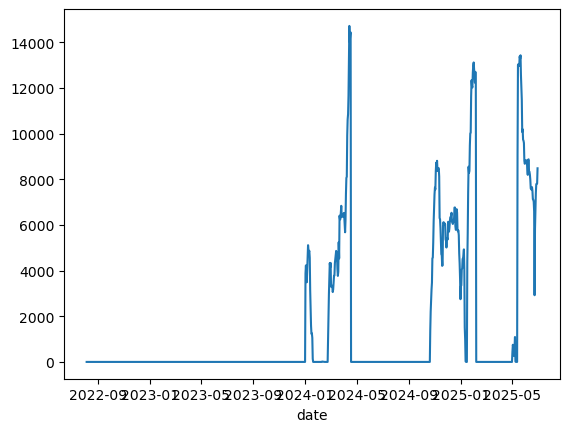

In [574]:
df_os_vov['BTC-USD_actual_position_notional'].plot()

In [416]:
log_std_window=14; coef_of_variation_window=30; vol_of_vol_z_score_window=252; vol_of_vol_p_min=0.6
df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr(start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                      slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                                      exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                                      donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                                      rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                                                                      long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

In [484]:
print(start_date_os)
print(start_date_os - pd.Timedelta(days=283))

2024-01-01
2023-03-24


In [514]:
log_std_window=14; coef_of_variation_window=30; vol_of_vol_z_score_window=252; vol_of_vol_p_min=0.6
WARMUP_DAYS = 534
df_trend_vov = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(start_date=start_date_os - pd.Timedelta(days=WARMUP_DAYS), end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                                     slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, 
                                                                                     exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
                                                                                     donchian_signal_weight=donchian_signal_weight, ma_crossover_signal_weight=ma_crossover_signal_weight, 
                                                                                     rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit,
                                                                                     log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                                                                                     vol_of_vol_p_min=vol_of_vol_p_min,
                                                                                     long_only=long_only, use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

In [516]:
for ticker in ticker_list:
    df_trend_vov[f'{ticker}_t_1_close'] = df_trend_vov[f'{ticker}_close'].shift(1)

In [518]:
df_trend_vov.head()

BTC-USD_close  BTC-USD_open  BTC-USD_mavg_ribbon_slope  \
date                                                                 
2022-07-16       21189.68      20823.06                        NaN   
2022-07-17       20791.74      21189.23               4.594532e-15   
2022-07-18       22427.56      20791.74              -7.407949e-04   
2022-07-19       23395.06      22434.97               1.561179e-03   
2022-07-20       23226.99      23398.46               5.254617e-03   

            BTC-USD_mavg_ribbon_rank  BTC-USD_final_weighted_additive_signal  \
date                                                                           
2022-07-16                       NaN                                     NaN   
2022-07-17                       NaN                                     NaN   
2022-07-18                       NaN                                     NaN   
2022-07-19                       NaN                                     NaN   
2022-07-20                       NaN                                     NaN   

            BTC-USD_rolling_r_sqr  BTC-USD_vol_of_vol_penalty  \
date                                                            
2022-07-16                    0.0                         1.0   
2022-07-17                    0.0                         1.0   
2022-07-18                    0.0                         1.0   
2022-07-19                    0.0                         1.0   
2022-07-20                    0.0                         1.0   

            BTC-USD_regime_filter  BTC-USD_final_signal  ETH-USD_close  \
date                                                                     
2022-07-16                    0.0                   NaN        1355.70   
2022-07-17                    0.0                   NaN        1338.20   
2022-07-18                    0.0                   NaN        1581.34   
2022-07-19                    0.0                   NaN        1542.63   
2022-07-20                    0.0                   NaN        1522.12   

            ETH-USD_open  ETH-USD_mavg_ribbon_slope  ETH-USD_mavg_ribbon_rank  \
date                                                                            
2022-07-16       1231.07                        NaN                       NaN   
2022-07-17       1355.50               3.308833e-15                       NaN   
2022-07-18       1338.03              -5.076767e-04                       NaN   
2022-07-19       1581.09               5.565238e-03                       NaN   
2022-07-20       1542.60               9.985883e-03                       NaN   

            ETH-USD_final_weighted_additive_signal  ETH-USD_rolling_r_sqr  \
date                                                                        
2022-07-16                                     NaN                    0.0   
2022-07-17                                     NaN                    0.0   
2022-07-18                                     NaN                    0.0   
2022-07-19                                     NaN                    0.0   
2022-07-20                                     NaN                    0.0   

            ETH-USD_vol_of_vol_penalty  ETH-USD_regime_filter  \
date                                                            
2022-07-16                         1.0                    0.0   
2022-07-17                         1.0                    0.0   
2022-07-18                         1.0                    0.0   
2022-07-19                         1.0                    0.0   
2022-07-20                         1.0                    0.0   

            ETH-USD_final_signal  SOL-USD_close  SOL-USD_open  \
date                                                            
2022-07-16                   NaN          39.60         37.36   
2022-07-17                   NaN          38.63         39.57   
2022-07-18                   NaN          43.55         38.59   
2022-07-19                   NaN          44.88         43.56   
2022-07-20                   Na

In [520]:
df_trend_vov_check = generate_vol_of_vol_signal_log_space(df_trend_vov, ticker='AVAX-USD', t_1_close_price_col='AVAX-USD_t_1_close')

<Axes: xlabel='date'>

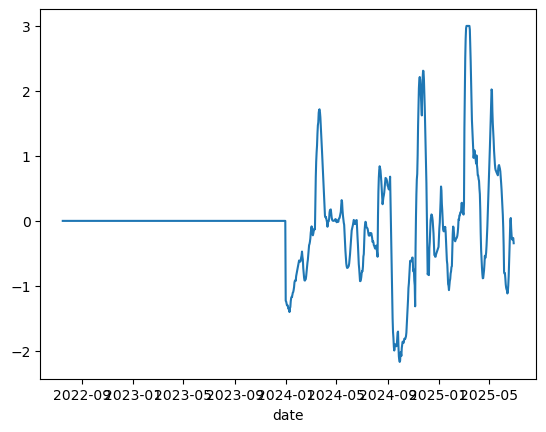

In [522]:
df_trend_vov['AVAX-USD_vol_of_vol_robust_z_score'].plot()

In [526]:
cols = [col for col in df_trend_vov_check.columns if 'AVAX-USD' in col]
df_trend_vov_check[cols]

AVAX-USD_close  AVAX-USD_open  AVAX-USD_mavg_ribbon_slope  \
date                                                                    
2022-07-16           21.24          19.36                         NaN   
2022-07-17           20.62          21.24                1.666389e-15   
2022-07-18           23.97          20.62               -1.157574e-03   
2022-07-19           24.73          23.97                3.697623e-03   
2022-07-20           23.59          24.71                9.226307e-03   
2022-07-21           24.98          23.58                1.228539e-02   
2022-07-22           23.63          24.99                1.723023e-02   
2022-07-23           23.60          23.64                1.943783e-02   
2022-07-24           23.80          23.62                2.133395e-02   
2022-07-25           20.91          23.79                2.333096e-02   
2022-07-26           20.71          20.92                2.002735e-02   
2022-07-27           23.38          20.73                1.670129e-02   
2022-07-28           24.23          23.40                1.847102e-02   
2022-07-29           24.51          24.26                2.142140e-02   
2022-07-30           24.25          24.52                2.447145e-02   
2022-07-31           23.74          24.25                2.674187e-02   
2022-08-01           23.59          23.70                2.790410e-02   
2022-08-02           22.85          23.60                2.866380e-02   
2022-08-03           23.05          22.86                2.806730e-02   
2022-08-04           23.37          23.04                2.785229e-02   
2022-08-05           24.95          23.37                2.817396e-02   
2022-08-06           26.64          24.95                3.098915e-02   
2022-08-07           27.90          26.65                3.602100e-02   
2022-08-08           27.92          27.90                4.226221e-02   
2022-08-09           27.43          27.91                4.779478e-02   
2022-08-10           29.18          27.41                5.197368e-02   
2022-08-11           28.56          29.17                5.805523e-02   
2022-08-12           29.35          28.57                6.256546e-02   
2022-08-13           29.19          29.35                6.758149e-02   
2022-08-14           28.21          29.19                7.176234e-02   
2022-08-15           27.90          28.20                7.407663e-02   
2022-08-16           27.12          27.88                7.563315e-02   
2022-08-17           25.56          27.10                7.583821e-02   
2022-08-18           24.19          25.57                7.363489e-02   
2022-08-19           22.44          24.20                6.945557e-02   
2022-08-20           22.30          22.45                6.274176e-02   
2022-08-21           22.97          22.31                5.647089e-02   
2022-08-22           22.56          22.98                5.199848e-02   
2022-08-23           23.51          22.56                4.726558e-02   
2022-08-24           23.01          23.52                4.462013e-02   
2022-08-25           22.98          23.00                4.137867e-02   
2022-08-26           20.68          22.99                3.839946e-02   
2022-08-27           20.05          20.67                3.158582e-02   
2022-08-28           18.53          20.05                2.428410e-02   
2022-08-29           19.33          18.52                1.468290e-02   
2022-08-30           19.40          19.33                7.779317e-03   
2022-08-31           19.13          19.40                1.766774e-03   
2022-09-01           19.33          19.14               -4.137987e-03   
2022-09-02           18.87          19.34               -8.987556e-03   
2022-09-03           18.89          18.87               -1.424279e-02   
2022-09-04           19.03          18.89               -1.887061e-02   
2022-09-05           19.44          19.03               -2.268938e-02   
2022-09-06           18.21          19.44               -2.524107e-02 

In [510]:
df_trend_vov[(df_trend_vov.index <= pd.Timestamp('2024-06-22').date())].shape

(534, 57)

In [512]:
534/2

267.0

<Axes: xlabel='date'>

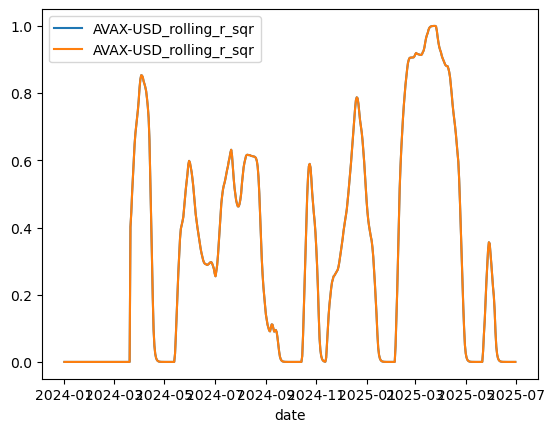

In [420]:
df_trend['AVAX-USD_rolling_r_sqr'].plot()

<Axes: xlabel='date'>

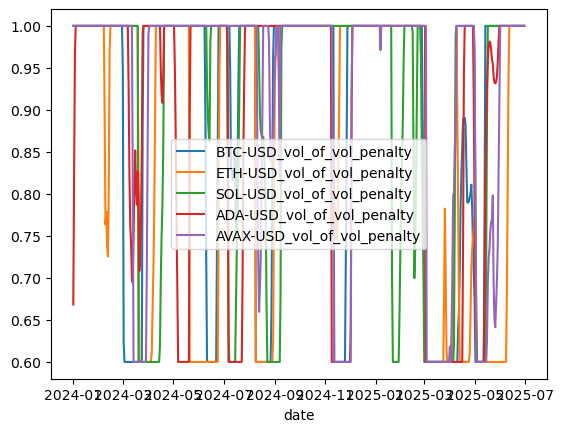

In [528]:
## 534
date_cond = (df_trend_vov.index >= start_date_os)
df_trend_vov[date_cond][['BTC-USD_vol_of_vol_penalty','ETH-USD_vol_of_vol_penalty','SOL-USD_vol_of_vol_penalty','ADA-USD_vol_of_vol_penalty','AVAX-USD_vol_of_vol_penalty']].plot()

<Axes: xlabel='date'>

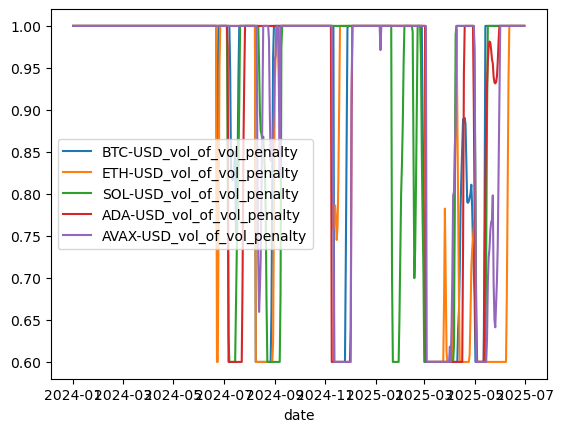

In [502]:
## 360
date_cond = (df_trend_vov.index >= start_date_os)
df_trend_vov[date_cond][['BTC-USD_vol_of_vol_penalty','ETH-USD_vol_of_vol_penalty','SOL-USD_vol_of_vol_penalty','ADA-USD_vol_of_vol_penalty','AVAX-USD_vol_of_vol_penalty']].plot()

<Axes: xlabel='date'>

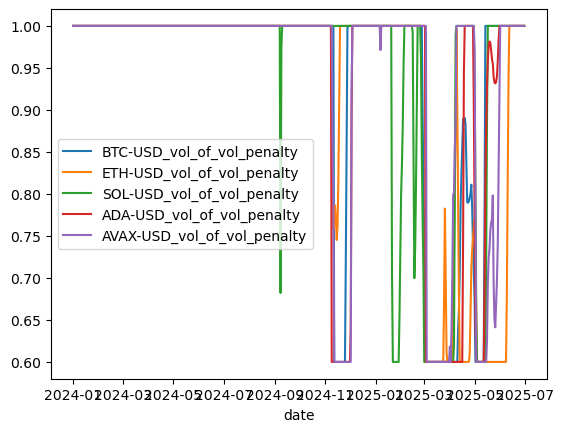

In [488]:
## 283
date_cond = (df_trend_vov.index >= start_date_os)
df_trend_vov[date_cond][['BTC-USD_vol_of_vol_penalty','ETH-USD_vol_of_vol_penalty','SOL-USD_vol_of_vol_penalty','ADA-USD_vol_of_vol_penalty','AVAX-USD_vol_of_vol_penalty']].plot()

<Axes: xlabel='date'>

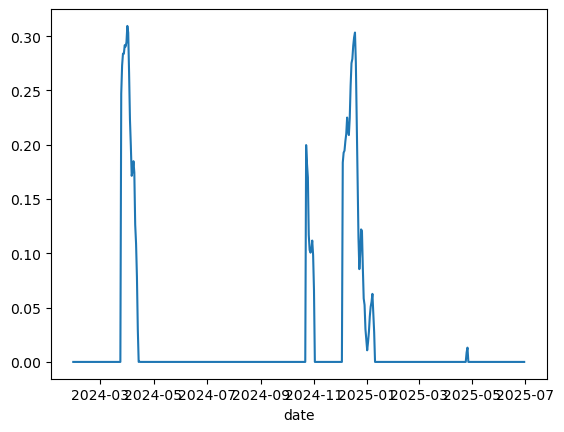

In [392]:
df_os['AVAX-USD_final_signal'].plot()

In [386]:
start_date_os

datetime.date(2024, 1, 1)

In [576]:
perf.calculate_risk_and_performance_metrics(df_os_vov[df_os_vov.index >= pd.Timestamp(start_date_os).date()], strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                           include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.02122948238308009,
 'annualized_sharpe_ratio': 0.029174153461011945,
 'calmar_ratio': -0.0494950809484958,
 'annualized_std_dev': 0.4894843478339456,
 'max_drawdown': -0.4289210559160682,
 'max_drawdown_duration': Timedelta('475 days 00:00:00'),
 'hit_rate': 0.2979890310786106,
 't_statistic': 0.1827808998098945,
 'p_value': 0.855037783355945,
 'trade_count': 1042.0}

In [578]:
df_os = apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr(
            start_date=start_date_os, end_date=end_date_os, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, 
            use_donchian_exit_gate=use_donchian_exit_gate, ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, 
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, long_only=long_only,
            initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
            rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
            transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
            rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
            annualized_target_volatility=annualized_target_volatility,
            annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [580]:
perf.calculate_risk_and_performance_metrics(df_os, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                           include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.15594733200722966,
 'annualized_sharpe_ratio': -0.5786746974924701,
 'calmar_ratio': -0.4228520782782886,
 'annualized_std_dev': 0.5498902387847863,
 'max_drawdown': -0.36879878335278554,
 'max_drawdown_duration': Timedelta('455 days 00:00:00'),
 'hit_rate': 0.15399239543726237,
 't_statistic': -0.499259304161487,
 'p_value': 0.6178058646975957,
 'trade_count': 318.0}

In [510]:
df_rolling_r2_locked_params_performance.to_pickle('/Users/adheerchauhan/Documents/git/trend_following/trend_following_results/Portfolio_Rolling_R_Squared_Locked_Params_OS_Performance-2021-06-01-2025-05-31.pickle')

In [524]:
agg_dict = {'annualized_sharpe_ratio':['median','mean','std'],
            'annualized_return':['median','mean','std'],
            'calmar_ratio':['median','mean','std'],
            'annualized_std_dev':['median','mean','std'],
            'max_drawdown':['median','mean','std'],}

agg_dict = {'annualized_sharpe_ratio':['median','mean'],
            'annualized_return':['median','mean'],
            # 'calmar_ratio':['median','mean'],
            'annualized_std_dev':['median','mean'],
            'max_drawdown':['median','mean'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean']}
df_rolling_r2_locked_params_performance.groupby(['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit']).agg(agg_dict)

annualized_sharpe_ratio  \
                                                                       median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit                           
50                0.2               0.6                              0.140177   
                                    0.9                              0.051404   
                  0.3               0.6                             -0.142183   
                                    0.9                             -0.235173   
80                0.2               0.6                              0.853225   
                                    0.9                              0.853812   
                  0.3               0.6                              0.704425   
                                    0.9                              0.687912   

                                                                 \
                                                           mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit             
50                0.2               0.6                0.155338   
                                    0.9                0.145652   
                  0.3               0.6                0.106637   
                                    0.9                0.104349   
80                0.2               0.6                0.873205   
                                    0.9                0.865304   
                  0.3               0.6                0.679917   
                                    0.9                0.658588   

                                                      annualized_return  \
                                                                 median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit                     
50                0.2               0.6                        0.024744   
                                    0.9                       -0.014146   
                  0.3               0.6                       -0.080547   
                                    0.9                       -0.093296   
80                0.2               0.6                        0.334249   
                                    0.9                        0.331881   
                  0.3               0.6                        0.268579   
                                    0.9                        0.262812   

                                                                 \
                                                           mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit             
50                0.2               0.6                0.228914   
                                    0.9                0.230789   
                  0.3               0.6                0.268728   
                                    0.9                0.279422   
80                0.2               0.6                0.345938   
                                    0.9                0.341528   
                  0.3               0.6                0.256595   
                                    0.9                0.248517   

                                                      annualized_std_dev  \
                                                                  median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit                      
50                0.2               0.6                         0.593591   
                                    0.9                         0.602959   
                  0.3               0.6                         0.627126   
                                    0.9                         0.634717   
80                0.2               0.6                         0.600429   
                                    0.9                         0.608485   
                  0.3               0.6                         0.616281   
                                    0.9                         0.620426   

                       

In [522]:
agg_dict = {'annualized_sharpe_ratio':['median','mean'],
            'annualized_return':['median','mean'],
            # 'calmar_ratio':['median','mean'],
            'annualized_std_dev':['median','mean'],
            'max_drawdown':['median','mean'],
            'BTC-USD_annualized_sharpe_ratio':['median','mean'],
            'ETH-USD_annualized_sharpe_ratio':['median','mean'],
            'SOL-USD_annualized_sharpe_ratio':['median','mean'],
            'ADA-USD_annualized_sharpe_ratio':['median','mean'],
            'AVAX-USD_annualized_sharpe_ratio':['median','mean']}
df_rolling_r2_locked_params_performance.groupby(['rolling_r2_window','lower_r_sqr_limit','upper_r_sqr_limit','start_date']).agg(agg_dict)

annualized_sharpe_ratio  \
                                                                                  median   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit start_date                           
50                0.2               0.6               2023-06-01                1.872357   
                                                      2023-12-01               -0.100270   
                                                      2024-06-01                0.380623   
                                                      2024-12-01               -1.531359   
                                    0.9               2023-06-01                1.932569   
                                                      2023-12-01               -0.212618   
                                                      2024-06-01                0.315427   
                                                      2024-12-01               -1.452771   
                  0.3               0.6               2023-06-01                2.274751   
                                                      2023-12-01               -0.573259   
                                                      2024-06-01                0.288892   
                                                      2024-12-01               -1.563838   
                                    0.9               2023-06-01                2.336882   
                                                      2023-12-01               -0.710277   
                                                      2024-06-01                0.239931   
                                                      2024-12-01               -1.449138   
80                0.2               0.6               2023-06-01                1.475890   
                                                      2023-12-01                0.310482   
                                                      2024-06-01                0.891134   
                                                      2024-12-01                0.815315   
                                    0.9               2023-06-01                1.478576   
                                                      2023-12-01                0.275015   
                                                      2024-06-01                0.828826   
                                                      2024-12-01                0.878797   
                  0.3               0.6               2023-06-01                1.120458   
                                                      2023-12-01                0.190359   
                                                      2024-06-01                0.468764   
                                                      2024-12-01                0.940086   
                                    0.9               2023-06-01                1.123806   
                                                      2023-12-01                0.134723   
                                                      2024-06-01                0.380944   
                                                      2024-12-01                0.994880   

                                                                            \
                                                                      mean   
rolling_r2_window lower_r_sqr_limit upper_r_sqr_limit start_date             
50                0.2               0.6               2023-06-01  1.872357   
                                                      2023-12-01 -0.100270   
                                                      2024-06-01  0.380623   
                                                      2024-12-01 -1.531359   
                                    0.9               2023-06-01  1.932569   
                                                      2023-12-01 -0.212618   
                                                      2024-06-01  0.315427   
                                                      2024-12-01

In [171]:
## With activation
fast_mavg = 16
slow_mavg = 224
mavg_stepsize = 8
entry_window = 28
exit_window = 28
exit_gate = False
w_mavg = 0.8
w_donchian = 0.2
df_is = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
    tanh_activation_constant_dict=None, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


<Axes: xlabel='date'>

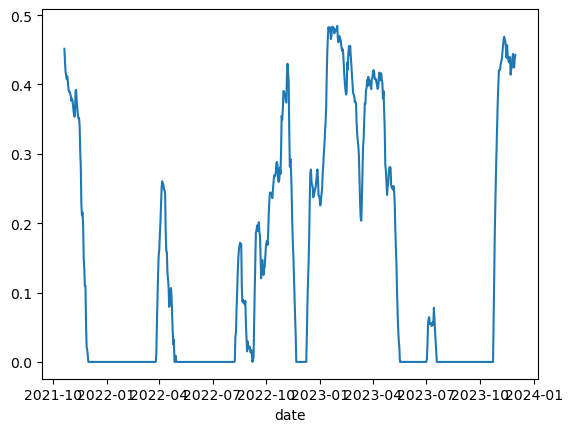

In [163]:
## Without Activation
df_is['BTC-USD_final_signal'].plot()

<Axes: xlabel='date'>

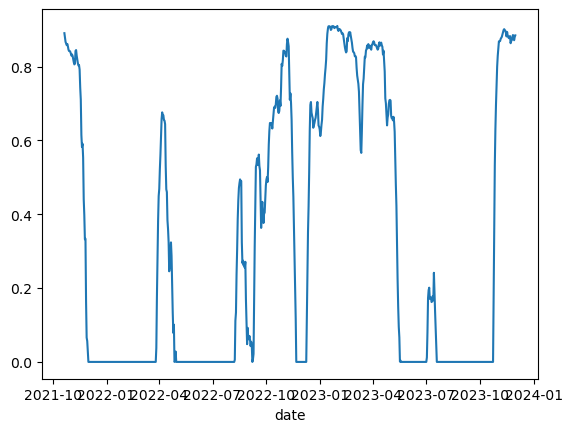

In [172]:
## With Activation
df_is['BTC-USD_final_signal'].plot()

In [155]:
df_is.head()

BTC-USD_20_avg_true_range_price  BTC-USD_actual_position_notional  \
date                                                                            
2021-10-21                      3029.172671                          0.000000   
2021-10-22                      3178.856226                       4543.743741   
2021-10-23                      3233.250872                       4432.631533   
2021-10-24                      3125.322217                       4477.711038   
2021-10-25                      3015.202958                       4444.686287   

            BTC-USD_actual_position_size  BTC-USD_annualized_volatility_20  \
date                                                                         
2021-10-21                      0.000000                          0.654385   
2021-10-22                      0.073046                          0.639165   
2021-10-23                      0.073046                          0.651724   
2021-10-24                      0.073046                          0.651816   
2021-10-25                      0.073046                          0.656002   

            BTC-USD_cash_shrink_factor  BTC-USD_close  \
date                                                    
2021-10-21                         0.0       62204.02   
2021-10-22                         0.0       60687.64   
2021-10-23                         0.0       61300.01   
2021-10-24                         0.0       60854.48   
2021-10-25                         0.0       63083.54   

            BTC-USD_cooldown_counter       BTC-USD_event  \
date                                                       
2021-10-21                       0.0                 NaN   
2021-10-22                       0.0   New Long Position   
2021-10-23                       0.0  Open Long Position   
2021-10-24                       0.0  Open Long Position   
2021-10-25                       0.0  Open Long Position   

            BTC-USD_final_signal  BTC-USD_final_weighted_additive_signal  \
date                                                                       
2021-10-21              0.451489                                0.451489   
2021-10-22              0.433038                                0.433038   
2021-10-23              0.418481                                0.418481   
2021-10-24              0.413344                                0.413344   
2021-10-25              0.407576                                0.407576   

            BTC-USD_new_position_entry_exit_price  \
date                                                
2021-10-21                                   0.00   
2021-10-22                               62204.01   
2021-10-23                               60682.88   
2021-10-24                               61300.02   
2021-10-25                               60847.91   

            BTC-USD_new_position_notional  BTC-USD_new_position_size  \
date                                                                   
2021-10-21                       0.000000                   0.000000   
2021-10-22                    4543.743741                   0.073046   
2021-10-23                       0.000000                   0.000000   
2021-10-24                       0.000000                   0.000000   
2021-10-25                       0.000000                   0.000000   

            BTC-USD_open  BTC-USD_open_position_notional  \
date                                                       
2021-10-21      66021.26                        0.000000   
2021-10-22      62204.01                        0.000000   
2021-10-23      60682.88                     4432.631533   
2021-10-24      61300.02                     4477.711038   
2021-10-25      60847.91                     4444.686287   

            BTC-USD_open_position_size  BTC-USD_short_sale_proceeds  \
date                                                                  
2021-10-21                    0.000000                          0.0   
2021-10-22                    0.

In [157]:
perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                           include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.23400134562743602,
 'annualized_sharpe_ratio': -0.47510497520815587,
 'calmar_ratio': -0.3280133746315728,
 'annualized_std_dev': 0.5652218255963256,
 'max_drawdown': -0.7133896472674877,
 'max_drawdown_duration': Timedelta('739 days 00:00:00'),
 'hit_rate': 0.3203631647211414,
 't_statistic': -0.5329376375777404,
 'p_value': 0.5942305209159131,
 'trade_count': 1054.0}

In [132]:
np.abs(df_is['BTC-USD_final_weighted_additive_signal']).quantile(0.95)

0.46594857579383253

In [108]:
np.abs(df_is['ETH-USD_final_weighted_additive_signal']).quantile(0.95)

0.4699992899434025

In [110]:
np.abs(df_is['ADA-USD_final_weighted_additive_signal']).quantile(0.95)

0.4706896393150276

In [112]:
np.abs(df_is['SOL-USD_final_weighted_additive_signal']).quantile(0.95)

0.47152392407208465

In [114]:
np.abs(df_is['AVAX-USD_final_weighted_additive_signal']).quantile(0.95)

0.47236458399095443

In [248]:
final_weighted_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in ticker_list]
tanh_activation_constant_dict = {}
for ticker in ticker_list:
    tanh_activation_constant_dict[ticker] = np.abs(df_is[f'{ticker}_final_weighted_additive_signal']).quantile(0.95)

In [250]:
tanh_activation_constant_dict

{'BTC-USD': 0.46594857579383253,
 'ETH-USD': 0.4699992899434025,
 'SOL-USD': 0.47152392407208465,
 'ADA-USD': 0.4706896393150276,
 'AVAX-USD': 0.47254282901082484}

In [136]:
fast_mavg = 16
slow_mavg = 224
mavg_stepsize = 8
entry_window = 28
exit_window = 28
exit_gate = False
w_mavg = 0.8
w_donchian = 0.2
df_is = apply_target_volatility_position_sizing_continuous_strategy(
    start_date=pd.Timestamp('2021-06-01').date(), end_date=pd.Timestamp('2023-11-30').date(), ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize, entry_rolling_donchian_window=entry_window, exit_rolling_donchian_window=exit_window, 
    use_donchian_exit_gate=exit_gate, ma_crossover_signal_weight=w_mavg, donchian_signal_weight=w_donchian, 
    tanh_activation_constant_dict=tanh_activation_constant_dict, long_only=long_only,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=signal_start_date)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!


In [138]:
perf.calculate_risk_and_performance_metrics(df_is, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                           include_transaction_costs_and_fees=False, annual_trading_days=365)

{'annualized_return': -0.23399189526878894,
 'annualized_sharpe_ratio': -0.47448346144804493,
 'calmar_ratio': -0.32790121104352055,
 'annualized_std_dev': 0.564685901685028,
 'max_drawdown': -0.7136048522789153,
 'max_drawdown_duration': Timedelta('739 days 00:00:00'),
 'hit_rate': 0.3203631647211414,
 't_statistic': -0.5321355580181899,
 'p_value': 0.5947856141730341,
 'trade_count': 1060.0}

In [388]:
## Decide on which entry gate to use for the Donchian Channel Signal
## Lock the Stepsize to 8 and gate to False
entry_cond = ((df_performance_os['cluster'] == 'MA_16_224') & (df_performance_os['entry'].isin([21, 28])) & (df_performance_os['gate'] == False) & (df_performance_os['step'].isin([6, 8])))
df_ma_ribbon_weight_performance = (
    df_performance_os[entry_cond]
    .groupby(["cluster","entry","step","mavg_ribbon_weight","donchian_weight"])
    .agg(mean_sharpe      = ("annualized_sharpe_ratio","mean"),
        sharpe_std       = ("annualized_sharpe_ratio","std"),
        worst_sharpe     = ("annualized_sharpe_ratio","min"),
        pos_sharpe_pct   = ("annualized_sharpe_ratio", lambda x: (x > 0).mean()),  # % of slices with Sharpe > 0
        worst_dd         = ("max_drawdown","min"),
        mean_dd          = ("max_drawdown","mean"),
        mean_return      = ("annualized_return","mean"),
        mean_trade_count = ("trade_count","mean"))
    .reset_index()
    .sort_values("mean_sharpe", ascending=False)
)
## Entry window of 28 has the best performance

In [390]:
df_ma_ribbon_weight_performance

cluster  entry  step  mavg_ribbon_weight  donchian_weight  mean_sharpe  \
2  MA_16_224     28     8                 0.8              0.2     1.599653   
0  MA_16_224     28     6                 0.7              0.3     1.406795   
1  MA_16_224     28     6                 1.0              0.0     0.301437   
3  MA_16_224     28     8                 1.0              0.0     0.288365   

   sharpe_std  worst_sharpe  pos_sharpe_pct  worst_dd   mean_dd  mean_return  \
2    0.000000      1.599653        1.000000 -0.299902 -0.299902     0.876251   
0    0.000000      1.406795        1.000000 -0.318594 -0.318594     0.739236   
1    0.902938     -0.866479        0.666667 -0.290080 -0.241992     0.240621   
3    0.943051     -0.848256        0.666667 -0.290532 -0.241953     0.246418   

   mean_trade_count  
2        240.000000  
0        253.000000  
1        189.666667  
3        187.333333

In [362]:
# OOS only, fixed structure
filt = (df_performance_os["cluster"].eq("MA_16_224") &
        df_performance_os["entry"].eq(28) &
        df_performance_os["step"].eq(8) &
        df_performance_os["gate"].eq(False) &
        df_performance_os["exit"].isin([21, 28]))      # or include all exits you keep

w_profile = (df_performance_os.loc[filt]
             .groupby("mavg_ribbon_weight")["annualized_sharpe_ratio"]
             .agg(mean_sharpe="mean", worst="min", count="size")
             .sort_index())

print(w_profile)  # look for a broad top; 0.65–0.70 should stand out


                    mean_sharpe     worst  count
mavg_ribbon_weight                              
0.8                    1.599653  1.599653      2
1.0                    0.288365 -0.848256      6


In [372]:
filt = (df_performance_is["cluster"].eq("MA_16_224") &
        df_performance_is["entry"].eq(28) &
        df_performance_is["step"].eq(8) &
        df_performance_is["gate"].eq(False) &
        df_performance_is["exit"].isin([21, 28])) 

In [380]:
(df_performance_is[filt].groupby("mavg_ribbon_weight")["annualized_sharpe_ratio"]
 .agg(mean_sharpe="mean", worst="min", count="size")
 .sort_index())

mean_sharpe     worst  count
mavg_ribbon_weight                              
0.0                   -0.336300 -1.790570      8
0.1                   -0.339208 -1.533497      8
0.2                   -0.329561 -1.764056      8
0.3                   -0.357665 -1.570500      8
0.4                   -0.456633 -1.835694      8
0.5                   -0.182735 -1.338456      8
0.6                   -0.090852 -1.242756      8
0.7                    0.042317 -1.171769      8
0.8                    0.132148 -0.994416      8
0.9                    0.195636 -0.803920      8
1.0                    0.263339 -0.969117      8

In [115]:
df_performance.head()

sampling_category  start_date    end_date mavg_strategy donchian_strategy  \
0         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
1         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
2         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
3         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   
4         in_sample  2021-06-01  2023-05-31   f16_s224_n2   en28_ex7_gFalse   

   mavg_ribbon_weight  donchian_weight  annualized_return  \
0                 0.0              1.0          -0.620453   
1                 0.1              0.9          -0.562871   
2                 0.2              0.8          -0.609231   
3                 0.3              0.7          -0.573392   
4                 0.4              0.6          -0.582723   

   annualized_sharpe_ratio  calmar_ratio  annualized_std_dev  max_drawdown  \
0                -1.790570     -0.724938            0.605099     -0.855872   
1                -1.525900     -0.689592            0.601925     -0.816238   
2                -1.811975     -0.726001            0.589945     -0.839160   
3                -1.628057     -0.701307            0.591289     -0.817604   
4                -1.713242     -0.721869            0.577925     -0.807242   

  max_drawdown_duration  hit_rate  t_statistic   p_value  trade_count  \
0              554 days  0.295918    -2.148274  0.032100        971.0   
1              568 days  0.301020    -1.811222  0.070618        937.0   
2              568 days  0.292517    -2.170978  0.030333        919.0   
3              568 days  0.295918    -1.937661  0.053144        931.0   
4              568 days  0.295918    -2.043427  0.041456        958.0   

   BTC-USD_annualized_return  ETH-USD_annualized_return  \
0                  -0.079120                   0.032138   
1                  -0.029747                   0.038420   
2                  -0.024450                   0.027445   
3                  -0.055202                   0.013657   
4                  -0.045804                   0.003794   

   SOL-USD_annualized_return  ADA-USD_annualized_return  \
0                  -0.133513                  -0.177671   
1                  -0.153291                  -0.155203   
2                  -0.129162                  -0.184051   
3                  -0.114844                  -0.100404   
4                  -0.081056                  -0.150840   

   AVAX-USD_annualized_return  BTC-USD_annualized_sharpe_ratio  \
0                   -0.019710                        -1.050796   
1                    0.021465                        -0.617141   
2                   -0.099614                        -0.556325   
3                   -0.110949                        -0.832067   
4                   -0.124228                        -0.762874   

   ETH-USD_annualized_sharpe_ratio  SOL-USD_annualized_sharpe_ratio  \
0                        -0.069017                        -1.763589   
1                        -0.021369                        -2.003182   
2                        -0.107031                        -1.771100   
3                        -0.164491                        -1.689328   
4                        -0.272796                        -1.484869   

   ADA-USD_annualized_sharpe_ratio  AVAX-USD_annualized_sharpe_ratio  \
0                        -1.083856                         -0.239506   
1                        -1.020310                         -0.027091   
2                        -1.303042                         -0.694627   
3                        -0.811004                         -0.761776   
4                        -1.268906                         -0.809378   

   BTC-USD_annualized_std_dev  ETH-USD_annualized_std_dev  \
0                    0.174840                    0.197752   
1                    0.173697                    0.196139   
2                    0.175399                    0.191048   
3                    0.172670            